
# Capstone Project:
# Create a Customer Segmentation Report for Arvato Financial Services

In this project, I will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. I'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, I'll apply what I've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that I will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

I have completed the first term of this program, therefore I am familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. 

**The project are divided into 3 notebooks**
1. Data Exploration, decision making and developing of a general cleaning routine that will be reused in step 2 and 3
2. Clustering of the people of Germany into segments, and analysing to which clusters the mail order custombers belongs to
3. Target Marketing Prediction

# Part 1: Data Exploration and designing of a general cleaning process

This notebook is focussing on exploring the data, which guides decisions how best to clean the data:
- which columns and rows to drop, but also which features not to drop no matter what
- feature enhancements, e.g. stripping columns containing multiple information into seperate columns
- transforming columns through one-hot-encoding
- deciding the best approach for imputing e.g. SimpleImputer vs InterativeImputer
- deciding the best appraoch for scaling e.g. StandardScaler vs MinMaxScaler

### Deliverables of this notebook:
- configuration files are generated specifying which columns to drop and transform (stored in 'data/config')
- re-usable cleaning function using above configuration columns
- trained imputer stored in 'data/models/' that are reused in cleaning functions
- trained global scaler stored in 'data/models/ that are reused in supervised and unsupervised training

---

## Contents

1.  <a href='#load_data'>Load the data</a>
1.  <a href='#missing_values'>Handling missing values</a>
    - <a href='#missing_values_columns'>Columns with too many missing values</a>
    - <a href='#missing_values_household'>Household level column analysis (due too exceptional amount of missing values)</a>    
    - <a href='#missing_values_grid'>Grid level column analysis (due too exceptional amount of missing values)</a>
    - <a href='#missing_values_feature_importance'>Feature Importance - A first impression</a>
    - <a href='#missing_values_rows'>Rows with too many missing values</a>
    
    
3.  <a href='#feature_engineering'>Feature Engineering and Transformations</a>
1.  <a href='#correlation'>Correlation Analysis</a>
1.  <a href='#impute'>Impute missing values</a>
1.  <a href='#test_cleaning_function'>Test cleaning function</a>
1.  <a href='#scale'>Create scaling objects for re-use</a>
1.  <a href='#references'>References</a>

---

In [1]:
import os

# To load and save models
from pickle import dump

import missingno as msno
# import sagemaker
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Import custom modules
from src.config import *
from src.data_cleansing import *
from src.data_loading import *
from src.helper import *
from src.visuals import *

# environment settings
pd.set_option('display.max_column', 400)
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_colwidth', 400)
pd.set_option('expand_frame_repr', True)

# magic word for producing visualizations in notebook
%matplotlib inline

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

<a id='load_data'></a>
# Step 1: Load the data

## Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

---

Input data for this project are provided by Udacity, which has been saved on S3. Since we would rather work with this file locally we can perform a bit of notebook magic to copy the files to `data/raw`.

Check if the raw directory does not exist, create the directory and copy the files. 

In [2]:
# write grid columns as csv file to data/config folder and s3 for reuse in clean function
data_dir = path_config
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
    
    
    
    
    path = "s3://{}/{}/{}".format(bucket, prefix, path_raw)
    !aws s3 cp --recursive $path $path_raw

### Step 1.1: Load the level each feature belongs to
This file was provided by Udacity and describe the category/level each field belongs to.
I will use the file to make analysing 366 features easier by splitting it understandable sections

File was manualy enhanced to correct column names so it can be matched to other files and data

- Remove suffix '_RZ' from 125x125 grid level fields (e.g. D19_TECHNIK_RZ to D19_TECHNIK
- added D19_KONSUMTYP_MAX 
- correct spelling of fieldname D19_BUCH_CD (e.g. D19_BUCK_RZ to D19_BUCH_CD)

Create a dictionary which map each field to level

In [3]:
# Load dataset describing the different information levels attributes belongs to
path = "{}/{}".format(path_raw, config.filename_levels)
levels, levels_dict = load_levels(path, config.filename_levels_sheet)
levels.head()

Information level  \
Attribute                                
AGER_TYP                           NaN   
ALTERSKATEGORIE_GROB            Person   
ANREDE_KZ                       Person   
CJT_GESAMTTYP                   Person   
FINANZ_MINIMALIST               Person   

                                                                                                           Description  \
Attribute                                                                                                                
AGER_TYP                                                                                            best-ager typology   
ALTERSKATEGORIE_GROB                                                                     age through prename analysis    
ANREDE_KZ                                                                                                       gender   
CJT_GESAMTTYP         Customer-Journey-Typology relating to the preferred information and buying channels of consumers   
FINANZ_MINIMALIST                                                           financial typology: low financial interest   

                                                                                                                                                                                                                                                       Additional notes  
Attribute                                                                                                                                                                                                                                                                
AGER_TYP                                                                                                                                                                                     in cooperation with Kantar TNS; the information basis is a consumer survey  
ALTERSKATEGORIE_GROB                                                                                                                                                                                            modelled on millions of first name-age-reference data    
ANREDE_KZ                                                                                                                                                                                                       modelled on millions of first name-age-reference data    
CJT_GESAMTTYP         relating to the preferred information, marketing and buying channels of consumers as well as their cross-channel usage. The information basis is a survey on the consumer channel preferences combined via a statistical modell with AZ DIAS data  
FINANZ_MINIMALIST                                                                                                                                           Gfk-Typology based on a representative household panel combined via a statistical modell with AZ DIAS data

In [4]:
levels.shape

(320, 3)

In [5]:
list(levels_dict.items())[:20]

[('AGER_TYP', nan),
 ('ALTERSKATEGORIE_GROB', 'Person'),
 ('ANREDE_KZ', 'Person'),
 ('CJT_GESAMTTYP', 'Person'),
 ('FINANZ_MINIMALIST', 'Person'),
 ('FINANZ_SPARER', 'Person'),
 ('FINANZ_VORSORGER', 'Person'),
 ('FINANZ_ANLEGER', 'Person'),
 ('FINANZ_UNAUFFAELLIGER', 'Person'),
 ('FINANZ_HAUSBAUER', 'Person'),
 ('FINANZTYP', 'Person'),
 ('GEBURTSJAHR', 'Person'),
 ('GFK_URLAUBERTYP', 'Person'),
 ('GREEN_AVANTGARDE', 'Person'),
 ('HEALTH_TYP', 'Person'),
 ('LP_LEBENSPHASE_FEIN', 'Person'),
 ('LP_LEBENSPHASE_GROB', 'Person'),
 ('LP_FAMILIE_FEIN', 'Person'),
 ('LP_FAMILIE_GROB', 'Person'),
 ('LP_STATUS_FEIN', 'Person')]

### Step 1.2: Load feature descriptions

File was enhanced to clean-up missing values where it's needed, manually in Excel
Changes are marked in RED in the excel file

Further missing values were identified:

These fields were totally absent from the file, and was manually added to indicate missing values

- D19_VERSI_ONLINE_QUOTE_12 = 0
- D19_TELKO_ONLINE_QUOTE_12 = 0 
- D19_VERSI_ONLINE_DATUM = 0
- D19_VERSI_OFFLINE_DATUM = 0
- D19_VERSI_DATUM = 0
- D19_KONSUMTYP_MAX = 0
- D19_SOZIALES = 0

Further values were marked as missing:
- MIN_GEBAEUDEJAHR = 0
- ALTERSKATEGORIE_GROB = 9 (Value 'uniformely distributed' does not seem to fit with rest of the ranking
- ALTER_HH = 0
- D19_LETZTER_KAUF_BRANCHE = 'D19_UNBEKANNT'
- MOBI_REGIO = 6 was changed to have description = unknown


In [6]:
path = "{}/{}".format(path_raw, config.filename_attributes)
attributes, missing_dict_unknown, missing_dict_all, missing_df_transactions = load_attribute_descriptions(path, config.filename_attributes_sheet)
attributes[attributes['Attribute'] == 'MOBI_REGIO']

Attribute      Description Value             Meaning
2004  MOBI_REGIO  moving patterns     1  very high mobility
2005  MOBI_REGIO  moving patterns     2       high mobility
2006  MOBI_REGIO  moving patterns     3     middle mobility
2007  MOBI_REGIO  moving patterns     4        low mobility
2008  MOBI_REGIO  moving patterns     5  very low mobility 
2009  MOBI_REGIO  moving patterns     6             unknown

In [7]:
# display first 10 lines of missing values dictionary
list(missing_dict_unknown.items())[:15]

[('AGER_TYP', ['-1', '0']),
 ('ALTERSKATEGORIE_GROB', ['-1', '0', '9']),
 ('ALTER_HH', ['0']),
 ('ANREDE_KZ', ['-1', '0']),
 ('BALLRAUM', ['-1']),
 ('BIP_FLAG', ['-1']),
 ('CAMEO_DEUG_2015', ['-1', 'X']),
 ('CAMEO_DEU_2015', ['XX']),
 ('CAMEO_INTL_2015', ['-1', 'XX']),
 ('CJT_GESAMTTYP', ['0']),
 ('KK_KUNDENTYP', ['-1']),
 ('EWDICHTE', ['-1']),
 ('FINANZTYP', ['-1']),
 ('FINANZ_ANLEGER', ['-1']),
 ('FINANZ_HAUSBAUER', ['-1'])]

In [8]:
# display first 10 lines of missing values dictionary
list(missing_dict_all.items())[:15]

[('AGER_TYP', ['-1', '0']),
 ('ALTERSKATEGORIE_GROB', ['-1', '0', '9']),
 ('ALTER_HH', ['0']),
 ('ANREDE_KZ', ['-1', '0']),
 ('ANZ_HAUSHALTE_AKTIV', ['0']),
 ('ANZ_HH_TITEL', ['0']),
 ('ANZ_PERSONEN', ['0']),
 ('ANZ_TITEL', ['0']),
 ('BALLRAUM', ['-1']),
 ('BIP_FLAG', ['-1']),
 ('CAMEO_DEUG_2015', ['-1', 'X']),
 ('CAMEO_DEU_2015', ['XX']),
 ('CAMEO_INTL_2015', ['-1', 'XX']),
 ('CJT_GESAMTTYP', ['0']),
 ('D19_BANKEN_ANZ_12', ['0'])]

In [9]:
feature_list = attributes[['Attribute', 'Description']].drop_duplicates().set_index(['Attribute'])
feature_description = feature_list['Description'].to_dict()
list(feature_description.items())[:10]

[('AGER_TYP', 'best-ager typology'),
 ('ALTERSKATEGORIE_GROB', 'age classification through prename analysis '),
 ('ALTER_HH', 'main age within the household'),
 ('ANREDE_KZ', 'gender'),
 ('ANZ_HAUSHALTE_AKTIV', 'number of households in the building'),
 ('ANZ_HH_TITEL', 'number of academic title holder in building'),
 ('ANZ_PERSONEN', 'number of adult persons in the household'),
 ('ANZ_TITEL', 'number of professional title holder in household '),
 ('BALLRAUM', 'distance to next urban centre '),
 ('BIP_FLAG', 'business-flag indicating companies in the building')]

### Step 1.3: Load demograpic data

After several rounds of exploration a data load routine was created to encode missing values correct during import

- EINGEFUEGT_AM is a date/time stamp. Using google translate I assume it's the date the customer was added to the database. I trimmed this field down to year

In [10]:
# Reading main dataset replacing missing values marked with label 'unknown' with NaN. 
path = "{}/{}".format(path_raw, config.filename_demographics)
azdias = load_dataset(path, 
                      delimiter=config.filename_demographics_delimiter, 
                      na_values=missing_dict_unknown,
                      reset_na=missing_df_transactions,
                      visualize=False)

# Reading main dataset again, treating transaction fields = 0, temporarily as missing values
# all null values are basically excluded from plots to allow us to zoom into the values we do have
azdias_extended_na = load_dataset(path, 
                               delimiter=config.filename_demographics_delimiter, 
                               na_values=missing_dict_all,
                               reset_na=[],
                               visualize=False)

In [11]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(279), int64(84), object(3)
memory usage: 2.4+ GB


In [12]:
# Display summary statistics for each column
describe_azdias = azdias.describe(include='all').transpose()
describe_azdias.sort_values('count')[:20]

count unique                 top   freq  \
ALTER_KIND4                 1205.0    NaN                 NaN    NaN   
TITEL_KZ                    2160.0    NaN                 NaN    NaN   
ALTER_KIND3                 6170.0    NaN                 NaN    NaN   
ALTER_KIND2                29499.0    NaN                 NaN    NaN   
ALTER_KIND1                81058.0    NaN                 NaN    NaN   
AGER_TYP                  205378.0    NaN                 NaN    NaN   
EXTSEL992                 237068.0    NaN                 NaN    NaN   
KK_KUNDENTYP              306609.0    NaN                 NaN    NaN   
KBA05_BAUMAX              414697.0    NaN                 NaN    NaN   
D19_LETZTER_KAUF_BRANCHE    438770     34  D19_VERSICHERUNGEN  57734   
GEBURTSJAHR               498903.0    NaN                 NaN    NaN   
ALTER_HH                  580954.0    NaN                 NaN    NaN   
ALTERSKATEGORIE_FEIN      628274.0    NaN                 NaN    NaN   
D19_KONSUMTYP             634108.0    NaN                 NaN    NaN   
D19_KONSUMTYP_MAX         634108.0    NaN                 NaN    NaN   
REGIOTYP                  733157.0    NaN                 NaN    NaN   
KKK                       733157.0    NaN                 NaN    NaN   
KBA05_AUTOQUOT            743106.0    NaN                 NaN    NaN   
KBA05_CCM1                743111.0    NaN                 NaN    NaN   
KBA05_ALTER1              743111.0    NaN                 NaN    NaN   

                                 mean        std     min     25%     50%  \
ALTER_KIND4                 15.089627   2.452932     7.0    14.0    15.0   
TITEL_KZ                     1.318519   0.999504     1.0     1.0     1.0   
ALTER_KIND3                 14.476013   2.712427     4.0    13.0    15.0   
ALTER_KIND2                 13.402658     3.2433     2.0    11.0    14.0   
ALTER_KIND1                 11.745392    4.09766     2.0     8.0    12.0   
AGER_TYP                      1.74341   0.674312     1.0     1.0     2.0   
EXTSEL992                   33.338392  14.537408     1.0    23.0    34.0   
KK_KUNDENTYP                  3.41064   1.628844     1.0     2.0     3.0   
KBA05_BAUMAX                 2.539534   1.693151     1.0     1.0     1.0   
D19_LETZTER_KAUF_BRANCHE          NaN        NaN     NaN     NaN     NaN   
GEBURTSJAHR               1967.102689  17.795208  1900.0  1955.0  1968.0   
ALTER_HH                    15.291805   3.800536     1.0    13.0    16.0   
ALTERSKATEGORIE_FEIN        13.700717   5.079849     0.0    11.0    14.0   
D19_KONSUMTYP                 5.42454   3.234275     1.0     2.0     5.0   
D19_KONSUMTYP_MAX            4.571679   2.994544     1.0     2.0     4.0   
REGIOTYP                     4.472086   1.836357     1.0     3.0     5.0   
KKK                          2.723384   0.979867     1.0     2.0     3.0   
KBA05_AUTOQUOT               3.092708   1.148332     1.0     2.0     3.0   
KBA05_CCM1                   2.964709    1.07121     1.0     2.0     3.0   
KBA05_ALTER1                 1.933454   1.191588     0.0     1.0     2.0   

                             75%     max  
ALTER_KIND4                 17.0    18.0  
TITEL_KZ                     1.0     5.0  
ALTER_KIND3                 17.0    18.0  
ALTER_KIND2                 16.0    18.0  
ALTER_KIND1                 15.0    18.0  
AGER_TYP                     2.0     3.0  
EXTSEL992                   43.0    56.0  
KK_KUNDENTYP                 5.0     6.0  
KBA05_BAUMAX                 4.0     5.0  
D19_LETZTER_KAUF_BRANCHE     NaN     NaN  
GEBURTSJAHR               1981.0  2017.0  
ALTER_HH                    18.0    21.0  
ALTERSKATEGORIE_FEIN        17.0    25.0  
D19_KONSUMTYP                9.0     9.0  
D19_KONSUMTYP_MAX            8.0     8.0  
REGIOTYP                     6.0     7.0  
KKK                          3.0     4.0  
KBA05_AUTOQUOT               4.0     5.0  
KBA05_CCM1                   4.0     5.0  
KBA05_ALTER1                 3.0     4.0

### Step 1.5: Load customer data

In [13]:
# Reading main dataset replacing missing values marked with label 'unknown' with NaN. 
path = "{}/{}".format(path_raw, config.filename_customer)
customers = load_dataset(path, 
                        delimiter=config.filename_customer_delimiter, 
                        na_values=missing_dict_unknown,
                        reset_na=missing_df_transactions,
                        visualize=False)

# Reading main dataset again, treating transaction fields = 0, temporarily as missing values
# all null values are basically excluded from plots to allow us to zoom into the values we do have
customers_extended_na = load_dataset(path, 
                                     delimiter=config.filename_customer_delimiter, 
                                     na_values=missing_dict_all,
                                     reset_na=[],
                                     visualize=False)

In [14]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(279), int64(85), object(5)
memory usage: 539.5+ MB


### Step 1.6: Load mailout training data
Load training dataset of mailout data

In [15]:
# Read training mailout dataset
path = "{}/{}".format(path_raw, filename_mailout_train)
mailout_train = load_dataset(filename=path, 
                   delimiter=config.filename_demographics_delimiter, 
                   na_values=missing_dict_unknown,
                   reset_na=missing_df_transactions,
                   visualize=False)

mailout_success = mailout_train[mailout_train['RESPONSE'] == 1]
mailout_unsuccess = mailout_train[mailout_train['RESPONSE'] == 0]
mailout_success.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
90   21511       3.0         1.0      14.0          NaN          NaN   
129  61905       2.0         1.0      10.0          NaN          NaN   
173  15467       1.0         1.0      13.0          NaN          NaN   
205  25211       1.0         1.0       9.0          NaN          NaN   
248  83461       1.0         1.0      11.0          NaN          NaN   

     ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
90           NaN          NaN                  10.0                  1.0   
129          NaN          NaN                  10.0                  8.0   
173          NaN          NaN                  13.0                  1.0   
205          NaN          NaN                   8.0                  5.0   
248          NaN          NaN                  10.0                  1.0   

     ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
90            0.0         0.0           2.0                         1.0   
129           0.0         0.0           1.0                         7.0   
173           0.0         0.0           4.0                         1.0   
205           0.0         0.0           2.0                         3.0   
248           0.0         0.0           2.0                         1.0   

     ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015  CAMEO_DEUG_2015  \
90         0.0     3.0       4.0             6C              6.0   
129        0.0     3.0       3.0             7A              7.0   
173        0.0     3.0       1.0             9B              9.0   
205        0.0     3.0       2.0             5B              5.0   
248        0.0     2.0       7.0             2D              2.0   

     CAMEO_INTL_2015  CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  \
90              44.0            2.0                2.0        2.0        1.0   
129             41.0            1.0                5.0        1.0        2.0   
173             51.0            5.0                2.0        2.0        2.0   
205             32.0            5.0                5.0        1.0        1.0   
248             14.0            2.0                3.0        1.0        1.0   

     CJT_TYP_3  CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  \
90         5.0        5.0        5.0        4.0                  0   
129        5.0        5.0        5.0        5.0                  0   
173        3.0        4.0        5.0        5.0                  0   
205        5.0        5.0        5.0        5.0                  0   
248        5.0        5.0        5.0        5.0                  0   

     D19_BANKEN_ANZ_24  D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  \
90                   0                10                  0                 0   
129                  0                10                  0                 0   
173                  2                 7                  5                 5   
205                  0                10                  0                 0   
248                  0                10                  0                 0   

     D19_BANKEN_LOKAL  D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
90                  0                        10                       10   
129                 0                        10                       10   
173                 0                        10                        7   
205                 0                        10                       10   
248                 0                        10                       10   

     D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
90                          0.0                0                   6   
129                         0.0                0                   0   
173                         0.0                0                   0   
205                         0.0                0                   0   
248                         0.0                0   

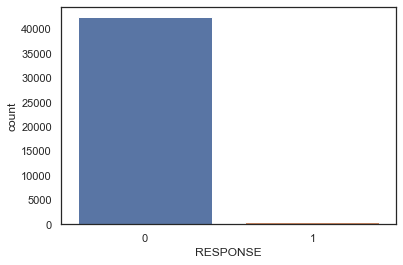

In [16]:
sns.countplot(x='RESPONSE', data=mailout_train)
plt.show()

In [17]:
# Reading main dataset replacing missing values
path = "{}/{}".format(path_raw, filename_mailout_train)
mailout_train_extended_na = load_dataset(path, 
                   delimiter=filename_demographics_delimiter, 
                   na_values=missing_dict_all,
                   reset_na = [],
                   visualize=False)

mailout_success_na = mailout_train_extended_na[mailout_train_extended_na['RESPONSE'] == 1]
mailout_unsuccess_na = mailout_train_extended_na[mailout_train_extended_na['RESPONSE'] == 0]
mailout_train_extended_na.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1763       2.0         1.0       8.0          NaN          NaN   
1  1771       1.0         4.0      13.0          NaN          NaN   
2  1776       1.0         1.0       9.0          NaN          NaN   
3  1460       2.0         1.0       6.0          NaN          NaN   
4  1783       2.0         1.0       9.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   8.0                 15.0   
1          NaN          NaN                  13.0                  1.0   
2          NaN          NaN                   7.0                  NaN   
3          NaN          NaN                   6.0                  4.0   
4          NaN          NaN                   9.0                 53.0   

   ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  \
0           NaN         0.0           1.0                        13.0   
1           NaN         0.0           2.0                         1.0   
2           NaN         0.0           NaN                         1.0   
3           NaN         0.0           2.0                         4.0   
4           NaN         0.0           1.0                        44.0   

   ANZ_TITEL  ARBEIT  BALLRAUM CAMEO_DEU_2015  CAMEO_DEUG_2015  \
0        NaN     3.0       5.0             5D              5.0   
1        NaN     2.0       5.0             5B              5.0   
2        NaN     4.0       1.0             2D              2.0   
3        NaN     4.0       2.0             2D              2.0   
4        NaN     3.0       4.0             7B              7.0   

   CAMEO_INTL_2015  CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  \
0             34.0            2.0                5.0        2.0        2.0   
1             32.0            2.0                2.0        2.0        2.0   
2             14.0            4.0                5.0        1.0        1.0   
3             14.0            2.0                5.0        2.0        2.0   
4             41.0            6.0                5.0        1.0        2.0   

   CJT_TYP_3  CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  \
0        5.0        5.0        5.0        5.0                NaN   
1        4.0        3.0        5.0        4.0                1.0   
2        5.0        5.0        5.0        5.0                NaN   
3        5.0        5.0        5.0        4.0                NaN   
4        5.0        5.0        5.0        5.0                NaN   

   D19_BANKEN_ANZ_24  D19_BANKEN_DATUM  D19_BANKEN_DIREKT  D19_BANKEN_GROSS  \
0                NaN               NaN                NaN               NaN   
1                1.0               5.0                NaN               NaN   
2                1.0               7.0                NaN               NaN   
3                NaN               NaN                NaN               NaN   
4                NaN               NaN                NaN               NaN   

   D19_BANKEN_LOKAL  D19_BANKEN_OFFLINE_DATUM  D19_BANKEN_ONLINE_DATUM  \
0               NaN                       NaN                      NaN   
1               3.0                       NaN                      NaN   
2               NaN                       NaN                      7.0   
3               NaN                       NaN                      NaN   
4               NaN                       NaN                      NaN   

   D19_BANKEN_ONLINE_QUOTE_12  D19_BANKEN_REST  D19_BEKLEIDUNG_GEH  \
0                         NaN              NaN                 NaN   
1                         NaN              NaN                 NaN   
2                         NaN              5.0                 NaN   
3                         NaN              NaN                 NaN   
4                         NaN              NaN                 5.0   

   D19_BEKLEIDUNG_REST  D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  \
0                  NaN 

In [18]:
# Display summary statistics for those individuals who responded to the mailout compaign
describe_mailout_success = mailout_success.describe(include='all').T
describe_mailout_unsuccess = mailout_unsuccess.describe(include='all').T
describe_mailout_success.sort_values('count')[:20]

count unique           top freq         mean  \
ALTER_KIND4                 1.0    NaN           NaN  NaN         10.0   
TITEL_KZ                    4.0    NaN           NaN  NaN          1.0   
ALTER_KIND3                 4.0    NaN           NaN  NaN         15.0   
ALTER_KIND2                10.0    NaN           NaN  NaN         13.2   
ALTER_KIND1                21.0    NaN           NaN  NaN    13.047619   
KK_KUNDENTYP              215.0    NaN           NaN  NaN     3.586047   
KBA05_BAUMAX              241.0    NaN           NaN  NaN     2.008299   
D19_LETZTER_KAUF_BRANCHE    322     30  D19_SONSTIGE   38          NaN   
GEBURTSJAHR               327.0    NaN           NaN  NaN  1944.712538   
AGER_TYP                  331.0    NaN           NaN  NaN     1.712991   
EXTSEL992                 342.0    NaN           NaN  NaN    43.909357   
ALTER_HH                  366.0    NaN           NaN  NaN     11.65847   
REGIOTYP                  410.0    NaN           NaN  NaN     4.268293   
KKK                       410.0    NaN           NaN  NaN     2.621951   
KBA05_AUTOQUOT            417.0    NaN           NaN  NaN     3.333333   
KBA05_KRSVAN              417.0    NaN           NaN  NaN     1.968825   
KBA05_ALTER1              417.0    NaN           NaN  NaN     1.717026   
KBA05_KRSOBER             417.0    NaN           NaN  NaN     2.019185   
KBA05_KRSKLEIN            417.0    NaN           NaN  NaN     2.038369   
KBA05_KRSHERST3           417.0    NaN           NaN  NaN      2.93765   

                                std     min     25%     50%     75%     max  
ALTER_KIND4                     NaN    10.0    10.0    10.0    10.0    10.0  
TITEL_KZ                        0.0     1.0     1.0     1.0     1.0     1.0  
ALTER_KIND3                3.366502    10.0    14.5    16.5    17.0    17.0  
ALTER_KIND2                3.457681     7.0   12.25    14.0    15.5    18.0  
ALTER_KIND1                4.005948     6.0    10.0    14.0    16.0    18.0  
KK_KUNDENTYP               1.617888     1.0     2.0     3.0     5.0     6.0  
KBA05_BAUMAX               1.562561     1.0     1.0     1.0     3.0     5.0  
D19_LETZTER_KAUF_BRANCHE        NaN     NaN     NaN     NaN     NaN     NaN  
GEBURTSJAHR                14.17712  1916.0  1933.5  1942.0  1955.0  2012.0  
AGER_TYP                   0.646047     1.0     1.0     2.0     2.0     3.0  
EXTSEL992                 14.210007     1.0    35.0    52.0    56.0    56.0  
ALTER_HH                   4.024006     5.0     9.0    10.0    14.0    21.0  
REGIOTYP                   1.915378     1.0     3.0     5.0     6.0     7.0  
KKK                        0.984479     1.0     2.0     3.0     3.0     4.0  
KBA05_AUTOQUOT             1.038521     1.0     3.0     3.0     4.0     5.0  
KBA05_KRSVAN               0.542862     1.0     2.0     2.0     2.0     3.0  
KBA05_ALTER1               1.081542     0.0     1.0     2.0     2.0     4.0  
KBA05_KRSOBER              0.588035     1.0     2.0     2.0     2.0     3.0  
KBA05_KRSKLEIN             0.599251     1.0     2.0     2.0     2.0     3.0  
KBA05_KRSHERST3            1.114134     1.0     2.0     3.0     4.0     5.0

Most columns are categorial but encoded to integery values, yet describe() see them as integer thus no statistics on unique values, top, frequence are computed. 

<a id='missing_values'></a>
# Step 2: Handling Missing data

We are 3 types of missing values:

1. Where data is truly absent in the dataset - identified with np.nan

2. Where data is marked with label **'unknown'** in the attributes excel file
   - During data loading, we immediately convert such values to np.nan and we will impute them later
   
3. Where data are marked with labels below in the attributes file
   - 'no transactions known', 
   - 'no transaction known', 
   - 'no Online-transactions'
   
   These kind values of values appear in transactions columns, example how many online transactions was made. We  know that 0 online transactions were made, the value is not missing. We do not want to impute these values, but we do need to observe the distribution and statistal relevance of these columns if 0 values are excluded 

<a id='missing_values_columns'></a>
### 2.1 Investigate which columns to drop due to too many missing values

First lets start by comparing the missing values in the full demographics dataset to missing data in the mailout success dataset. We don't want to drop columns that have lots of missing data on first glance, but are an important column for mailout success predictions

#### 2.1.1 - Investigate missing data in demographics of the full population vs individuals who responded to mailout campaign

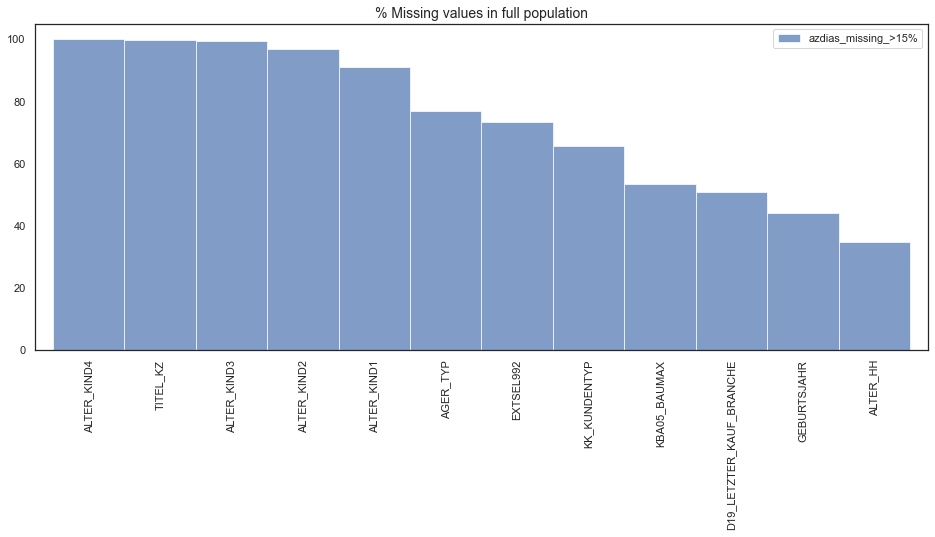

In [19]:
missing_columns_azdias = round(azdias.isna().mean() * 100, 2).sort_values(ascending=False)
missing_columns_azdias = missing_columns_azdias[missing_columns_azdias > 30]
df_missing_values_azdias = pd.DataFrame(missing_columns_azdias,
                                        columns=['azdias_missing_>15%'],
                                        index=missing_columns_azdias.index)

df_missing_values_azdias.plot(kind="bar", 
                           figsize=(16, 6), 
                           title='% Missing values in full population',
                           width=1,
                           alpha=0.7)

plt.title('% Missing values in full population', fontsize=14)
plt.show()

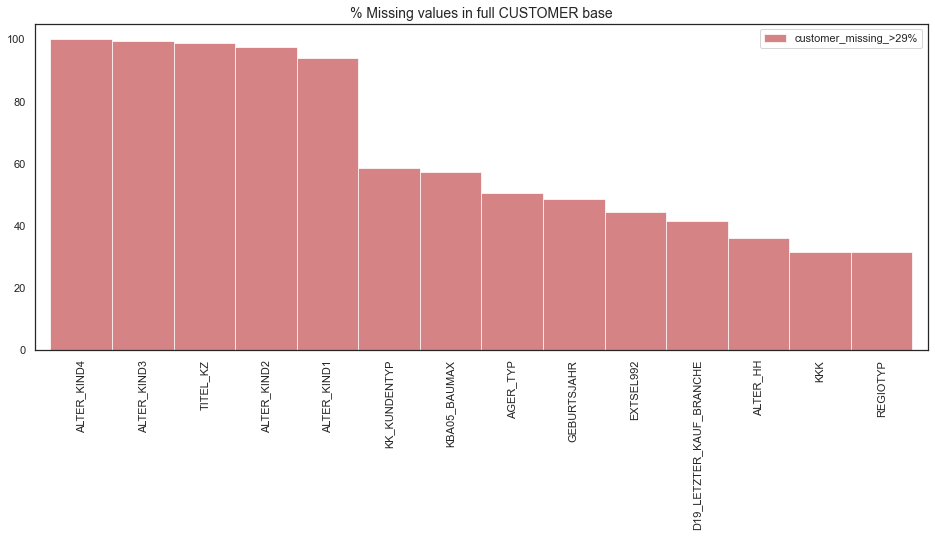

In [20]:
# Missing data for those indidivuals who responded to mailout campaign
missing_columns_customer = round(customers.isna().mean() * 100, 2).sort_values(ascending=False)
missing_columns_customer = missing_columns_customer[missing_columns_customer > 30]
df_missing_values_customer = pd.DataFrame(missing_columns_customer, 
                                          columns=['customer_missing_>29%'],
                                          index=missing_columns_customer.index)

df_missing_values_customer.plot(kind="bar", 
                                figsize=(16,6), 
                                width=1,
                                alpha=0.7,
                                color='r')

plt.title('% Missing values in full CUSTOMER base', fontsize=14)
plt.show()

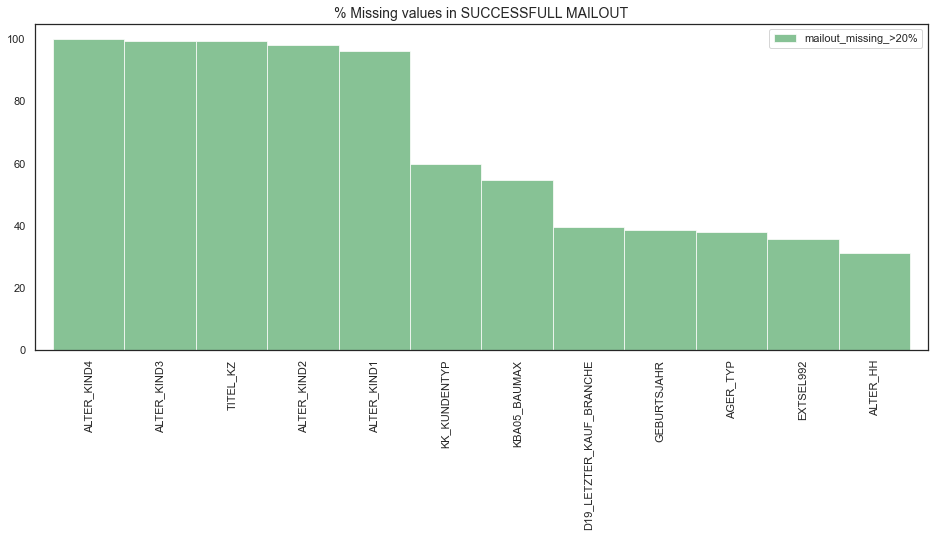

In [21]:
# Missing data for those indidivuals who responded to mailout campaign
missing_columns_mailout = round(mailout_success.isna().mean() * 100, 2).sort_values(ascending=False)
missing_columns_mailout = missing_columns_mailout[missing_columns_mailout > 30]
df_missing_values_mailout = pd.DataFrame(missing_columns_mailout, 
                                         columns=['mailout_missing_>20%'],
                                         index=missing_columns_mailout.index)

df_missing_values_mailout.plot(kind="bar", 
                                figsize=(16,6), 
                                width=1,
                                alpha=0.7,
                                color='g')

plt.title('% Missing values in SUCCESSFULL MAILOUT', fontsize=14)
plt.show()

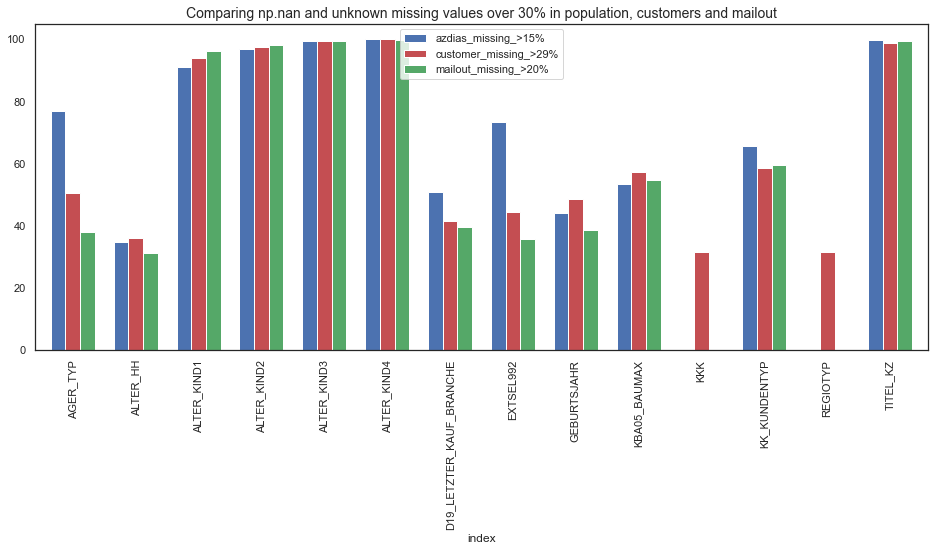

In [22]:
missing_values = df_missing_values_azdias.merge(df_missing_values_customer, 
                                                how='outer', 
                                                left_index=True, 
                                                right_index=True)

missing_values = missing_values.merge(df_missing_values_mailout, 
                                                how='outer', 
                                                left_index=True, 
                                                right_index=True)
missing_values.reset_index(inplace=True)

missing_values.plot(kind='bar', 
                    x='index', 
                    figsize=(16,6),
                    width=0.7,
#                     alpha=0.8,
                    color=['b', 'r', 'g'])  

plt.title('Comparing np.nan and unknown missing values over 30% in population, customers and mailout', fontsize=14)
plt.show()

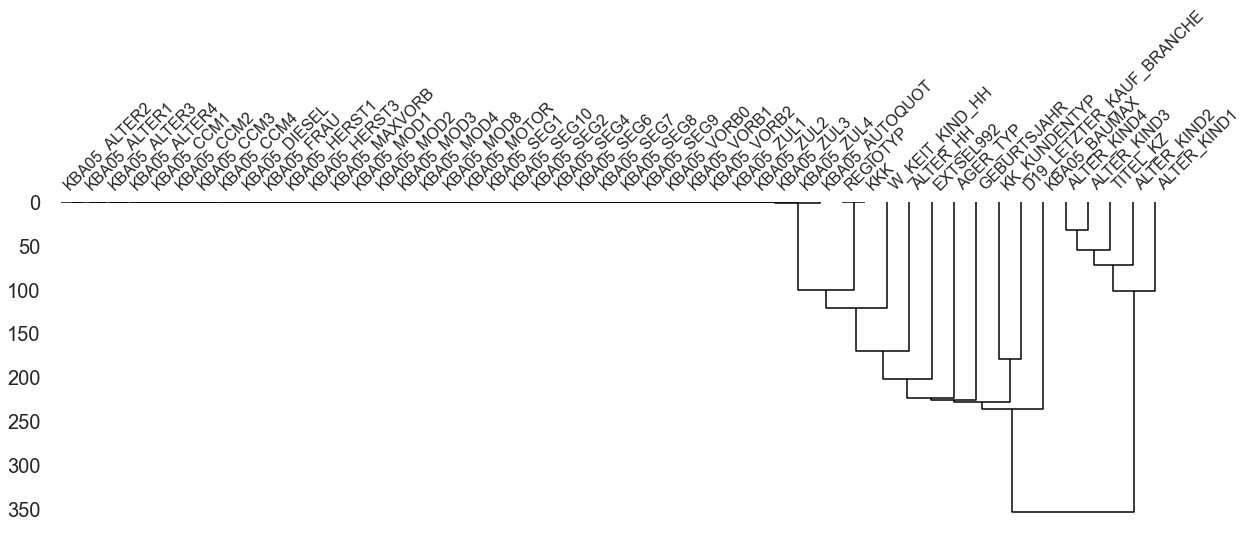

In [23]:
# Investigate deeper the relationships in the amount of missing data in each column
# The top line shows the highest relationships and correlations
msno.dendrogram(customers, filter="bottom", n=50, figsize=(20,6));

When comparing above plots we can see that generally, there seems to be more missing data in the overall customer dataset than in the general population. The mailout training dataset have least amount of missing data which means we need to very careful of bias when training the prediction model.

We can also observe that columns starting with 'KBA05' all belonging to Microcell (RR3_ID), when one of the fields are missing, all are missing. In the customer dataset 25% of these fields are missing, whilst in full population only 15% is missing. When training a machine learning imputer, it's enough data present to build a decent imputing, so I think this is ok

#### 2.1.2 - Repeat 2.1.1 but this time we look at all missing values not just np.nan and unknown data

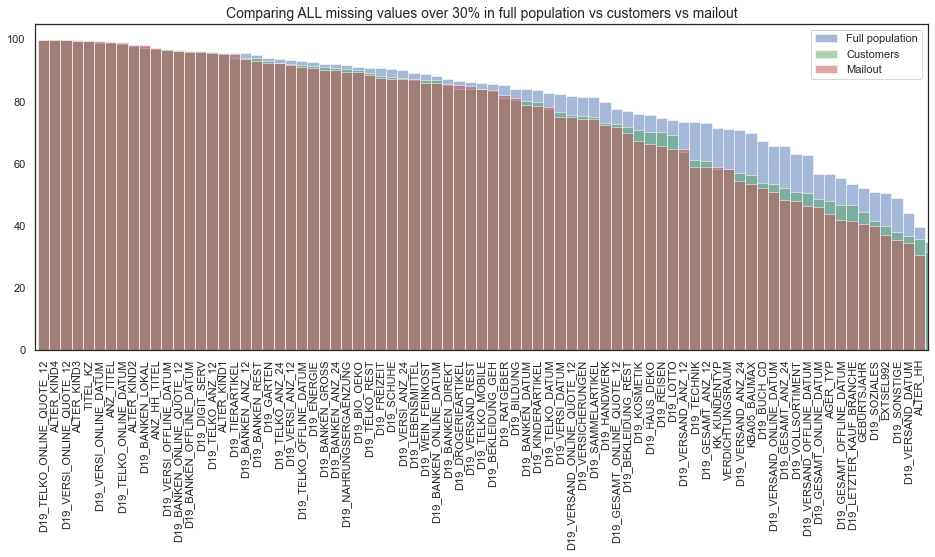

In [24]:

missing_columns_azdias_na = round(azdias_extended_na.isna().mean() * 100, 2).sort_values(ascending=False)
missing_columns_azdias_na[missing_columns_azdias_na > 30].plot(kind="bar", 
                                                               figsize=(16, 6), 
                                                               title='% ALL missing values in full population',
                                                               width=1,
                                                               alpha=0.5,
                                                               color='b',
                                                               legend=True)


missing_columns_customers_na = round(customers_extended_na.isna().mean() * 100, 2).sort_values(ascending=False)
missing_columns_customers_na[missing_columns_customers_na > 30].plot(kind="bar", 
                                                                 figsize=(16,6), 
                                                                 title='% ALL missing values in customers',
                                                                 width=1,
                                                                 alpha=0.5,
                                                                 color='g',
                                                                 legend='customers')

missing_columns_mailout_na = round(mailout_train_extended_na.isna().mean() * 100, 2).sort_values(ascending=False)
missing_columns_mailout_na[missing_columns_mailout_na > 30].plot(kind="bar", 
                                                                 figsize=(16,6), 
                                                                 title='% ALL missing values in mailout success',
                                                                 width=1,
                                                                 alpha=0.5,
                                                                 color='r',
                                                                 legend='mailout')

plt.title('Comparing ALL missing values over 30% in full population vs customers vs mailout', fontsize=14)
plt.legend(['Full population', 'Customers', 'Mailout'])

plt.show()

We can observe in above 2 plots, that a lot of 0 values are present in transaction columns starting with 'D19' which are househould and grid level columns

We also observe that, there are overall much less missing values in the mailout success dataset

<AxesSubplot:>

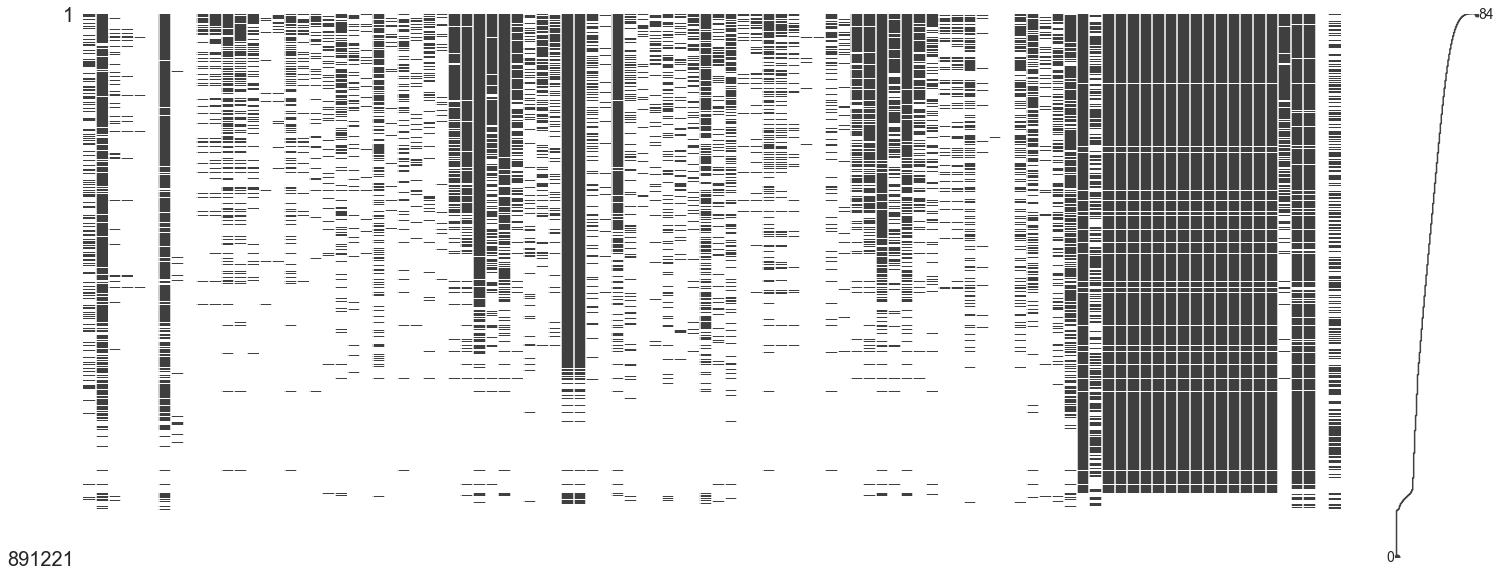

In [25]:
# Where in the dataset do missing values appear? Are there relationships between missing data in columns ?
msno.matrix(azdias_extended_na, filter="bottom", n=100, sort="descending")

We observe missing data are present all over the dataset, it's overall really messy indeed!
Towards the end of the dataset especially some rows appear to have almost no data at all.
Some columns are totally empty too

In [26]:
# Build an enhanced feature summary, as describe function does not show unique values for numeric columns
# Merge together feature levels, descriptions and information from the data
feature_summary = build_feature_summary(azdias_extended_na, 
                                        levels, 
                                        feature_description, 
                                        missing_columns_azdias_na)
feature_summary[5:9]

Attribute  distinct_values  \
100            EXTSEL992               56   
353     VERDICHTUNGSRAUM               45   
17        CAMEO_DEU_2015               44   
307  LP_LEBENSPHASE_FEIN               40   

                                                                                                                                                                                                                                                                                                                                    unique_values  \
100  [nan, 14.0, 31.0, 20.0, 56.0, 53.0, 27.0, 54.0, 6.0, 25.0, 48.0, 55.0, 36.0, 34.0, 35.0, 18.0, 38.0, 32.0, 29.0, 41.0, 43.0, 22.0, 19.0, 24.0, 23.0, 8.0, 21.0, 37.0, 7.0, 3.0, 39.0, 12.0, 15.0, 17.0, 4.0, 9.0, 44.0, 50.0, 13.0, 33.0, 42.0, 49.0, 1.0, 30.0, 10.0, 45.0, 26.0, 16.0, 28.0, 47.0, 2.0, 46.0, 11.0, 40.0, 51.0, 52.0, 5.0]   
353                                                                    [nan, 1.0, 35.0, 3.0, 7.0, 23.0, 4.0, 8.0, 13.0, 16.0, 25.0, 5.0, 21.0, 6.0, 15.0, 32.0, 42.0, 31.0, 11.0, 33.0, 22.0, 30.0, 18.0, 12.0, 27.0, 2.0, 9.0, 28.0, 10.0, 14.0, 20.0, 17.0, 43.0, 19.0, 24.0, 34.0, 40.0, 39.0, 29.0, 26.0, 44.0, 45.0, 37.0, 36.0, 41.0, 38.0]   
17                                                                                                                                                          [nan, 8A, 4C, 2A, 6B, 8C, 4A, 2D, 1A, 1E, 9D, 5C, 8B, 7A, 5D, 9E, 9B, 1B, 3D, 4E, 4B, 3C, 5A, 7B, 9A, 6D, 6E, 2C, 7C, 9C, 7D, 5E, 1D, 8D, 6C, 6A, 5B, 4D, 3A, 2B, 7E, 3B, 6F, 5F, 1C]   
307                                                                                                  [15.0, 21.0, 3.0, nan, 32.0, 8.0, 2.0, 5.0, 10.0, 4.0, 6.0, 23.0, 12.0, 20.0, 1.0, 11.0, 25.0, 13.0, 7.0, 18.0, 31.0, 19.0, 38.0, 35.0, 30.0, 22.0, 14.0, 33.0, 29.0, 24.0, 28.0, 37.0, 26.0, 39.0, 27.0, 36.0, 9.0, 34.0, 40.0, 16.0, 17.0]   

      Information level                Description  \
100                 NaN                        NaN   
353                 NaN                        NaN   
17   Microcell (RR4_ID)  CAMEO_4.0: specific group   
307              Person             lifestage fine   

                                                                 Additional notes  \
100                                                                           NaN   
353                                                                           NaN   
17   New German CAMEO Typology established together with Call Credit in late 2015   
307                                            modelled on different AZ DIAS data   

                                      feature_description  %missing_values  
100                                                  None            73.40  
353                                    population density            52.29  
17   CAMEO classification 2015 - detailled classification            11.15  
307                                       lifestage fine             10.95

We observer from above table that LNR contains only unique values and are definetely a key. 
Lets convert it to index field

We can clearly observe the numeric fields, as the have the most unique values

In [27]:
# What is the average missing values by information level
feature_summary.groupby('Information level')['%missing_values'].mean()

Information level
125m x 125m Grid      85.628485
Building              20.241111
Community             10.916667
Household             66.628889
Microcell (RR3_ID)    17.268333
Microcell (RR4_ID)    15.012727
PLZ8                  11.945089
Person                 6.037805
Postcode              10.520000
RR1_ID                12.294000
Name: %missing_values, dtype: float64

We notice an immediate problem with the **GRID** and **HOUSEHOLD** fields as they don't not seem to contain a lot of information, (85% and 66% irrespectively), when we combine unknown, null and 0 transactions data.

Let's deep dive into these two fields

In [28]:
numerical_columns = ['KBA13_ANZAHL_PKW', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_STATISTISCHE_HAUSHALTE', 'GEBURTSJAHR', 
                    'EXTSEL992', 'VERDICHTUNGSRAUM', 'EINGEZOGENAM_HH_JAHR', 'MIN_GEBAEUDEJAHR', 'ANZ_PERSONEN',
                    'EINGEFUEGT_AM', 'ANZ_KINDER', 'ANZ_HH_TITEL']

In [29]:
# LNR looks like a count of key, so I add it an index instead
azdias.set_index('LNR', inplace=True, verify_integrity=True)
azdias_extended_na.set_index('LNR', inplace=True, verify_integrity=True)
azdias

AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  ALTER_KIND3  \
LNR                                                                             
910215       NaN         NaN       NaN          NaN          NaN          NaN   
910220       NaN         9.0       NaN          NaN          NaN          NaN   
910225       NaN         9.0      17.0          NaN          NaN          NaN   
910226       2.0         1.0      13.0          NaN          NaN          NaN   
910241       NaN         1.0      20.0          NaN          NaN          NaN   
...          ...         ...       ...          ...          ...          ...   
825761       NaN         5.0      17.0          NaN          NaN          NaN   
825771       NaN         9.0      16.0          NaN          NaN          NaN   
825772       NaN         1.0      17.0          NaN          NaN          NaN   
825776       NaN         9.0       NaN         17.0          NaN          NaN   
825787       NaN         1.0       NaN          NaN          NaN          NaN   

        ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  \
LNR                                                                            
910215          NaN                   NaN                  0.0           0.0   
910220          NaN                  21.0                 11.0           0.0   
910225          NaN                  17.0                 10.0           0.0   
910226          NaN                  13.0                  1.0           0.0   
910241          NaN                  14.0                  3.0           0.0   
...             ...                   ...                  ...           ...   
825761          NaN                  17.0                 15.0           0.0   
825771          NaN                  16.0                 11.0           0.0   
825772          NaN                  17.0                  3.0           0.0   
825776          NaN                  20.0                  7.0           0.0   
825787          NaN                   NaN                 10.0           0.0   

        ANZ_KINDER  ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL  \
LNR                                                                       
910215         NaN           0.0                         NaN        0.0   
910220         0.0           2.0                        12.0        0.0   
910225         0.0           1.0                         7.0        0.0   
910226         0.0           0.0                         2.0        0.0   
910241         0.0           4.0                         3.0        0.0   
...            ...           ...                         ...        ...   
825761         0.0           1.0                        11.0        0.0   
825771         0.0           1.0                        11.0        0.0   
825772         0.0           0.0                         3.0        0.0   
825776         1.0           1.0                         5.0        0.0   
825787         0.0           1.0                         5.0        0.0   

        ARBEIT  BALLRAUM CAMEO_DEU_2015  CAMEO_DEUG_2015  CAMEO_INTL_2015  \
LNR                                                                         
910215     NaN       NaN            NaN              NaN              NaN   
910220     3.0       6.0             8A              8.0             51.0   
910225     3.0       2.0             4C              4.0             24.0   
910226     2.0       4.0             2A              2.0             12.0   
910241     4.0       2.0             6B              6.0             43.0   
...        ...       ...            ...              ...              ...   
825761     NaN       6.0             7A              7.0             41.0   
825771     4.0       7.0             9D              9.0             51.0   
825772     2.0       5.0             4C              4.0             24.0   
825776     4.0       2.0             9D              9.0             51.0   
825787     3.

In [30]:
# group column names by level
grid_columns = feature_summary[feature_summary['Information level'] == '125m x 125m Grid']['Attribute'].to_list()
household_columns = feature_summary[feature_summary['Information level'] == 'Household']['Attribute'].to_list()
building_columns = feature_summary[feature_summary['Information level'] == 'Building']['Attribute'].to_list()
community_columns = feature_summary[feature_summary['Information level'] == 'Community']['Attribute'].to_list()
microcell3_columns = feature_summary[feature_summary['Information level'] == 'Microcell (RR3_ID)']['Attribute'].to_list()
microcell4_columns = feature_summary[feature_summary['Information level'] == 'Microcell (RR4_ID)']['Attribute'].to_list()
microcell1_columns = feature_summary[feature_summary['Information level'] == 'RR1_ID']['Attribute'].to_list()
plz8_columns = feature_summary[feature_summary['Information level'] == 'PLZ8']['Attribute'].to_list()

In [31]:
# write grid columns as csv file to data/config folder for re-use later in clean routine
data_dir = path_config
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
pd.DataFrame(grid_columns).to_csv(filename_gridcolumns, header=None, index=False)

<a id='missing_values_household'></a>
#### 2.1.3. Household column analysis

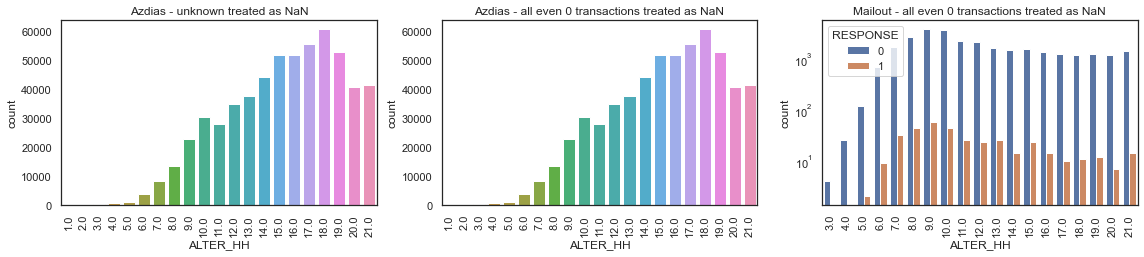

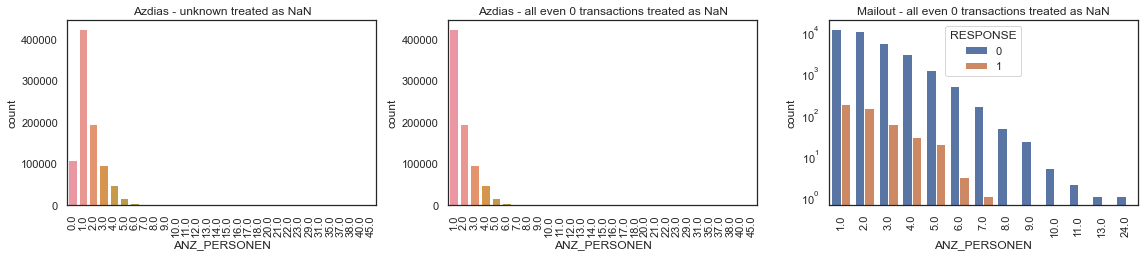

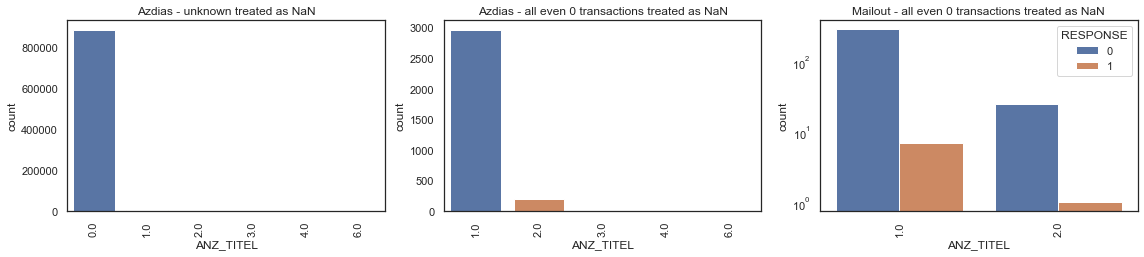

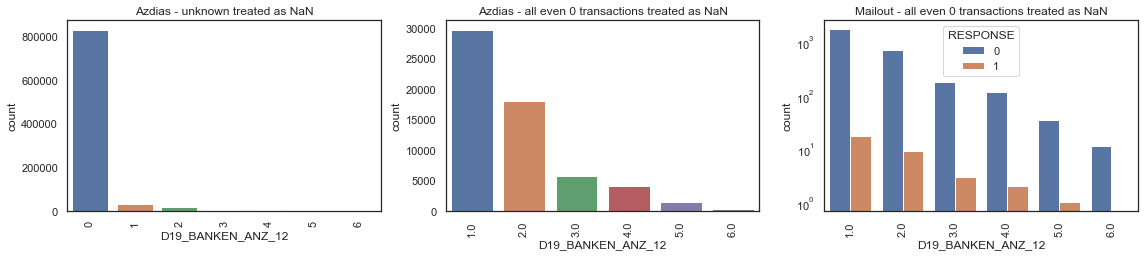

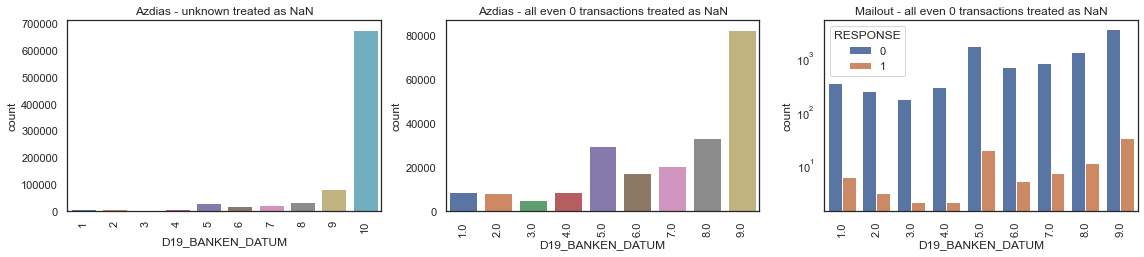

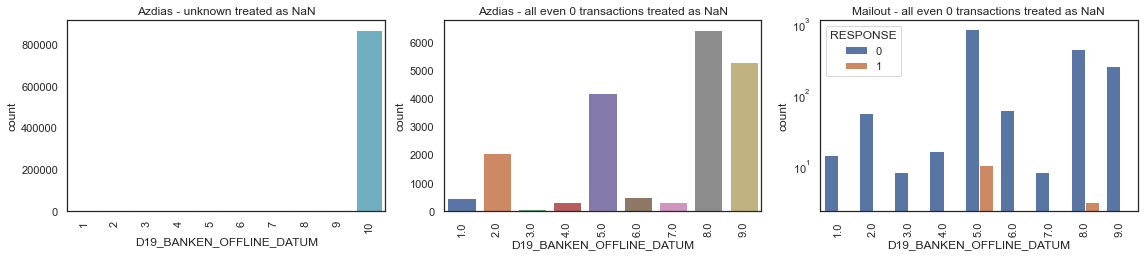

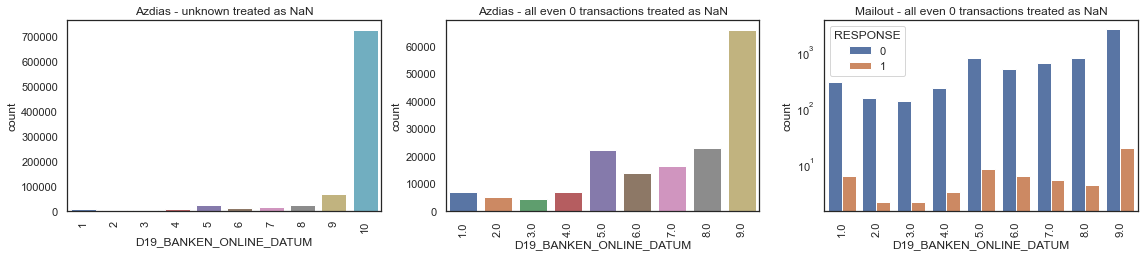

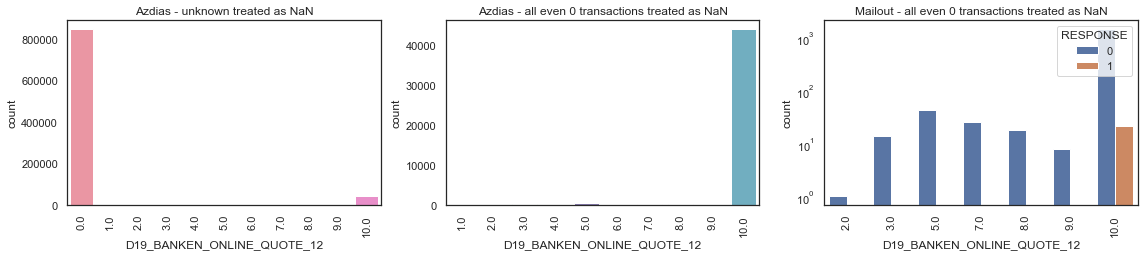

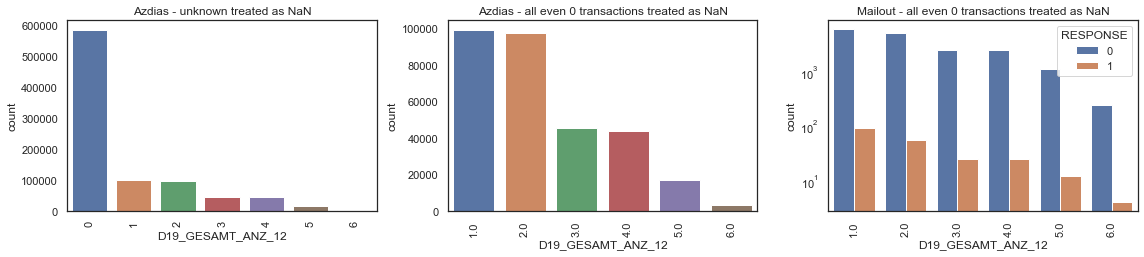

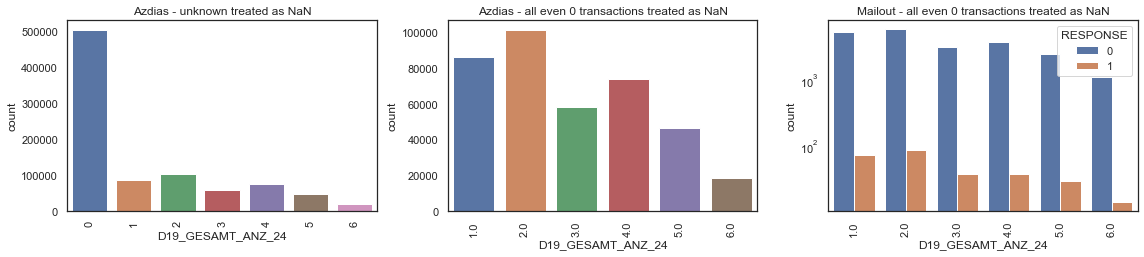

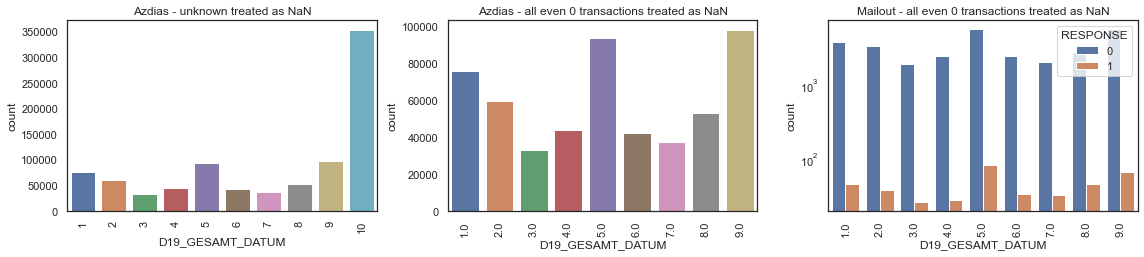

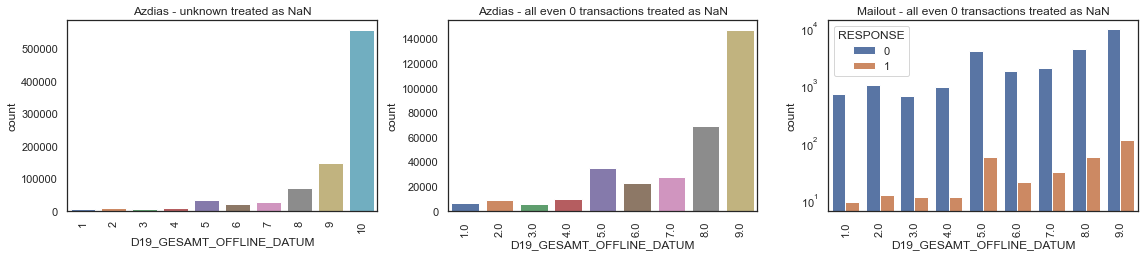

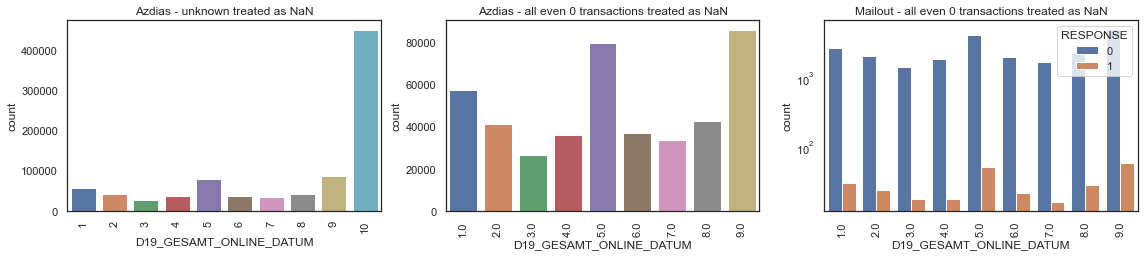

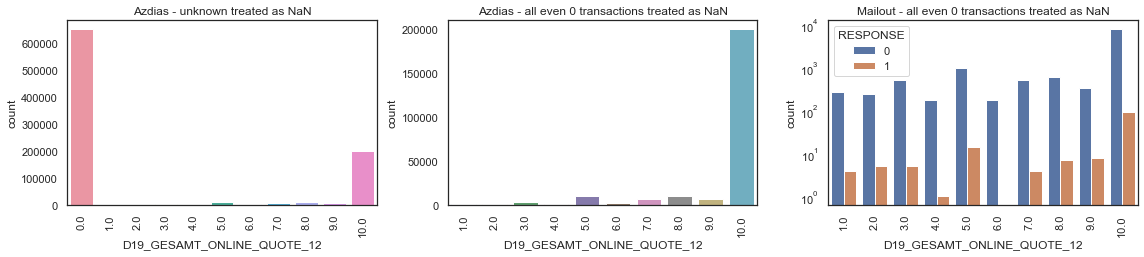

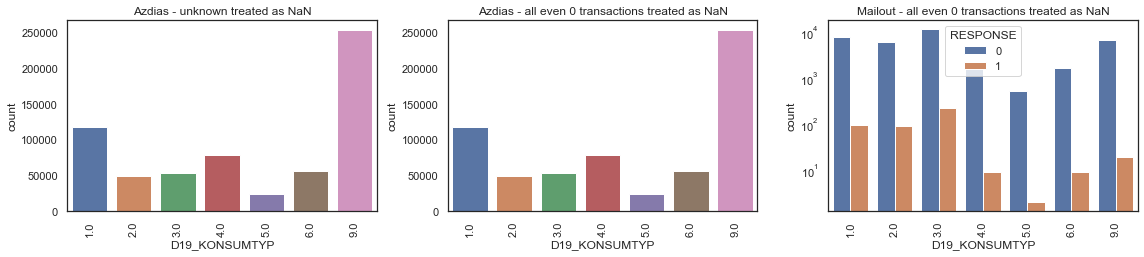

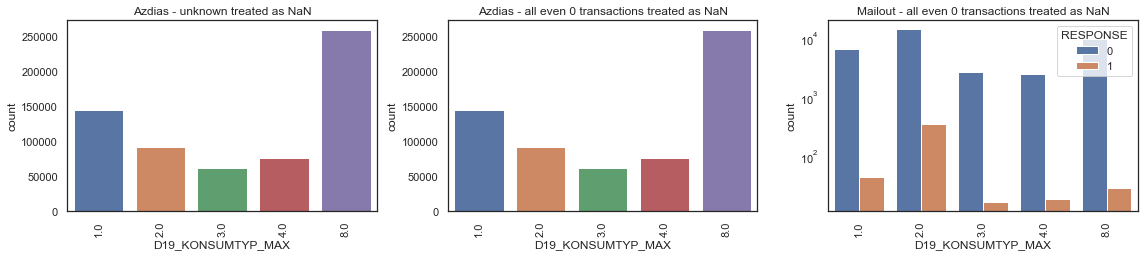

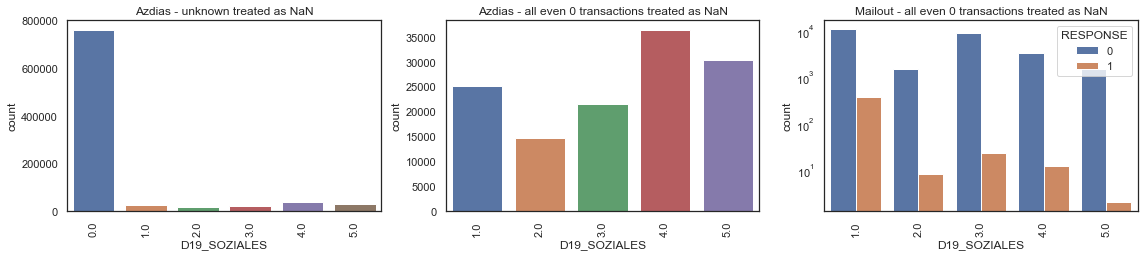

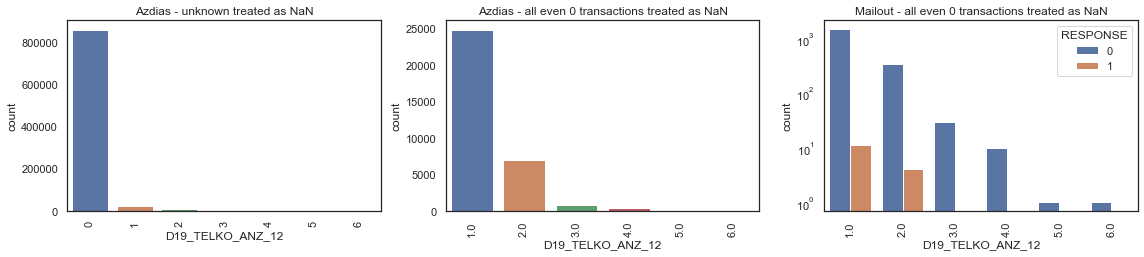

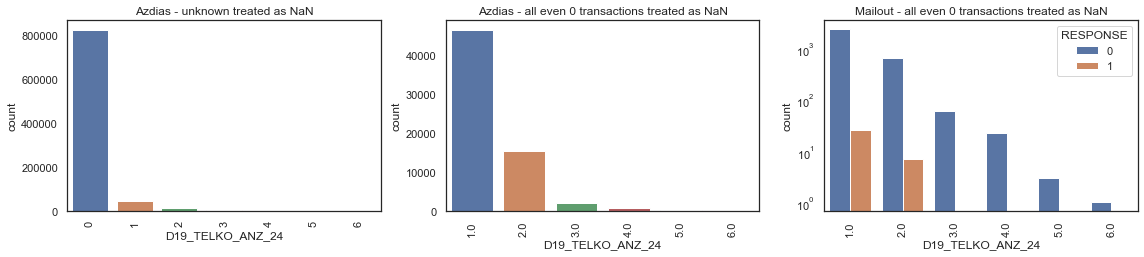

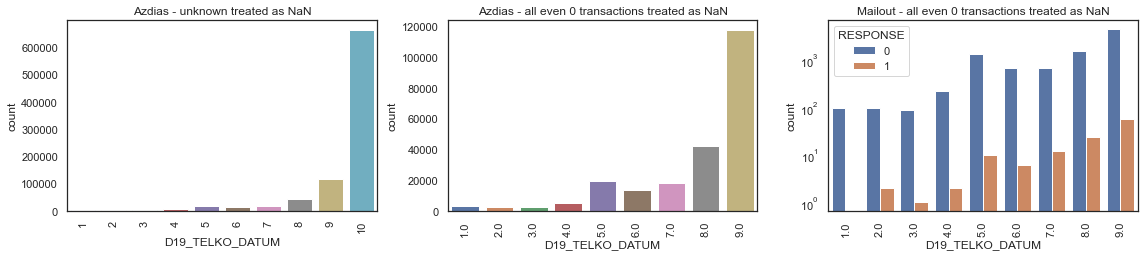

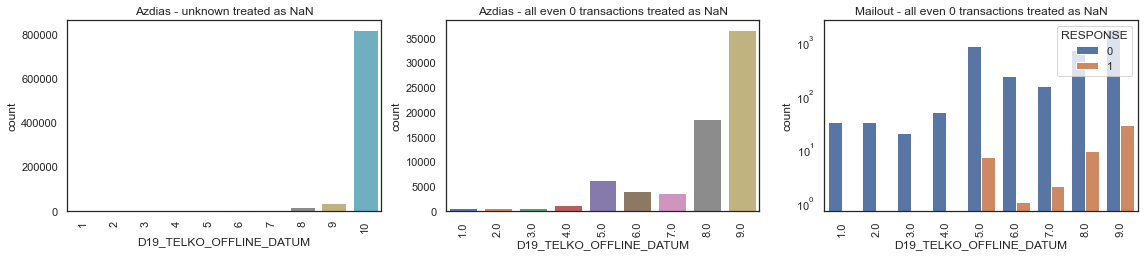

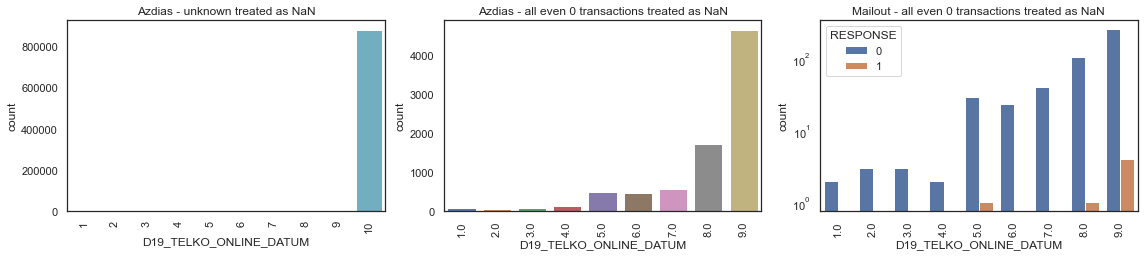

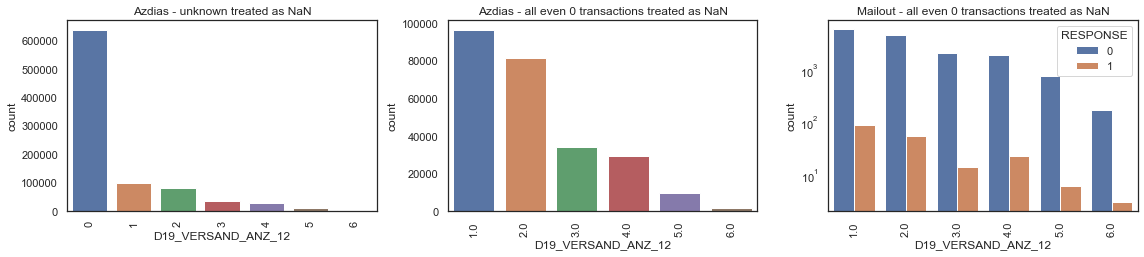

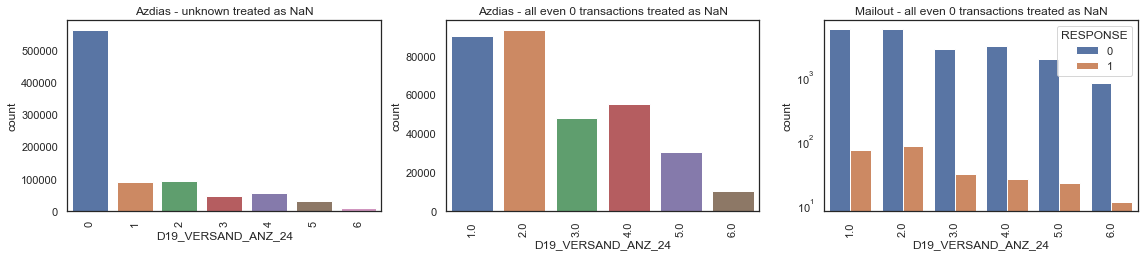

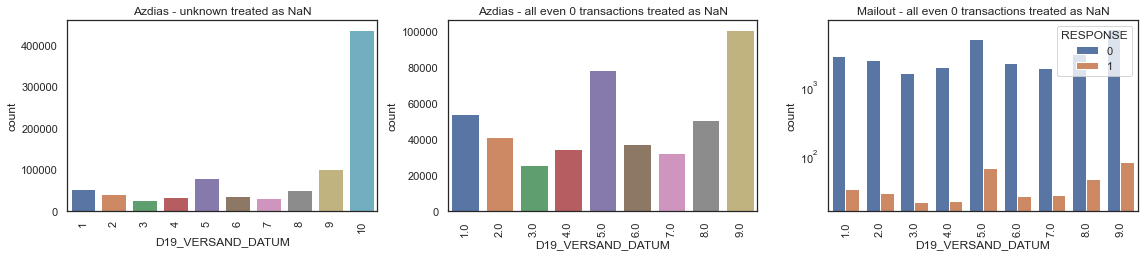

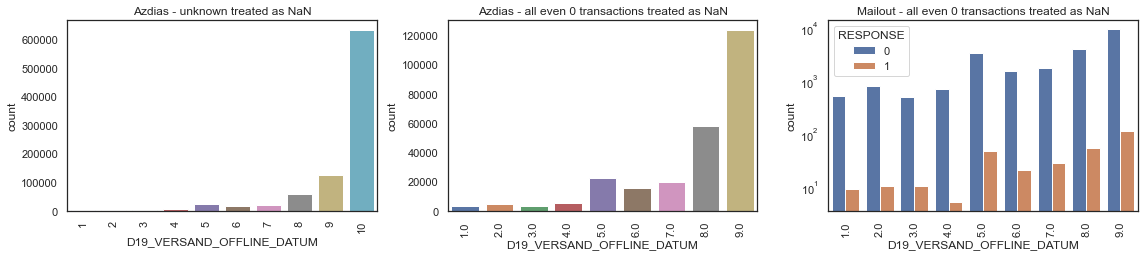

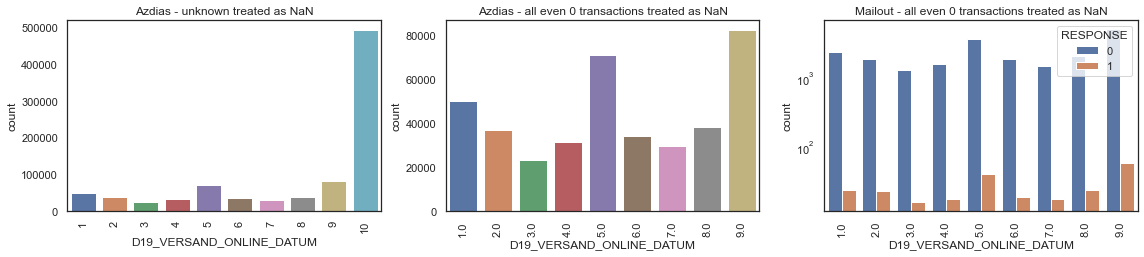

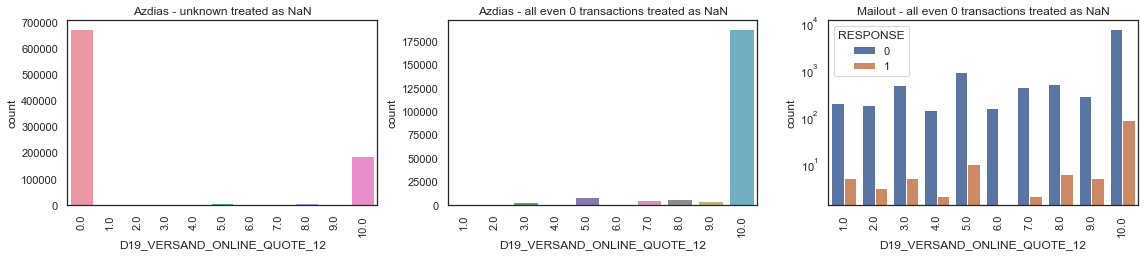

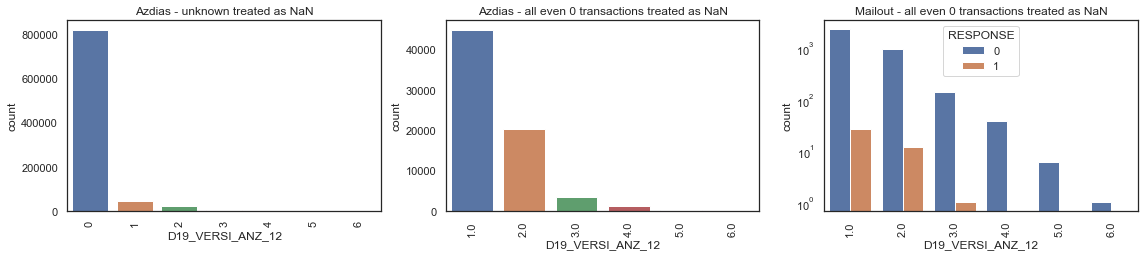

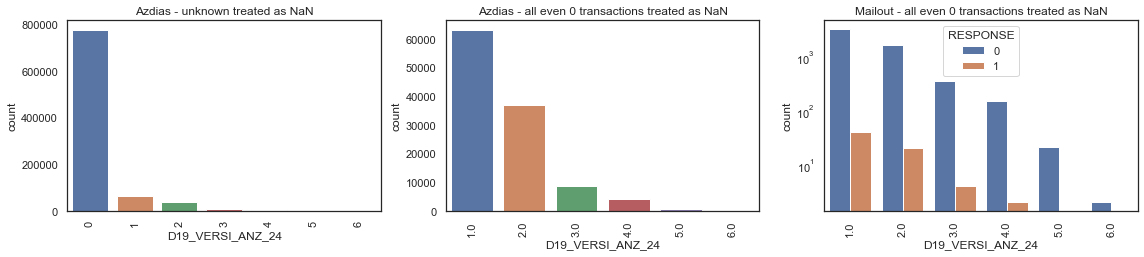

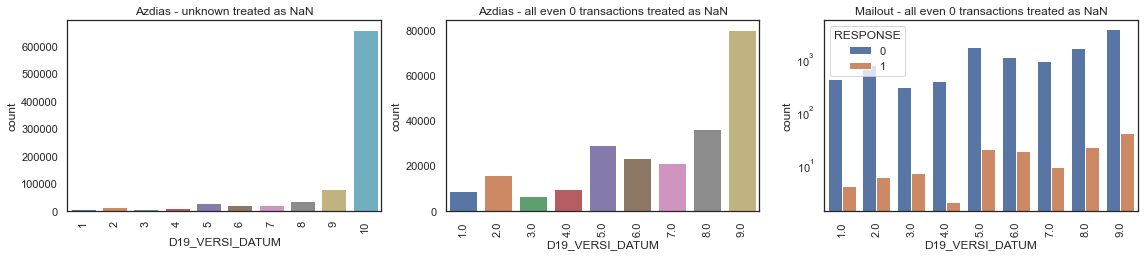

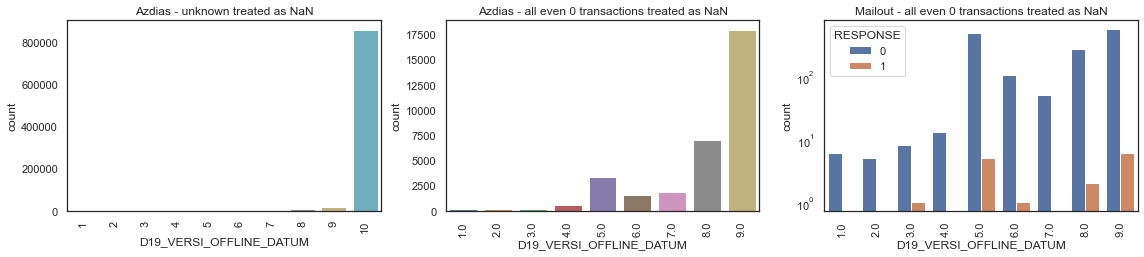

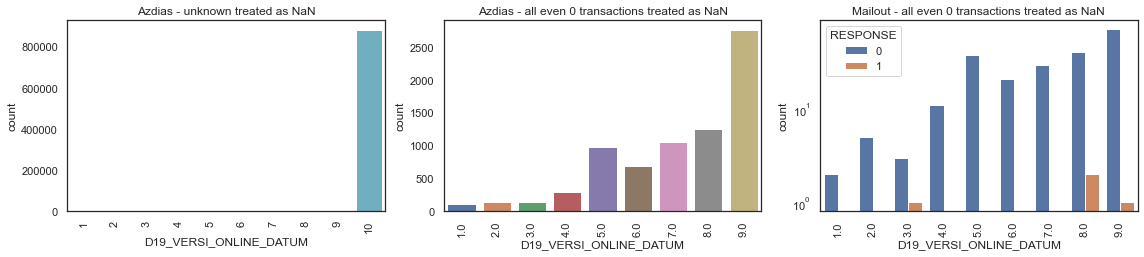

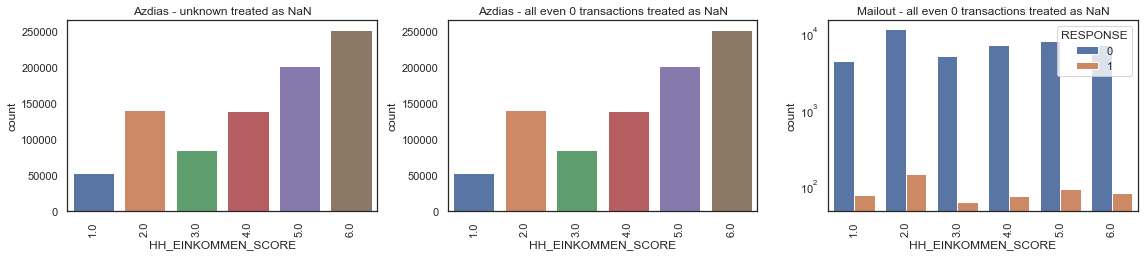

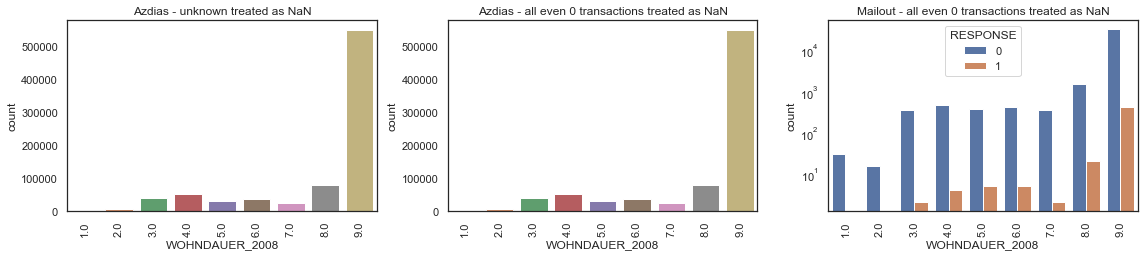

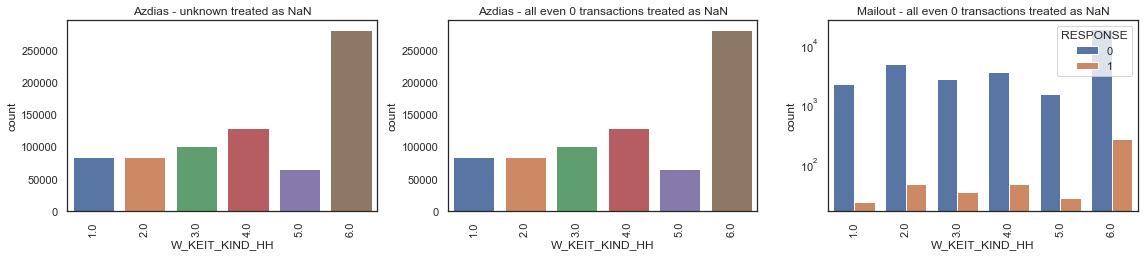

In [32]:
titles = ['Azdias - unknown treated as NaN', 
          'Azdias - all even 0 transactions treated as NaN', 
          'Mailout - all even 0 transactions treated as NaN']

compare_distributions_countplot_3by3(df1=azdias,
                                    df2=azdias_extended_na, 
                                    df3=mailout_train_extended_na,
                                    titles=titles,
                                    col=sorted(household_columns),
                                    logscale=True)

##### Observations from Household columns:

Amount of online transactions:

- D19_BANKEN_ONLINE_QUOTE_12: Those who responded all have 100% online transactions - seems important
- D19_VERSAND_ONLINE_QUOTE_12: Seems to be slight higher trend from 50-100% online transactions, with a high peak at 100%
- D19_GESAMT_ONLINE_QUOTE_12: Those who have responded have a good balance between online and offline transactions, highest peak at 100%

    Overall we can conclude those who have responded do more online transactions

Transaction analysis - activity low to high:

- D19_GESAMT_ANZ_12 AND 24: Highly correlated, keeping either would be enough. Generally the poplution and those responded have low activity in last 12 or 24 months the the TOTAL POOL
- D19_VERSTAND_ANZ_12 AND 24: distibutiones betwen 12 or 24 months looks quite different. Seems like 12 months curve are more distinguished some peaks in the bars for those who responded


Transactions analysis - when did we last buy:

- D19_GESAMT_DATUM, *OFFLINE_DATUM, *ONLINE_DATUM seems to follow the same distribution for population vs those who responded. Later 2 fields are a breakdown of the first. ONLINE seems to be a more popular choice overall and control the overall distribution
- D19_VERSAND_DATUM, *OFFLINE_DATUM, *ONLINE_DATUM seems to follow the same distribution for population vs those who responded. Later 2 fields are a breakdown of the first. ONLINE seems to be a more popular choice. OFFLINE seems have higher transactions > 1 year ago. Overall and control the overall distribution, same patterns as GESAMT
- D19_VERSI_DATUM seems to be higher volume >1 years agao


- D19_KONSUMTYP and D19_KONSUMTYP_MAX both indicate those who responded have high counts in the values. KONSUMTYP_MAX = 2 seems important, and same with KONSUMTYP = 3
- D19_SOZIALES = 1 seems to have very high count of those who reponded compared to rest of bars. Distribution of those who responded vs not are quite different
- ALTER_HH: Seems more younger families in Germany overall althought those who responded seems older
- ANZ_PERSONEN: Number of adult people in households in generally below 5, same for those responded
- HH_EINKOMMEN_SCORE: Seems like all income levels responded, with the slightest of peak in 'very high'
- WOHNDAUER_2008: Seems like those who responded are longer in their residence, which seems to suggest they settled. Biggest peak at residence > 10 years
- W_KEIT_KIND_HH: Most of those who have responded don't have children living with them

<a id='missing_values_grid'></a>
#### 2.1.4 GRID column analysis

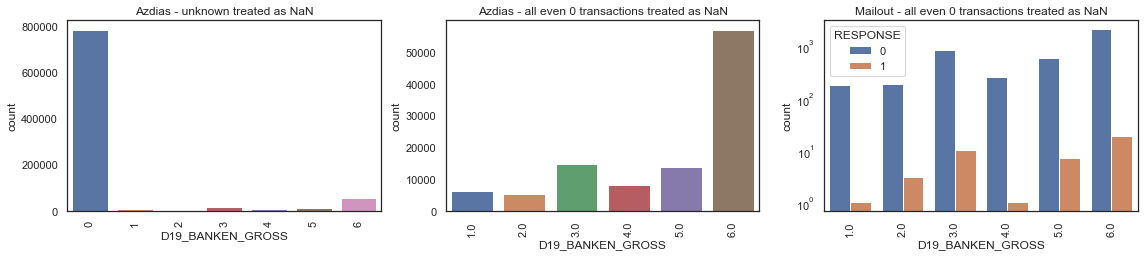

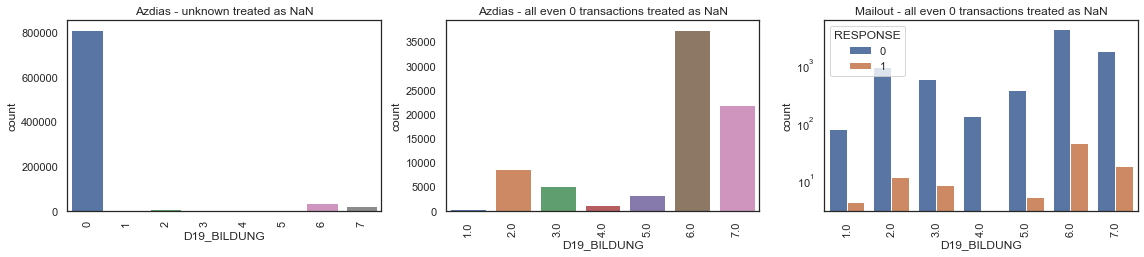

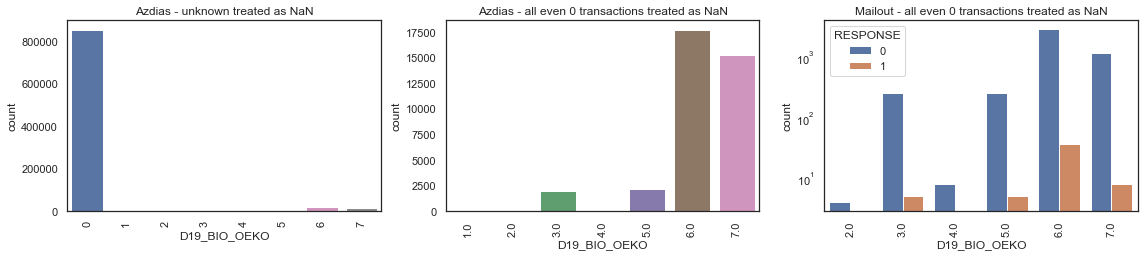

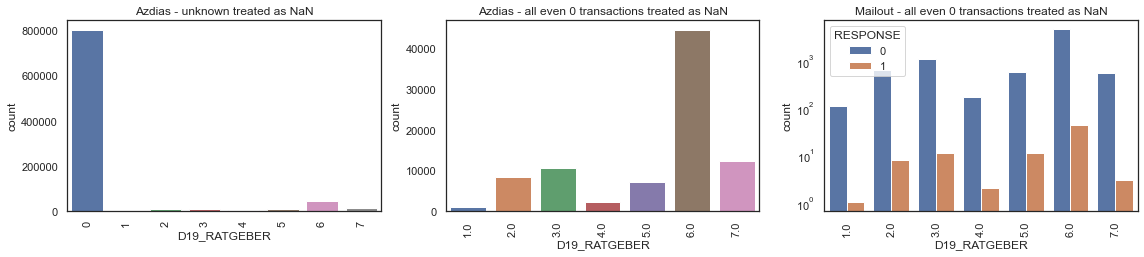

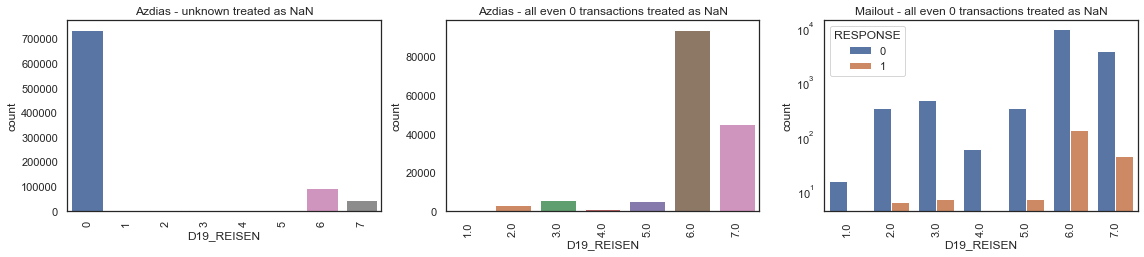

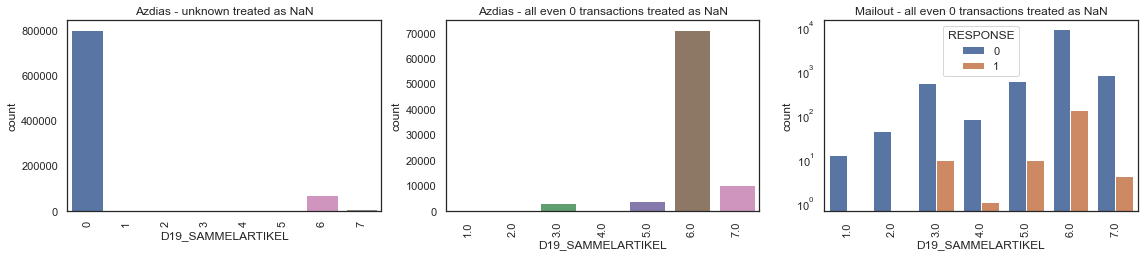

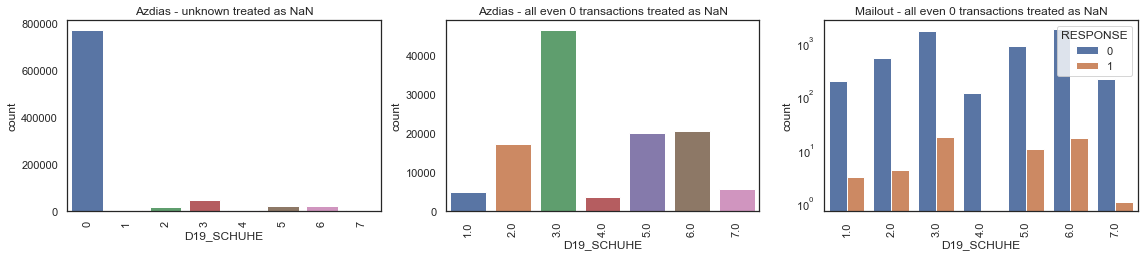

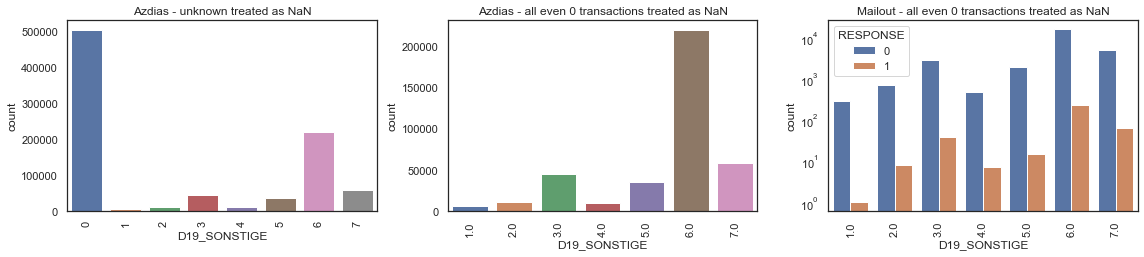

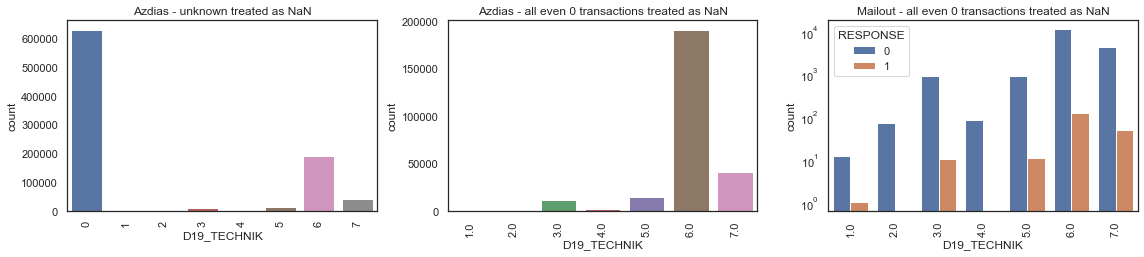

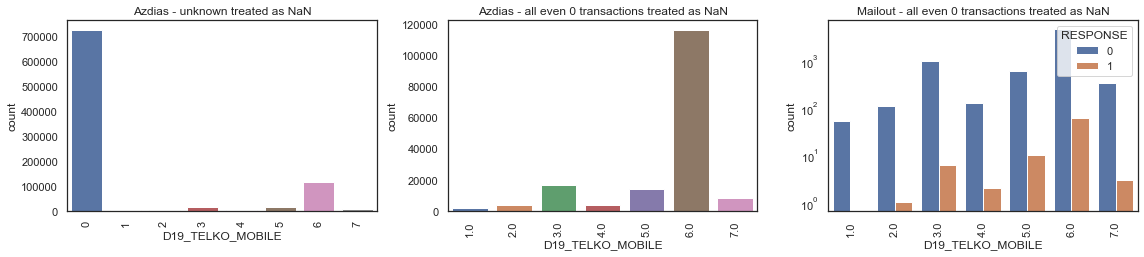

In [33]:
titles = ['Azdias - unknown treated as NaN', 
          'Azdias - all even 0 transactions treated as NaN', 
          'Mailout - all even 0 transactions treated as NaN']

compare_distributions_countplot_3by3(df1=azdias,
                                    df2=azdias_extended_na, 
                                    df3=mailout_train_extended_na,
                                    titles=titles,
                                    col=grid_columns[-10:],
                                    logscale=True)

When we treat 0 transactional data as NaN means it gets droppped from charts above, we can observe trends better.

We can observe that in most categories values 6 and 7 are dominating, which means transactions are known > 24 months. Means low activity. We also notice y-axis goes up to 100,000 out of 800,000 which means a lot of missing data is present meaning no transactions

#### 2.1.5 OTHER column analysis

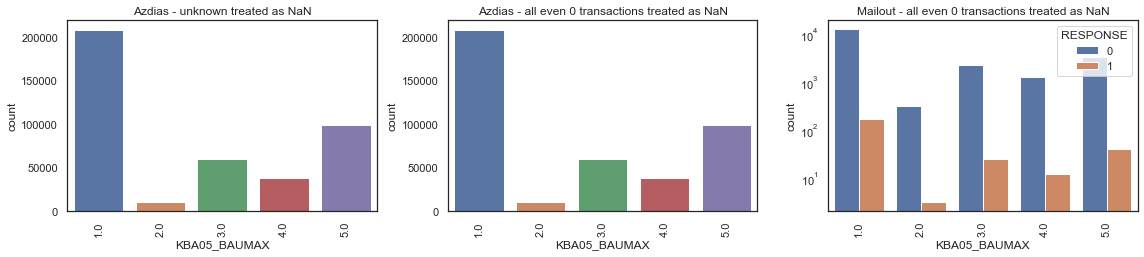

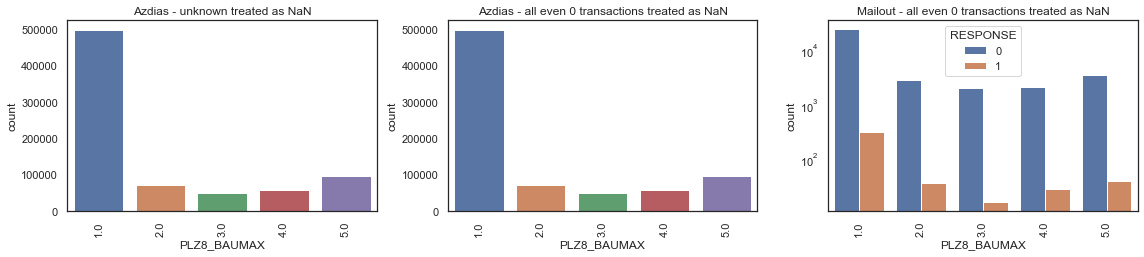

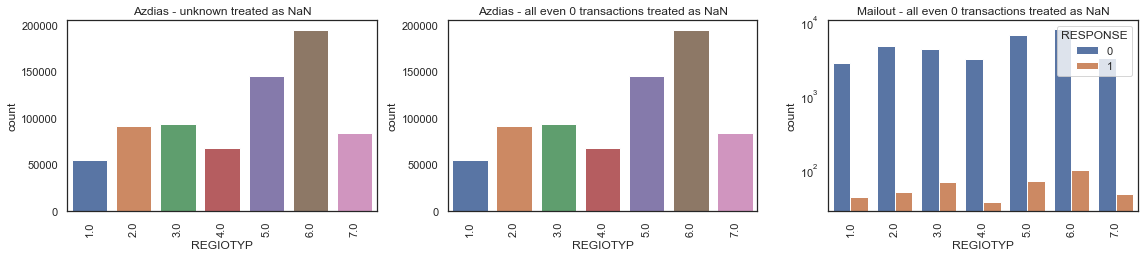

In [34]:
titles = ['Azdias - unknown treated as NaN', 
          'Azdias - all even 0 transactions treated as NaN', 
          'Mailout - all even 0 transactions treated as NaN']

compare_distributions_countplot_3by3(df1=azdias,
                                    df2=azdias_extended_na, 
                                    df3=mailout_train_extended_na,
                                    titles=titles,
                                    col=['REGIOTYP', 'KBA05_BAUMAX', 'PLZ8_BAUMAX'],
                                    logscale=True)

In [35]:
# how much does the standard deviation differs between individuals who responded vs not
std_mailout_responsed = abs(mailout_unsuccess_na[grid_columns].std() - mailout_success_na[grid_columns].std()).sort_values()
std_mailout_responsed = pd.DataFrame(std_mailout_responsed, columns=['std'])
std_mailout_responsed['count_respond'] = mailout_success_na[grid_columns].count()
std_mailout_responsed['count_norespond'] = mailout_unsuccess_na[grid_columns].count()
std_mailout_responsed

std  count_respond  count_norespond
D19_FREIZEIT            0.003133             57             5227
D19_RATGEBER            0.010869             78             7578
D19_BANKEN_GROSS        0.014365             41             4161
D19_SCHUHE              0.015491             51             5403
D19_TECHNIK             0.016427            196            17397
D19_VERSICHERUNGEN      0.026692            130            10817
D19_HAUS_DEKO           0.028443            170            14236
D19_VERSAND_REST        0.029628             78             6426
D19_ENERGIE             0.033289             58             3840
D19_SAMMELARTIKEL       0.036765            152            10824
D19_TELKO_REST          0.044164             50             4926
D19_REISEN              0.049939            194            14470
D19_BUCH_CD             0.059856            237            20315
D19_WEIN_FEINKOST       0.061141             77             5935
D19_BANKEN_REST         0.072409             26             2953
D19_KOSMETIK            0.073620            183            13860
D19_HANDWERK            0.079743            152            11724
D19_BEKLEIDUNG_GEH      0.082916             92             6921
D19_SONSTIGE            0.093445            362            27342
D19_VOLLSORTIMENT       0.096320            266            22068
D19_BIO_OEKO            0.103138             55             4485
D19_BEKLEIDUNG_REST     0.110086            151            12830
D19_DIGIT_SERV          0.158783             17             1719
D19_NAHRUNGSERGAENZUNG  0.181600             68             4386
D19_DROGERIEARTIKEL     0.192988             69             6168
D19_BILDUNG             0.220596             89             7978
D19_TIERARTIKEL         0.228759             14             2031
D19_LEBENSMITTEL        0.236351             63             5432
D19_BANKEN_DIREKT       0.258372             53             6104
D19_GARTEN              0.267604             38             3187
D19_TELKO_MOBILE        0.288283             83             6760
D19_KINDERARTIKEL       0.325057             95             9081
D19_BANKEN_LOKAL        0.995622              3              789

In [36]:
lowest_response = std_mailout_responsed[(std_mailout_responsed['count_respond'] < 30)]
lowest_response

std  count_respond  count_norespond
D19_BANKEN_REST   0.072409             26             2953
D19_DIGIT_SERV    0.158783             17             1719
D19_TIERARTIKEL   0.228759             14             2031
D19_BANKEN_LOKAL  0.995622              3              789

In [37]:
highest_std = std_mailout_responsed[std_mailout_responsed['std'] > 0.2]
highest_std

std  count_respond  count_norespond
D19_BILDUNG        0.220596             89             7978
D19_TIERARTIKEL    0.228759             14             2031
D19_LEBENSMITTEL   0.236351             63             5432
D19_BANKEN_DIREKT  0.258372             53             6104
D19_GARTEN         0.267604             38             3187
D19_TELKO_MOBILE   0.288283             83             6760
D19_KINDERARTIKEL  0.325057             95             9081
D19_BANKEN_LOKAL   0.995622              3              789

##### Let's create summarized features for grid columns and drop the details as 0 transactions are too high

**New 'BUYER TYPE' mapping:**
- 0 -> 0 or Unknown
- 1 -> Prospect
- 2 -> Single Buyer > 2 years
- 3 -> Single Buyer < 2 years
- 4 -> Multi Buyer

**New 'YEAR_LAST_ACTIVE' mapping:**
- 0: 0 or unknown
- 1: 1-3 - transactions in last year
- 2: 4-5 - tranasaction between 1-2 years
- 3: 6-7 - transactions > 2 years

In [38]:
# As grid columns by category has low data volume, summarize the columns and build one new column instead
azdias['GRID_BUYER_TYPE'], azdias['GRID_YEAR_LAST_ACTIVE'] = summarize_grid_columns(azdias_extended_na[grid_columns].copy())

# # Binarize grid columns
# print('Binarize GRID columns.....')
azdias[grid_columns] = binarize_grid_columns(azdias_extended_na[grid_columns].copy())

In [39]:
mailout_train['GRID_BUYER_TYPE'], mailout_train['GRID_YEAR_LAST_ACTIVE'] = summarize_grid_columns(mailout_train_extended_na[grid_columns].copy())
mailout_train[grid_columns] = binarize_grid_columns(mailout_train_extended_na[grid_columns].copy())

In [40]:
customers['GRID_BUYER_TYPE'], customers['GRID_YEAR_LAST_ACTIVE'] = summarize_grid_columns(customers_extended_na[grid_columns].copy())
customers[grid_columns] = binarize_grid_columns(customers_extended_na[grid_columns].copy())

In [41]:
# New grid level summary
df = pd.DataFrame()
df['Azdias_GRID_BUYER_TYPE'] = azdias['GRID_BUYER_TYPE'].value_counts()
df['Mailout_GRID_BUYER_TYPE'] = mailout_train['GRID_BUYER_TYPE'].value_counts()
df['Mailout_GRID_BUYER_TYPE_RESPONDED'] = mailout_train[mailout_train['RESPONSE'] == 1]['GRID_BUYER_TYPE'].value_counts()
df.sort_index()                        

Azdias_GRID_BUYER_TYPE  Mailout_GRID_BUYER_TYPE  \
0                  263948                     8127   
1                   21162                     1020   
2                  218359                    11413   
3                  225646                    13827   
4                  162106                     8575   

   Mailout_GRID_BUYER_TYPE_RESPONDED  
0                                 95  
1                                 15  
2                                141  
3                                189  
4                                 92

In [42]:
df = pd.DataFrame()
df['Azdias_GRID_YEAR_LAST_ACTIVE'] = azdias['GRID_YEAR_LAST_ACTIVE'].value_counts()
df['Mailout_GRID_YEAR_LAST_ACTIVE'] = mailout_train['GRID_YEAR_LAST_ACTIVE'].value_counts()
df['Mailout_GRID_YEAR_LAST_ACTIVE_RESPONDED'] = mailout_train[mailout_train['RESPONSE'] == 1]['GRID_YEAR_LAST_ACTIVE'].value_counts()

df.sort_index()                        

Azdias_GRID_YEAR_LAST_ACTIVE  Mailout_GRID_YEAR_LAST_ACTIVE  \
0                        263948                           8127   
1                        608926                          34025   
2                         18347                            810   

   Mailout_GRID_YEAR_LAST_ACTIVE_RESPONDED  
0                                       95  
1                                      424  
2                                       13

We can observe most individuals are single buyers, who bought in the last 12 months.
Most bought category was insurance, shoes, shipping, books, other

In [43]:
# how much does the standard deviation differs between individuals who responded vs not

success = mailout_train[mailout_train['RESPONSE'] == 1]
unsuccess = mailout_train[mailout_train['RESPONSE'] == 0]

std_mailout_responsed = abs(unsuccess[grid_columns].std() - success[grid_columns].std()).sort_values()
std_mailout_responsed = pd.DataFrame(std_mailout_responsed, columns=['std'])
std_mailout_responsed['count_respond'] = success[grid_columns].sum()
std_mailout_responsed['count_norespond'] = unsuccess[grid_columns].sum()
std_mailout_responsed

std  count_respond  count_norespond
D19_TELKO_MOBILE        0.000669             80             6424
D19_VOLLSORTIMENT       0.000855            239            19707
D19_LEBENSMITTEL        0.001481             62             4903
D19_HANDWERK            0.001582            120             9699
D19_VERSAND_REST        0.001892             77             6235
D19_GARTEN              0.002764             37             2888
D19_SONSTIGE            0.003054            300            22242
D19_BUCH_CD             0.003388            227            19543
D19_VERSICHERUNGEN      0.004765            128            10578
D19_BEKLEIDUNG_REST     0.005371            131            10875
D19_HAUS_DEKO           0.005585            166            13900
D19_BEKLEIDUNG_GEH      0.007161             84             6397
D19_DROGERIEARTIKEL     0.009683             67             5730
D19_KOSMETIK            0.010881             98             7286
D19_BILDUNG             0.012098             72             6254
D19_BIO_OEKO            0.014726             47             3341
D19_TECHNIK             0.014774            147            13140
D19_FREIZEIT            0.014879             56             4987
D19_REISEN              0.017282            151            10680
D19_DIGIT_SERV          0.020622             16             1619
D19_WEIN_FEINKOST       0.022524             60             4058
D19_RATGEBER            0.023772             75             7044
D19_SAMMELARTIKEL       0.023897            148            10014
D19_TELKO_REST          0.026960             48             4696
D19_ENERGIE             0.028856             54             3453
D19_BANKEN_GROSS        0.030459             41             4161
D19_KINDERARTIKEL       0.034196             74             7455
D19_BANKEN_REST         0.035207             25             2770
D19_SCHUHE              0.035575             50             5190
D19_BANKEN_LOKAL        0.038093              2              423
D19_NAHRUNGSERGAENZUNG  0.041188             64             3767
D19_TIERARTIKEL         0.049091             10             1506
D19_BANKEN_DIREKT       0.053709             49             5785

Interesting for those individuals who responded to the campaign was in category house decor if we just look at active tran!!

<a id='missing_values_feature_importance'></a>
#### 2.1.5 Feature importance - A first impression
Compare columns with biggest difference in mean between full population and those individuals who responded

Want to take care, as even though missing values might be high, if they are strong distinguising columns we should avoid to drop them

Columns to be excluded from features importance: ['ALTER_KIND4', 'ALTER_KIND3', 'TITEL_KZ', 'ALTER_KIND2', 'ALTER_KIND1', 'RESPONSE']


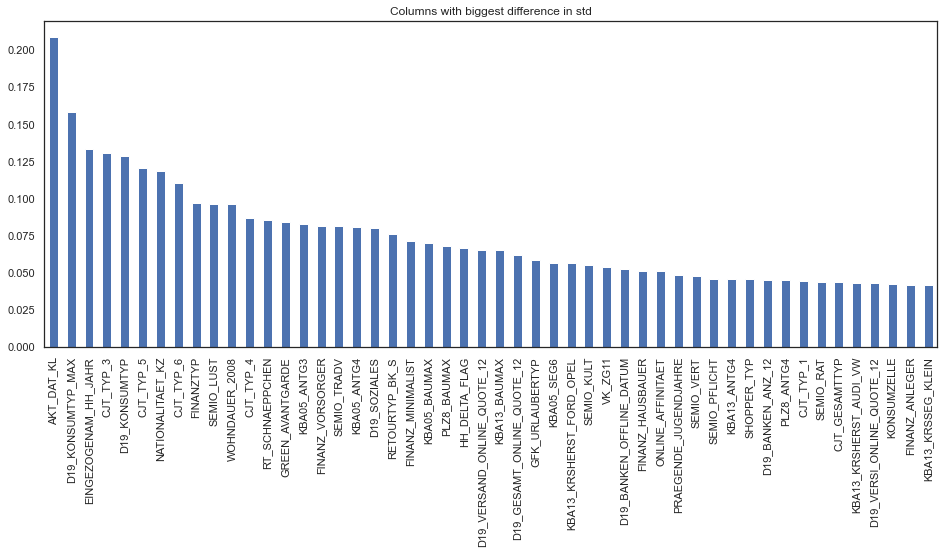

In [44]:
cols = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers = customers.drop(cols, axis=1, errors='ignore')
customers_extended_na.drop(cols, axis=1, inplace=True, errors='ignore')


important_features_azdias = std_feature_importance(df1=azdias_extended_na.copy(), 
                                                   df2=customers_extended_na.copy(), 
                                                   top_n=50,
                                                   visualize=True,
                                                   df_missing=missing_columns_mailout)

Columns to be excluded from features importance: ['ALTER_KIND4', 'ALTER_KIND3', 'TITEL_KZ', 'ALTER_KIND2', 'ALTER_KIND1', 'RESPONSE']


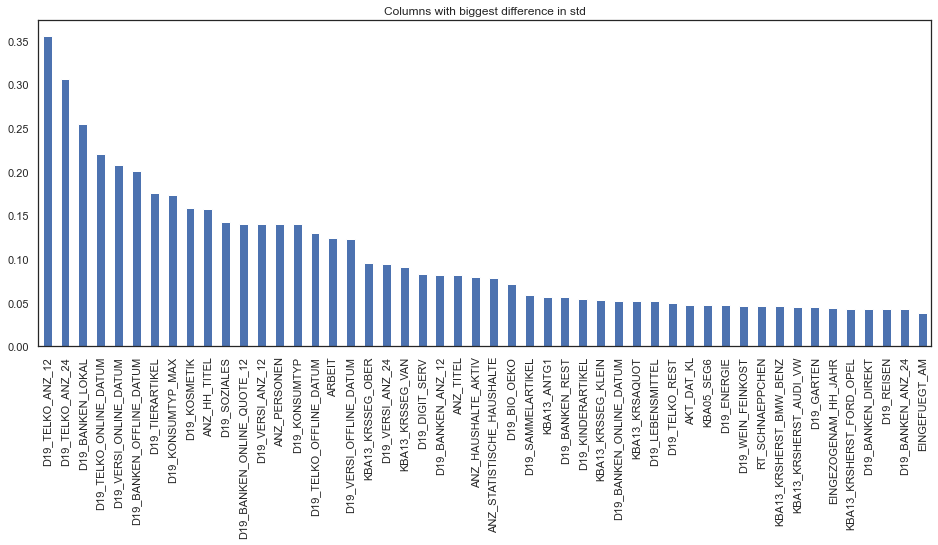

In [45]:
important_features_mailout = std_feature_importance(df1=mailout_unsuccess_na.copy(), 
                                                    df2=mailout_success_na.copy(), 
                                                    top_n=50, 
                                                    visualize=True,
                                                    df_missing=missing_columns_mailout)

Some of these features are highly correlated, and can be removed. Further down we will have another look at that

In [46]:
# some of these features are highly correlated, and can be removed. Further down we will have another look at this
columns_to_keep = set(important_features_azdias[:80] + important_features_mailout[:80])
print('Number of columns we want to protect: {}'.format(len(columns_to_keep)))

Number of columns we want to protect: 129


In [47]:
# drop columns with ALL missing values exceeding 80% based on MAILOUT training dataset
columns_to_drop_missing1 = list(missing_columns_azdias_na[missing_columns_azdias_na >= 80].index)
print('Number of columns we want to drop: {}'.format(len(columns_to_drop_missing1)))
columns_to_drop_missing1

Number of columns we want to drop: 51


['D19_TELKO_ONLINE_QUOTE_12',
 'ALTER_KIND4',
 'D19_VERSI_ONLINE_QUOTE_12',
 'TITEL_KZ',
 'ANZ_TITEL',
 'ALTER_KIND3',
 'D19_VERSI_ONLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'ANZ_HH_TITEL',
 'ALTER_KIND2',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_TELKO_ANZ_12',
 'D19_DIGIT_SERV',
 'D19_BIO_OEKO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_TIERARTIKEL',
 'D19_GARTEN',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_LEBENSMITTEL',
 'D19_WEIN_FEINKOST',
 'D19_BANKEN_ANZ_12',
 'D19_ENERGIE',
 'D19_TELKO_ANZ_24',
 'D19_BANKEN_REST',
 'D19_VERSI_ANZ_12',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_BILDUNG',
 'ALTER_KIND1',
 'D19_BEKLEIDUNG_GEH',
 'D19_RATGEBER',
 'D19_SAMMELARTIKEL',
 'D19_BANKEN_ANZ_24',
 'D19_FREIZEIT',
 'D19_BANKEN_GROSS',
 'D19_VERSI_ANZ_24',
 'D19_SCHUHE',
 'D19_HANDWERK',
 'D19_TELKO_REST',
 'D19_SOZIALES',
 'D19_DROGERIEARTIKEL',
 'D19_KINDERARTIKEL',
 'D19_LOTTO',
 'D19_KOSMETIK',
 'D19_REISEN',
 'D19_VERSAND_REST',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_ONLI

In [48]:
# drop columns with missing values exceeding 50% in the full population dataset
columns_to_drop_missing2 = list(missing_columns_azdias[missing_columns_azdias > 51].index)
print('Number of additional columns we want to drop: {}'.format(len(columns_to_drop_missing2)))
columns_to_drop_missing2

Number of additional columns we want to drop: 9


['ALTER_KIND4',
 'TITEL_KZ',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'AGER_TYP',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [49]:
columns_to_drop_missing = set(list(columns_to_drop_missing1) + list(columns_to_drop_missing2))
print('Total number of columns we want to drop: {}'.format(len(columns_to_drop_missing)))
columns_to_drop_missing

Total number of columns we want to drop: 55


{'AGER_TYP',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_HH_TITEL',
 'ANZ_TITEL',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SOZIALES',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_MOBILE',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 '

In [50]:
# remove columns we want to protect does not matter how many missing values they have
columns_to_remove = [col for col in columns_to_drop_missing if col in columns_to_keep]
print('Removing protected columns {} from the missing drop list'.format(columns_to_remove))
for col in columns_to_remove:
    columns_to_drop_missing.remove(col)

Removing protected columns ['D19_BANKEN_ONLINE_QUOTE_12', 'D19_TELKO_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_TELKO_REST', 'D19_BANKEN_DIREKT', 'D19_SAMMELARTIKEL', 'D19_BIO_OEKO', 'D19_GARTEN', 'D19_SOZIALES', 'D19_VERSI_ONLINE_QUOTE_12', 'ANZ_TITEL', 'D19_BANKEN_ONLINE_DATUM', 'D19_KOSMETIK', 'D19_TELKO_ANZ_12', 'D19_BANKEN_LOKAL', 'D19_VERSI_OFFLINE_DATUM', 'D19_KINDERARTIKEL', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_REST', 'D19_DROGERIEARTIKEL', 'D19_LEBENSMITTEL', 'D19_ENERGIE', 'D19_TELKO_ONLINE_DATUM', 'D19_NAHRUNGSERGAENZUNG', 'D19_WEIN_FEINKOST', 'D19_LOTTO', 'D19_TIERARTIKEL', 'D19_BANKEN_ANZ_12', 'D19_TELKO_ANZ_24', 'KBA05_BAUMAX', 'ANZ_HH_TITEL', 'D19_VERSI_ANZ_24', 'D19_HANDWERK', 'D19_REISEN', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BILDUNG', 'D19_DIGIT_SERV', 'D19_VERSI_ANZ_12'] from the missing drop list


In [51]:
print('Columns remaining on drop list: {}'.format(len(columns_to_drop_missing)))

Columns remaining on drop list: 17


In [52]:
# we drop fields below does not matter if they need to be protected
columns_to_drop_missing.add('CAMEO_DEU_2015')
columns_to_drop_missing.add('EXTSEL992')
columns_to_drop_missing.add('ANZ_STATISTISCHE_HAUSHALTE')
print('Columns remaining on drop list: {}'.format(len(columns_to_drop_missing)))
columns_to_drop_missing

Columns remaining on drop list: 19


{'AGER_TYP',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_DEU_2015',
 'D19_BANKEN_GROSS',
 'D19_BEKLEIDUNG_GEH',
 'D19_FREIZEIT',
 'D19_HAUS_DEKO',
 'D19_RATGEBER',
 'D19_SCHUHE',
 'D19_TELKO_MOBILE',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_REST',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'TITEL_KZ'}

In [53]:
# Update numerical columns with columns we will remove
numerical_columns = [col for col in numerical_columns if not col in columns_to_drop_missing]

In [54]:
# we used azdias_extended_na to analyse the missing values and also treated transaction data = 0 as missing
# We don't want to impute such columns = 0, later, we want to keep 0 values so we continue now with AZDIAS datset
azdias_reduced_columns = azdias.drop(columns_to_drop_missing, axis=1, errors='ignore')
azdias_extended_na.drop(columns_to_drop_missing, axis=1, errors='ignore', inplace=True)
mailout_reduced_columns = mailout_train.drop(columns_to_drop_missing, axis=1, errors='ignore')
print('Columns dropped {}'.format(columns_to_drop_missing))

Columns dropped {'EXTSEL992', 'D19_TELKO_MOBILE', 'D19_SCHUHE', 'D19_VERSAND_REST', 'AGER_TYP', 'TITEL_KZ', 'D19_HAUS_DEKO', 'ALTER_KIND2', 'ALTER_KIND1', 'D19_RATGEBER', 'D19_BEKLEIDUNG_GEH', 'CAMEO_DEU_2015', 'D19_TELKO_ONLINE_QUOTE_12', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_BANKEN_GROSS', 'KK_KUNDENTYP', 'ALTER_KIND4', 'ALTER_KIND3', 'D19_FREIZEIT'}


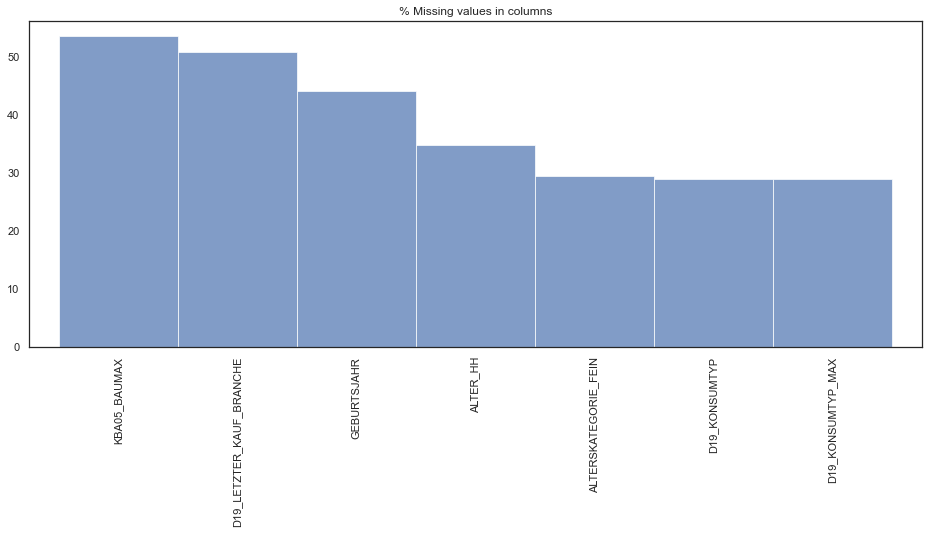

In [55]:
missing_columns_proportions = round(azdias_reduced_columns.isna().mean() * 100, 2).sort_values(ascending=False)
missing_columns_proportions[missing_columns_proportions > 20].plot(kind="bar", 
                                                                   figsize=(16,6), 
                                                                   title='% Missing values in columns',
                                                                   width=1,
                                                                   alpha=0.7)
plt.show()

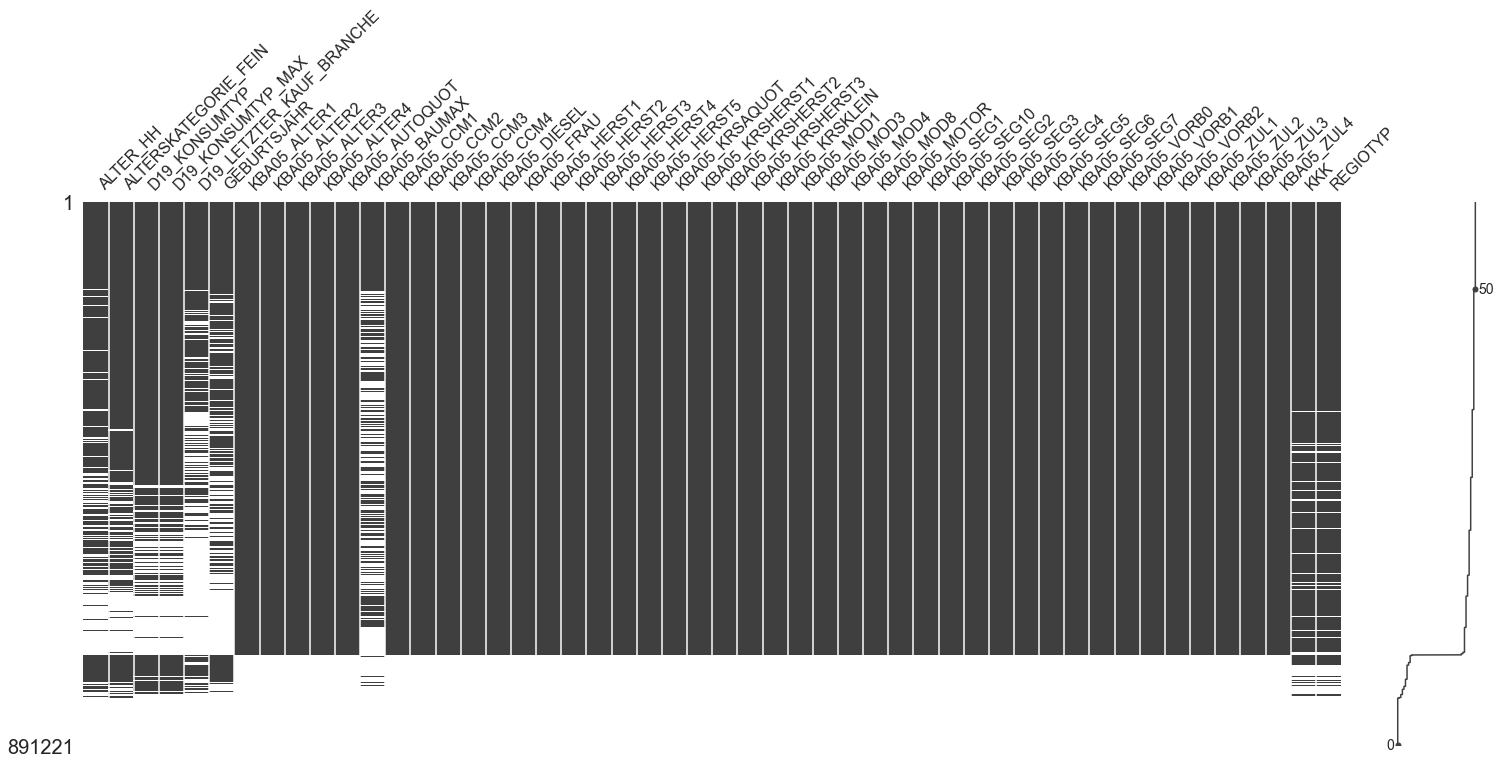

In [56]:
# missing values after column cleaning
msno.matrix(azdias_reduced_columns, filter="bottom", n=50, sort="descending");

In [57]:
azdias_reduced_columns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891221 entries, 910215 to 825787
Columns: 348 entries, AKT_DAT_KL to GRID_YEAR_LAST_ACTIVE
dtypes: float64(269), int64(77), object(2)
memory usage: 2.3+ GB


<a id='missing_values_rows'></a>
### 2.2 Drop rows which contain too many missing values

In [58]:
# missing data in rows - statistics
missing_data_in_rows = azdias_reduced_columns.isna().mean(axis=1) * 100
missing_data_in_rows.describe()

count    891221.000000
mean          9.541672
std          21.107328
min           0.000000
25%           0.287356
50%           0.862069
75%           2.011494
max          70.689655
dtype: float64

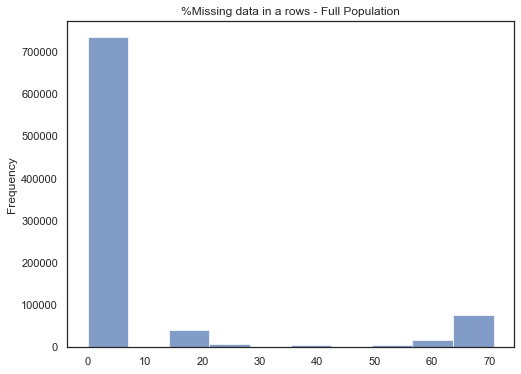

In [59]:
missing_data_in_rows.plot(kind='hist', 
                          title='%Missing data in a rows - Full Population', 
                          figsize=(8,6),
                          alpha=0.7)
plt.show()

In [60]:
# missing data in rows - statistics
missing_data_in_rows_mailout = mailout_reduced_columns.isna().mean(axis=1) * 100
missing_data_in_rows_mailout.describe()

count    42962.000000
mean        13.602945
std         26.159400
min          0.000000
25%          0.285714
50%          0.571429
75%          2.285714
max         70.571429
dtype: float64

<AxesSubplot:title={'center':'%Missing data in a row - Mailout Campaign'}, ylabel='Frequency'>

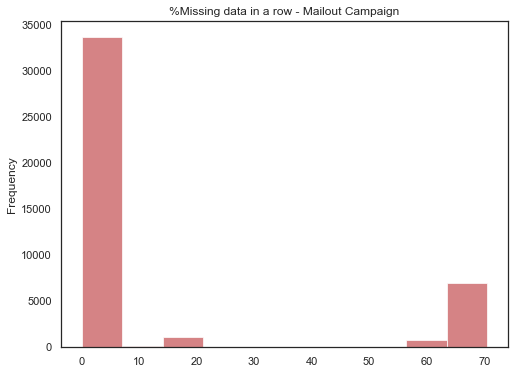

In [61]:
missing_data_in_rows_mailout.plot(kind='hist', 
                                  title='%Missing data in a row - Mailout Campaign', 
                                  figsize=(8,6),
                                  color='r',
                                  alpha=0.7)

In [62]:
azdias_rows_below_threshold = azdias_reduced_columns.loc[azdias_reduced_columns.isna().mean(axis=1) < 0.50, :]
azdias_rows_above_threshold = azdias_reduced_columns.loc[azdias_reduced_columns.isna().mean(axis=1) >= 0.50, :]
print('Shape below threshold is {}, Shape above threshold is {}'.format(azdias_rows_below_threshold.shape,
                                                                       azdias_rows_above_threshold.shape))

Shape below threshold is (791246, 348), Shape above threshold is (99975, 348)


In [63]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
    
columns_isna = missing_columns_azdias[missing_columns_azdias < 10].index[:7]
compare_distributions(azdias_rows_below_threshold, azdias_rows_above_threshold, columns_isna) 

In [64]:
mailout_rows_below_threshold = mailout_reduced_columns.loc[mailout_reduced_columns.isna().mean(axis=1) < 0.50, :]
mailout_rows_above_threshold = mailout_reduced_columns.loc[mailout_reduced_columns.isna().mean(axis=1) >= 0.50, :]
print('Shape below threshold is {}, Shape above threshold is {}'.format(mailout_rows_below_threshold.shape,
                                                                       mailout_rows_above_threshold.shape))


Shape below threshold is (35094, 350), Shape above threshold is (7868, 350)


<a id='feature_engineering'></a>
# Step 3: Feature Engineering and Transformations 

In this section we will
- BINARIZE columns where needed
- Create NEW features, SPLIT features
- Apply ONE HOT ENCODING


In [65]:
# Only do ohn for non-numeric values to start with
print(azdias_rows_below_threshold.shape)
azdias_transformed = feature_engineering(azdias_rows_below_threshold.copy())
print(azdias_transformed.shape)

(791246, 348)
Adding few features WOHNLAGE_QUALITY and WOHNLAGE_RURAL ..........
Adding few features PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT ..........
Adding few features CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFESTAGE ..........
Cleaning PLZ8_BAUMAX, KBA05_BAUMAX .......... 
Cleaning OST_WEST_KZ .......... 
Reducing range for D19_KONSUMTYP_MAX from 1-8 to 1-5
Reducing range for D19_KONSUMTYP from 1-9 to 1-7
Rerank ranges for banking transactions
Categorial columns to one hot encode: ['D19_LETZTER_KAUF_BRANCHE']
353 total features BEFORE one-hot encoding
386 total features AFTER one-hot encoding
(791246, 386)


In [66]:
azdias_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 791246 entries, 910220 to 825787
Columns: 386 entries, AKT_DAT_KL to D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
dtypes: float64(274), int64(78), uint8(34)
memory usage: 2.1 GB


Re-Encode Categorical Features

- <b>Keep</b>
  - Below fields contains only 2 already numerical values, I will thus keep them and leave them as they are
    - ANREDE_KZ, GREEN_AVANTGARDE, VERS_TYP, SOHO_KZ


- <b>Drop</b>
  - LP_FAMILIE_FEIN 
    - A sub category of LP_FAMILIE_GROB which describe households (e.g. single, married). I think the main category is summarizing the details very well. I therefore think this column does not add much value.
  - LP_STATUS_FEIN
    - Sub-category and derived from LP_STATUS_GROB. This field does seems to be well distributed and contains valuable information, not sure if this is the right decision I will revise the decision later. For now I drop it.
  - LP_STATUS_GROB
    - Seems to contain the same inforamtion as FINANZ_ fields which is much easier to interpret later
  - CAMEO_DEU_2015 contains many string values, and are a sub category of CAMEU_DEUG_2015. However it seem to contain really valuable information but contains 44 features. I will for now drop it, I think CAMEO_DEUG_2015 might be a good enough summary.
  
  There are many fields that contain similar information, lebensphase seems to be fix-up of status, income and age, using fields familie_grob we grap the status, using lp_status_grob we grab income status, and we can grab the age categorie in fields like alterkategorie_grob.
    
  
- <b>Engineering steps</b>
  - OST_WEST_KZ (values for east/west Germany) have binary values that should be kept, however re-encode the string values as numbers

  - All columns below, I will keep, but as they contain more than 2 numerical columns that does not represent intervals. I will split the columns into multiple dummy variables
   - 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', will be converted to dummy variables
   
Doubts:
LEBENSPHASE HAS A MIX OF 3 CHARACTERICSTICS, single, income and age... It seems like this field is mix of fields LB_FAMILIE* (status) and LB_STATUS* (financial income). Therefore I drop it

<a id='correlation'></a>
# Step 4: Correlation Analysis

Use feature correlation across the entire dataset to determine which features are too highly-correlated with each other to include both features in a single model. 

We do this after feature engineering as this results in more correlations

In [67]:
# Create correlation matrix using full demographics dataset
corr_matrix = azdias_transformed.corr().round(2)

In [68]:
# Display only the most correlated values 
corr_matrix_90 = corr_matrix[((abs(corr_matrix) >= 0.90) & (abs(corr_matrix) < 1))].dropna(axis=1, how='all')
corr_matrix_90 = corr_matrix_90.dropna(axis=0, how='all')

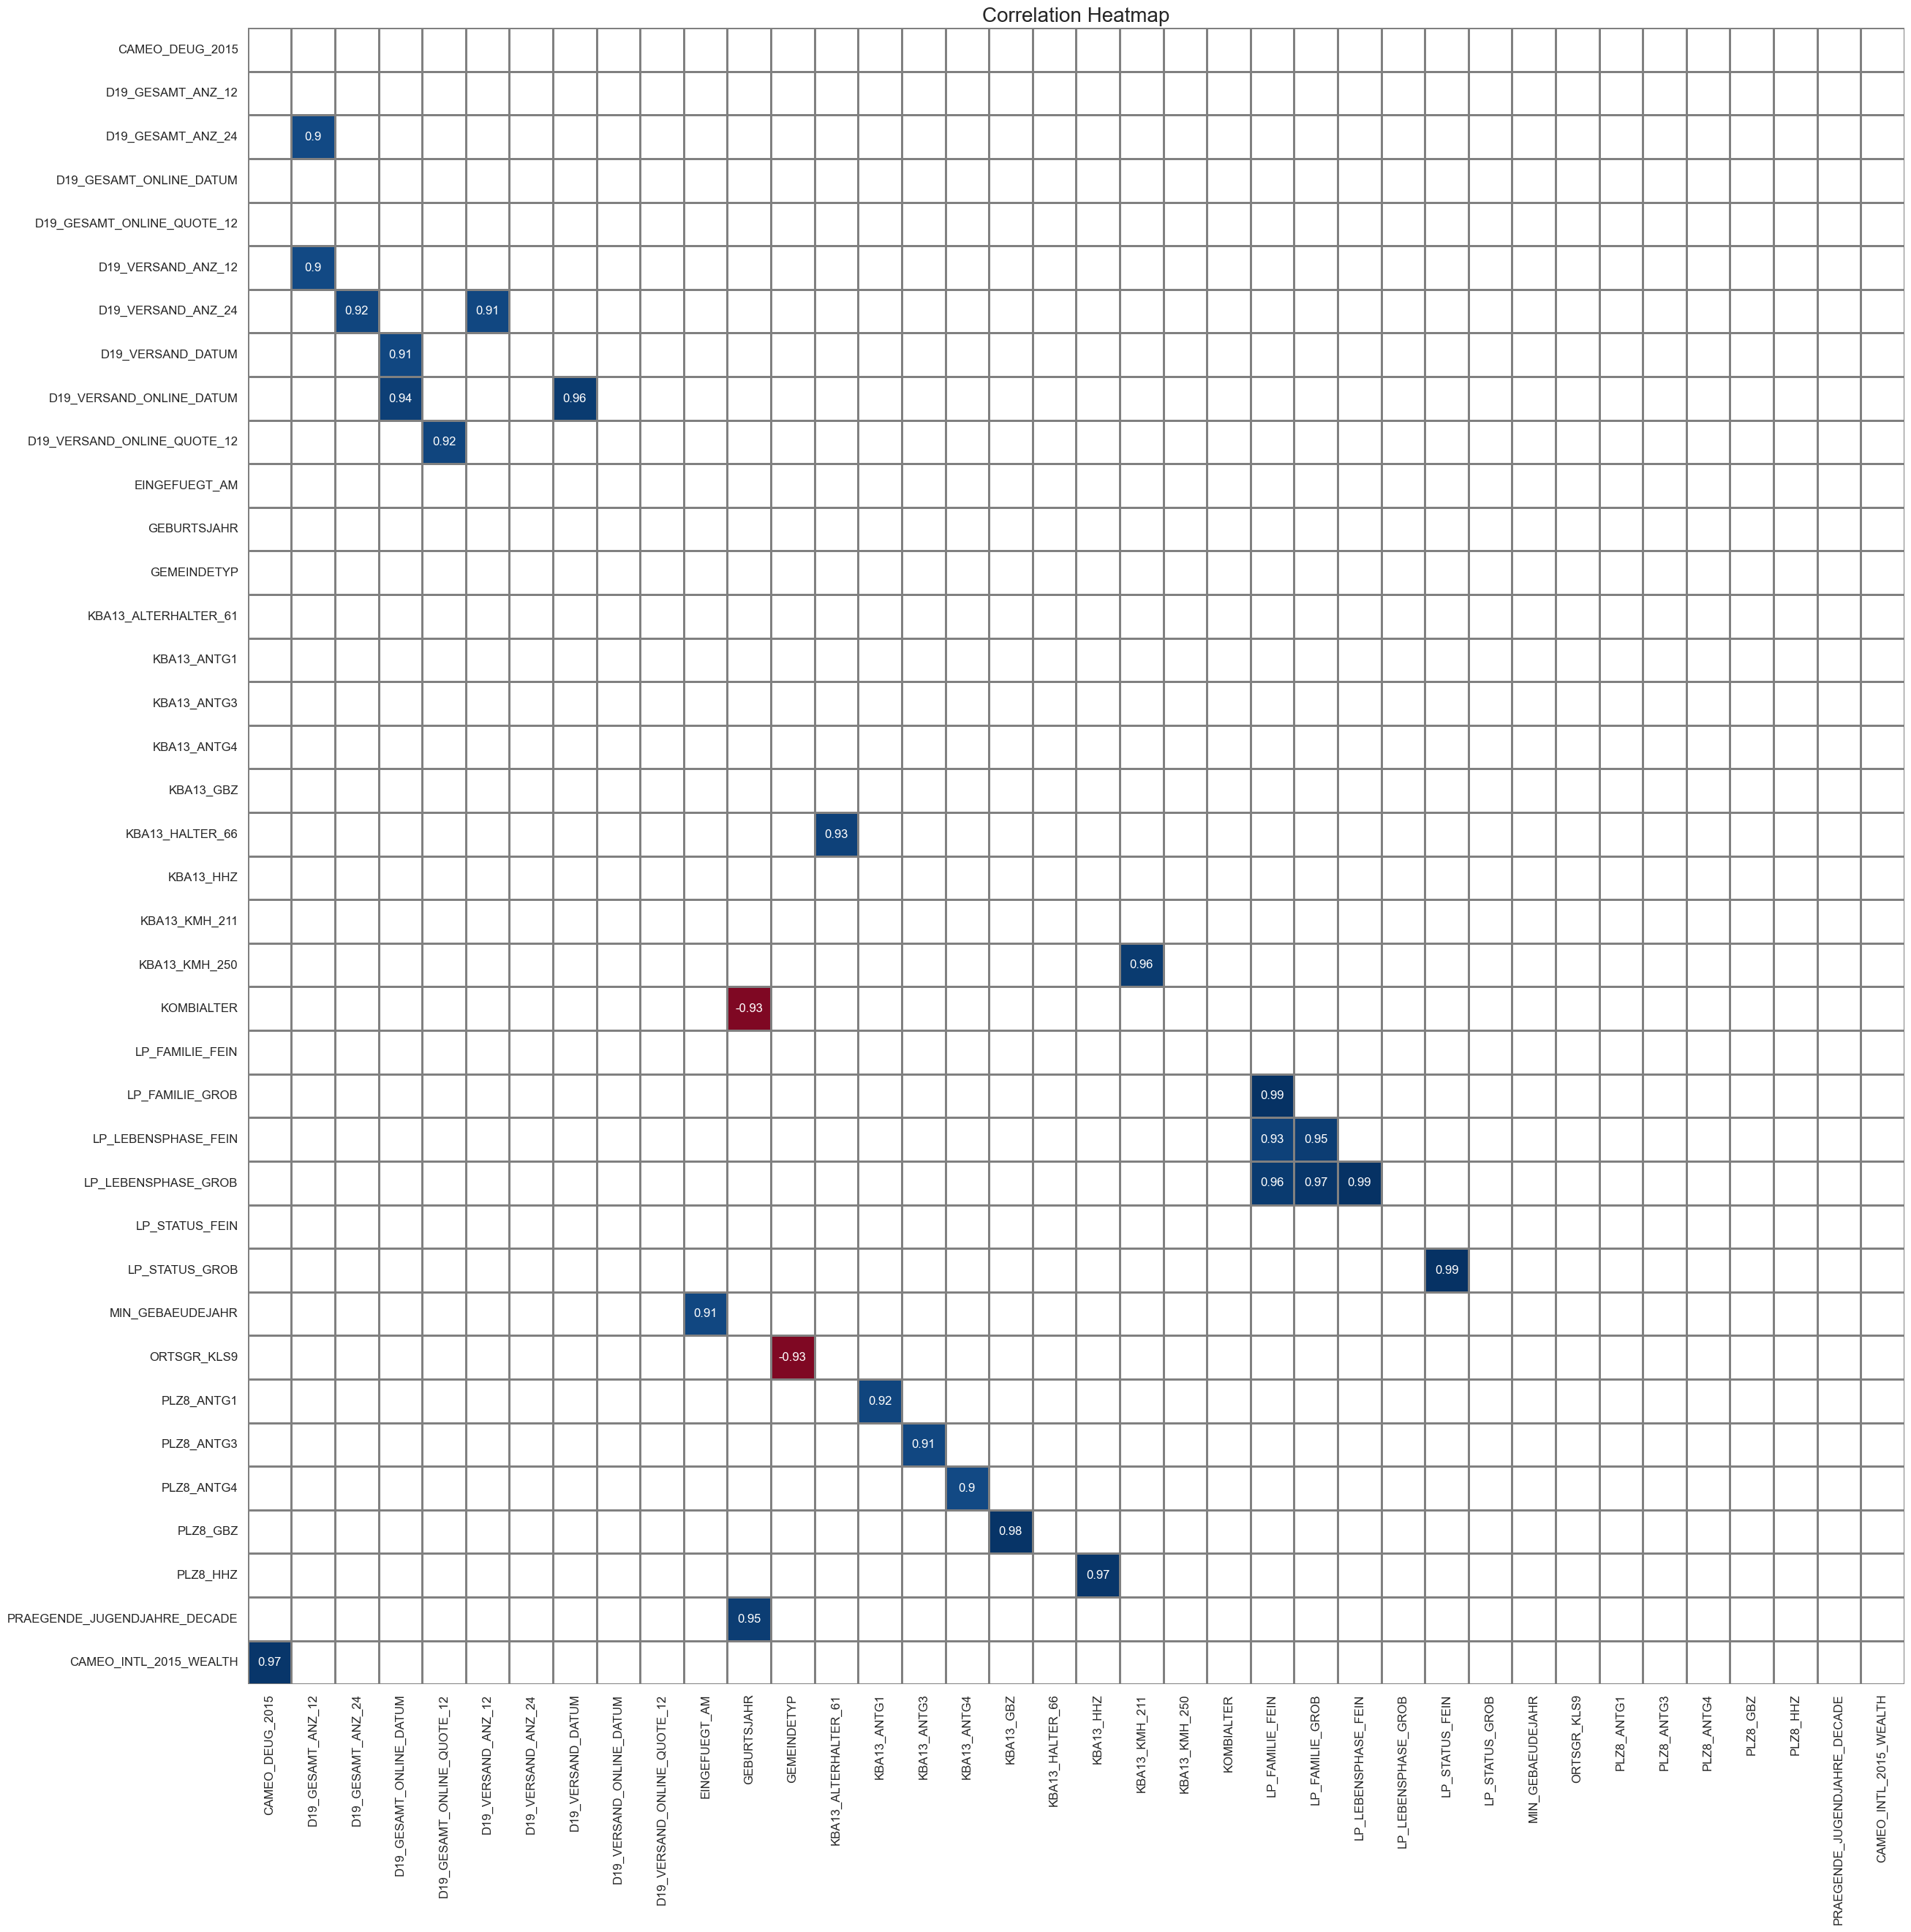

In [69]:
# visualize and analyze the most significant correlations above 0.9
display_correlations(corr_matrix_90, figsize=(30,30), dpi=100)

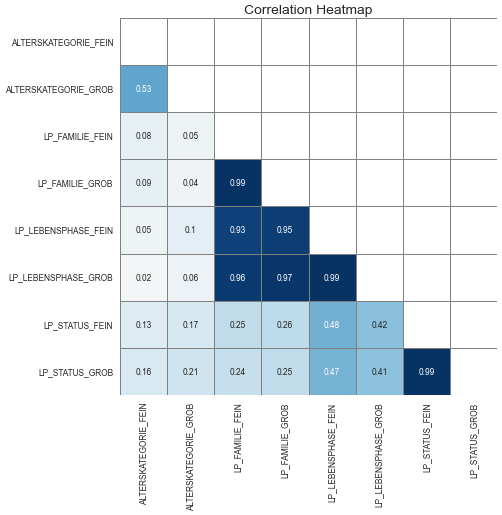

In [70]:
# data in below columns seems to contain very similar information, let's explore them deeper
# A deeper look at age, status and income correlation
columns = ['ALTERSKATEGORIE_FEIN', 'ALTERSKATEGORIE_GROB', # age
           'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',           # status (single, family etc)
           'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',   # mix age, status, income
           'LP_STATUS_FEIN', 'LP_STATUS_GROB']             # income


# Create correlation matrix for just Features to determine different models to test
corr_matrix_xx = azdias_transformed[columns].corr().abs().round(2)

display_correlations(corr_matrix_xx, figsize=(10,10), dpi=50)

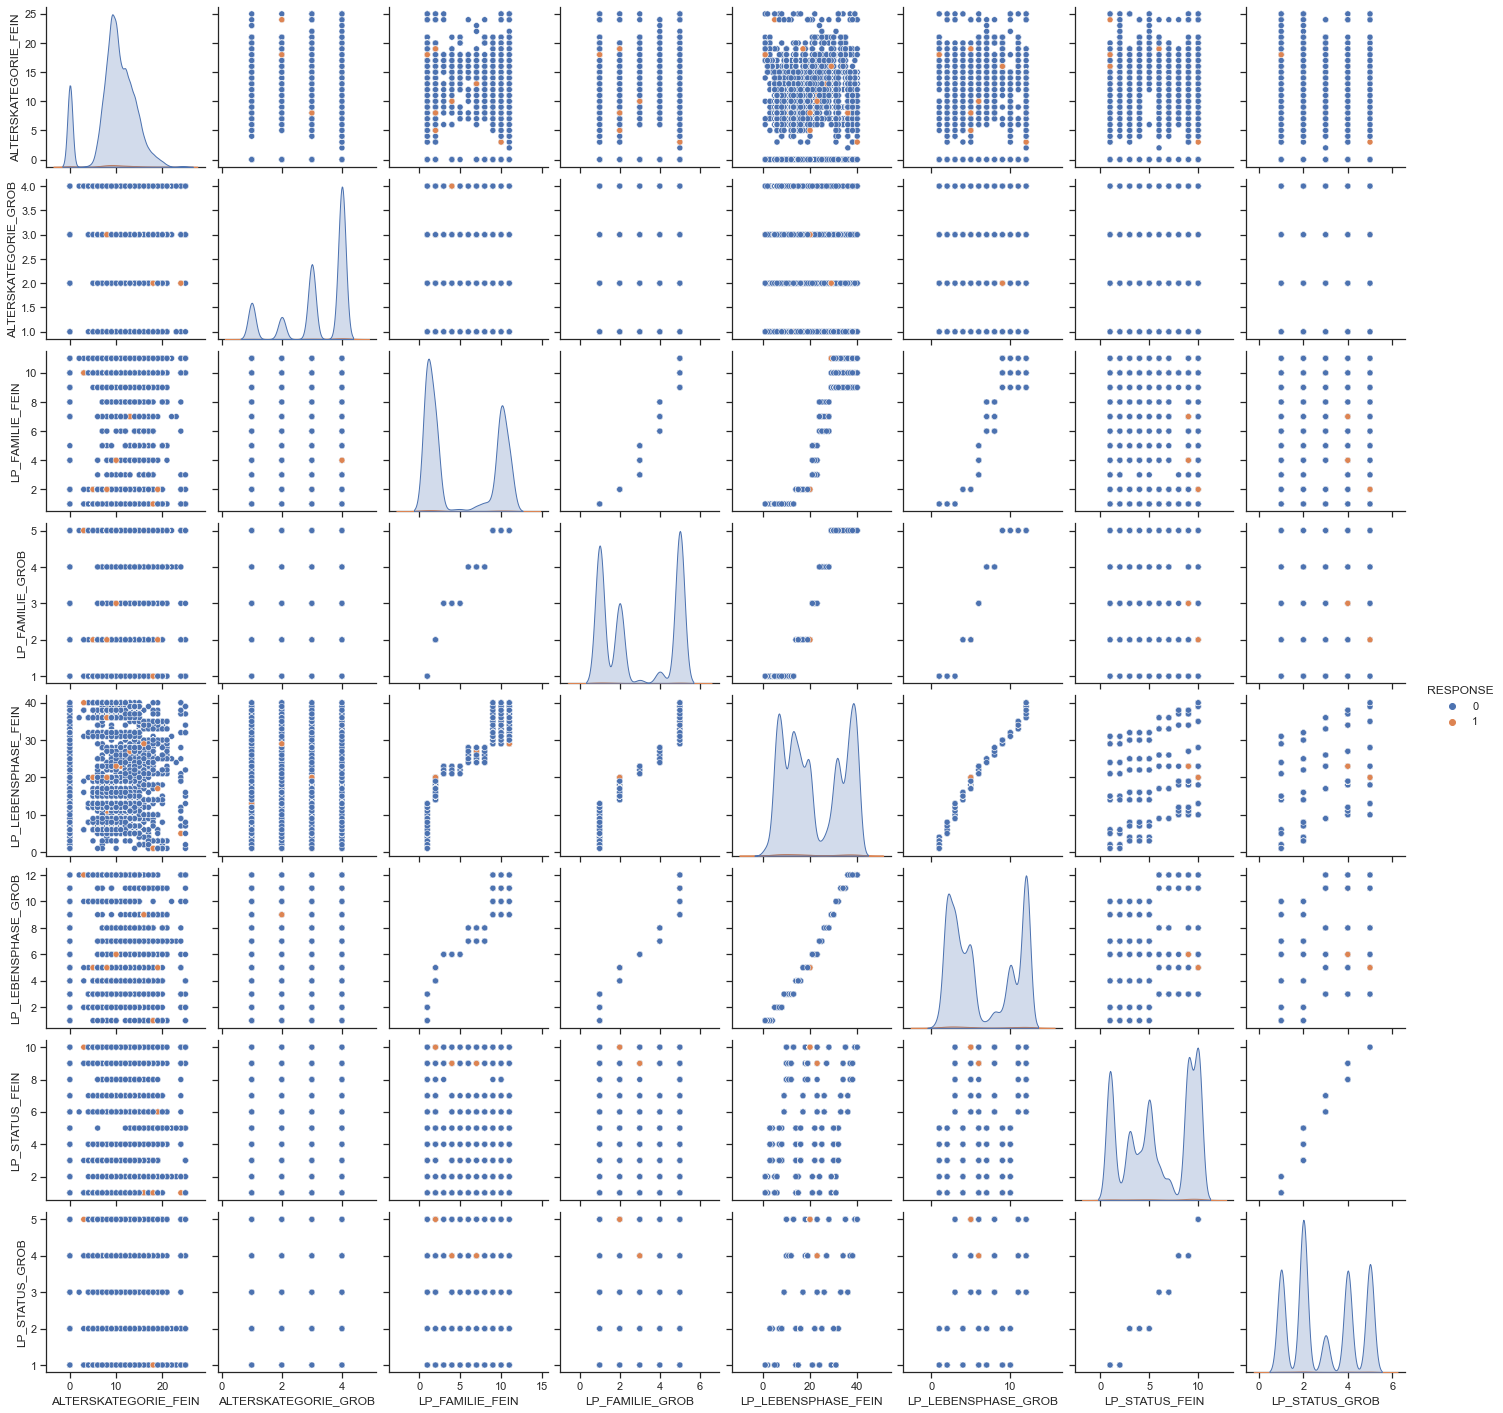

In [71]:
# A deeper look at age, status and income correlations
columns = ['ALTERSKATEGORIE_FEIN', 'ALTERSKATEGORIE_GROB', # age
           'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB',           # status (single, family etc)
           'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',   # mix age, status, income
           'LP_STATUS_FEIN', 'LP_STATUS_GROB']             # income

columns.append('RESPONSE')
sns.set(style='ticks')
sns.pairplot(mailout_train[columns], hue='RESPONSE')
plt.show()

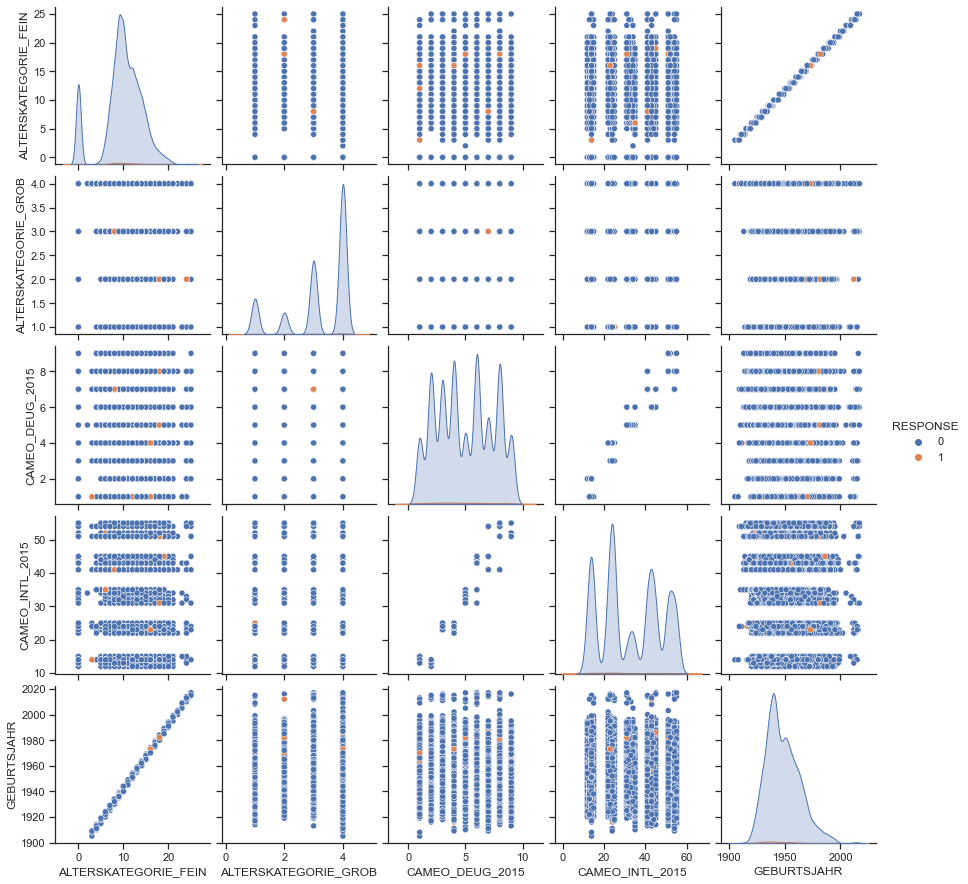

In [72]:
# A deeper look at age, status and income correlations
columns = ['ALTERSKATEGORIE_FEIN', 'ALTERSKATEGORIE_GROB', # age
           'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'GEBURTSJAHR']
#            'CAMEO_INTL_2015_WEALTH'?, 'CAMEO_INTL_2015_LIFESTAGE']             # income

columns.append('RESPONSE')
sns.set(style='ticks')
sns.pairplot(mailout_train[columns], hue='RESPONSE')
plt.show()

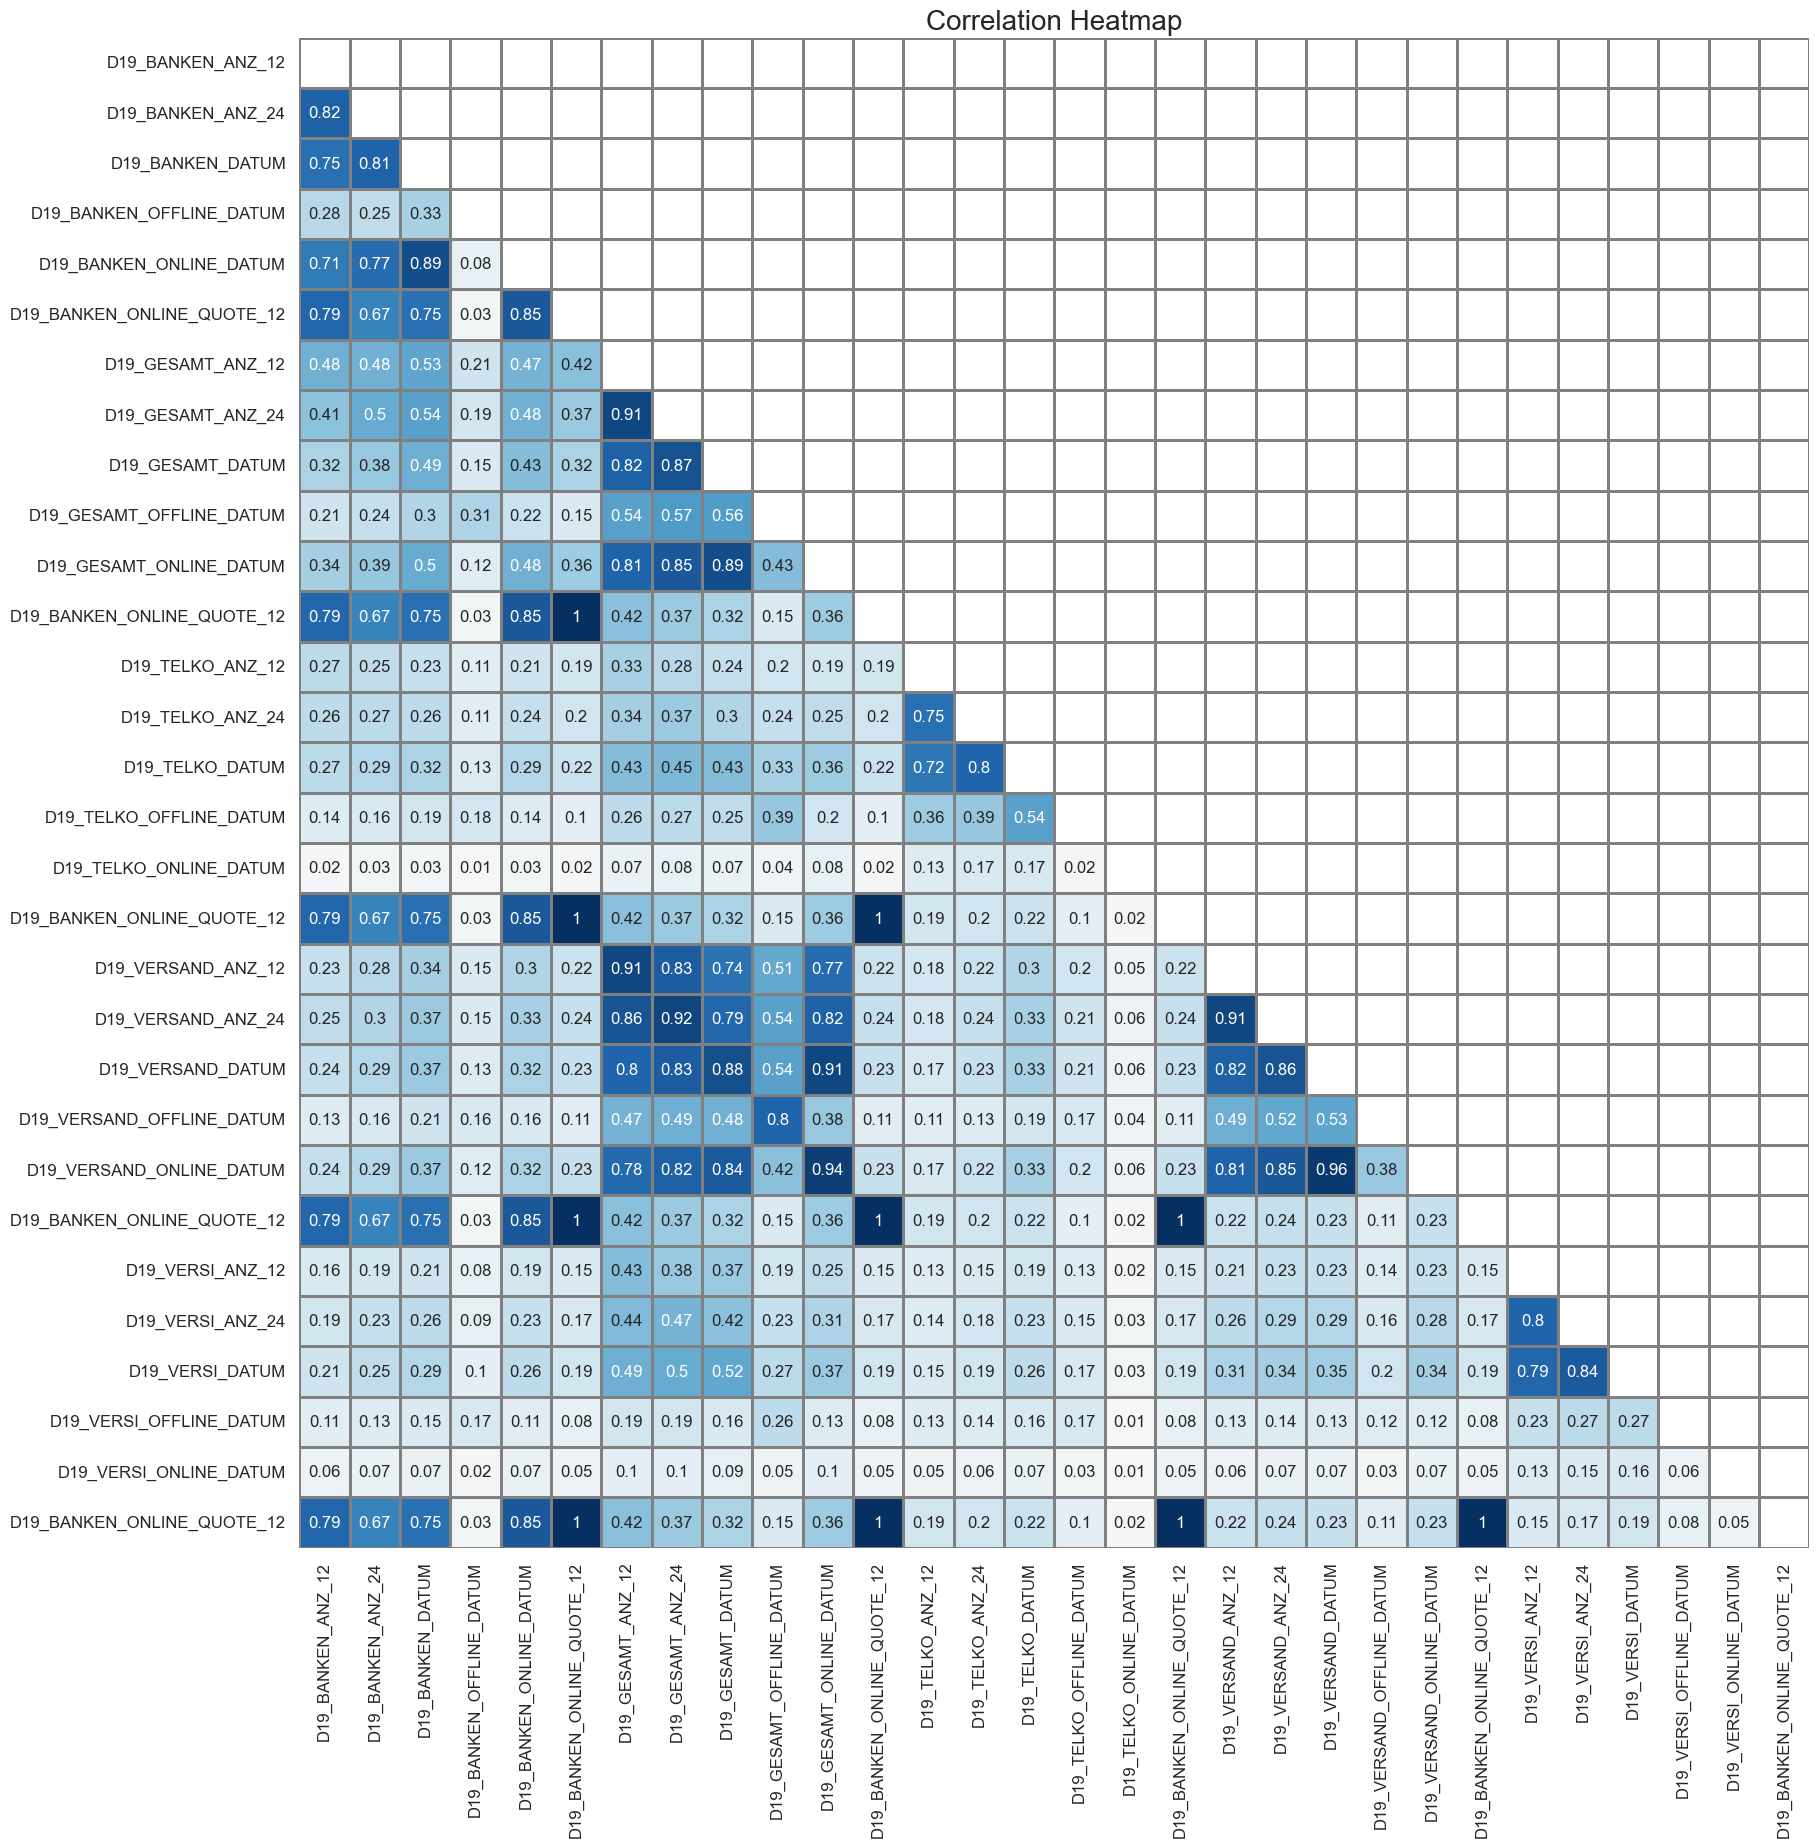

In [73]:
# household transaction analysis
columns = ['D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
           'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 
           'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 
           'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',  
           'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM', 'D19_VERSI_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',  
          ]

# Create correlation matrix for just Features to determine different models to test
corr_matrix_xx = azdias[columns].corr().abs().round(2)

display_correlations(corr_matrix_xx, figsize=(20,20), dpi=100)

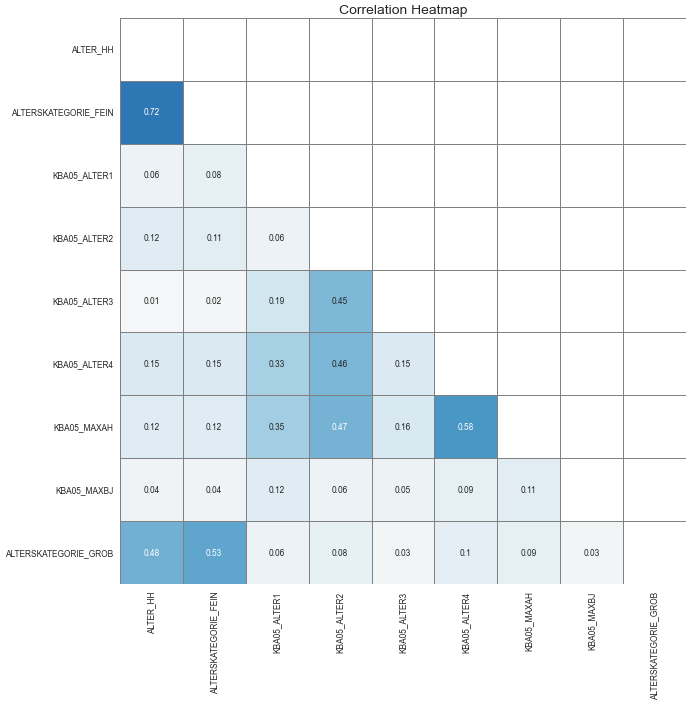

In [74]:
# All the age fields
columns = ['ALTER_HH', 'ALTERSKATEGORIE_FEIN', 'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4',
'KBA05_MAXAH', 'KBA05_MAXBJ', 'ALTERSKATEGORIE_GROB']

# Create correlation matrix for just Features to determine different models to test
corr_matrix_xx = azdias_transformed[columns].corr().abs().round(2)

display_correlations(corr_matrix_xx, figsize=(15, 15), dpi=50)

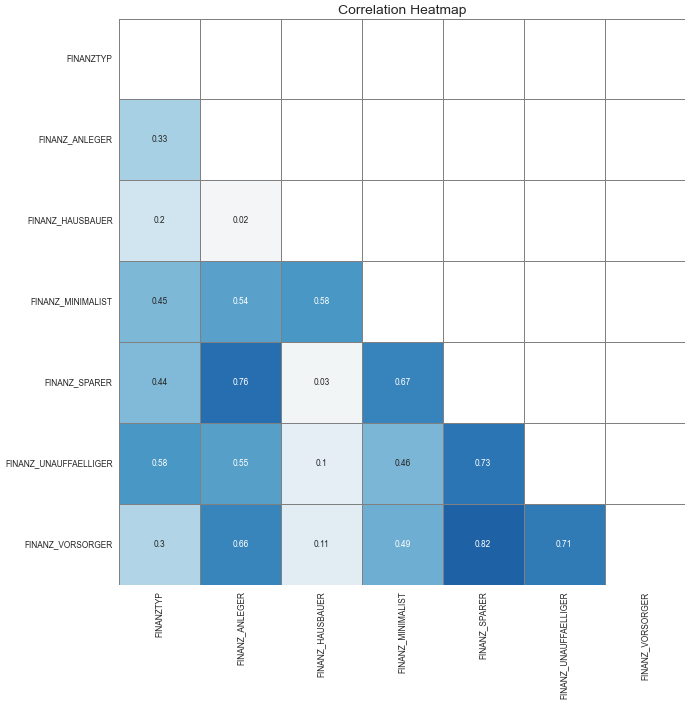

In [75]:
columns = ['FINANZTYP', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER']

# Create correlation matrix for just Features to determine different models to test
corr_matrix_xx = azdias_transformed[columns].corr().abs().round(2)

display_correlations(corr_matrix_xx, figsize=(15,15), dpi=50)

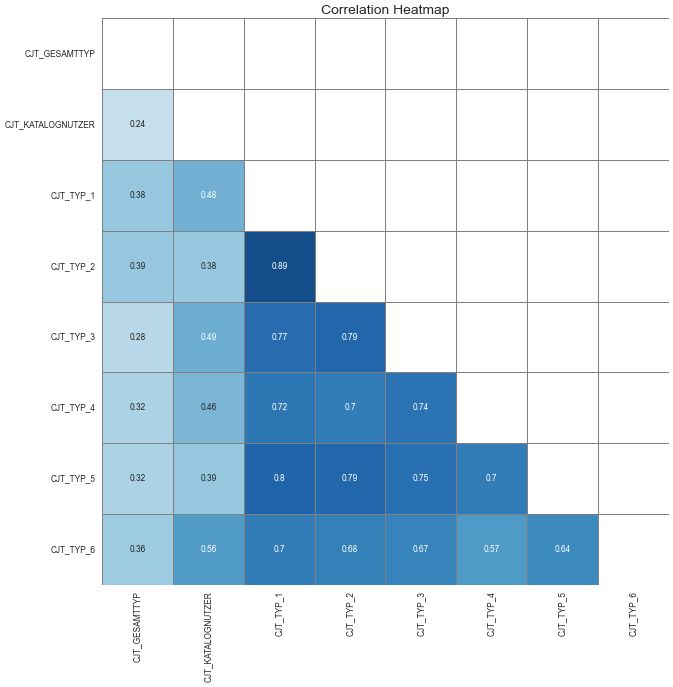

In [76]:
columns = ['CJT_GESAMTTYP', 'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6']

# Create correlation matrix for just Features to determine different models to test
corr_matrix_xx = azdias_transformed[columns].corr().abs().round(2)

display_correlations(corr_matrix_xx, figsize=(15, 15), dpi=50)

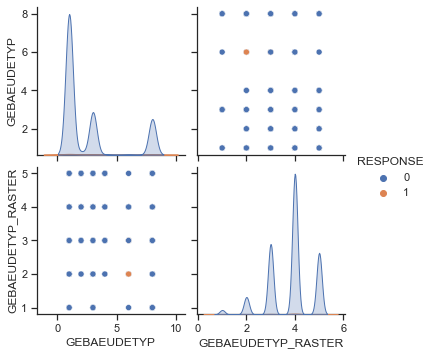

In [77]:
columns = ['GEBAEUDETYP', 'GEBAEUDETYP_RASTER']

columns.append('RESPONSE')
sns.set(style='ticks')
sns.pairplot(mailout_train[columns], hue='RESPONSE')
plt.show()

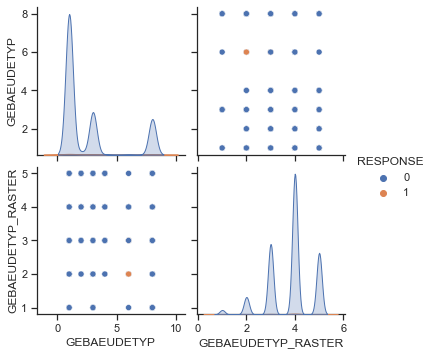

In [78]:
columns = ['GEBAEUDETYP', 'GEBAEUDETYP_RASTER']

# # Create correlation matrix for just Features to determine different models to test
# corr_matrix_xx = azdias_transformed[columns].corr().round(2)

# display_correlations(corr_matrix_xx, figsize=(10,10), dpi=50)


columns.append('RESPONSE')
sns.set(style='ticks')
sns.pairplot(mailout_train[columns], hue='RESPONSE')

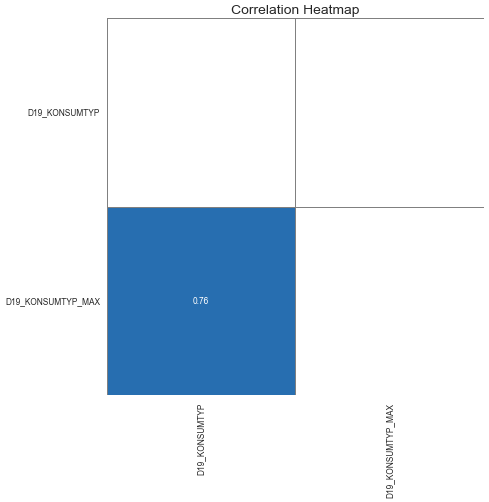

In [79]:
columns = ['D19_KONSUMTYP', 'D19_KONSUMTYP_MAX']
corr_matrix_xx = azdias_transformed[columns].corr().round(2)
display_correlations(corr_matrix_xx, figsize=(10,10), dpi=50)

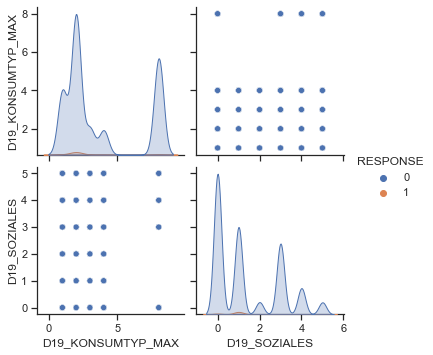

In [80]:
columns = ['D19_KONSUMTYP_MAX', 'D19_SOZIALES']

columns.append('RESPONSE')
sns.set(style='ticks')
sns.pairplot(mailout_train[columns], hue='RESPONSE')

too difficult to work out the meaning of D19_KONSUMTYP_MAX. Is the 2 fields are highly correlated means it contains similar information, therefore it should be ok to drop it.

The following field pairs are highly correlated and contain similar information. We can drop one of the fields
- ANZ_HAUSHALTE_ACTIV AND ANZ_STATISTISCHE_HAUSHALTE - Number of households in the building
  - the later is not in the levels or feature dataset mentioned, but I assume it's a statistical version of the actual field. I will drop the later
  
- CAMEO_DEUG_2015 and CAMEO_INTL_2015_WEALTH both describe upper to lower class, wealthy to poor households. There is a strong correlation of 0.97 between these to fields and I imagine both important.
Both have only 10% missing data. I will drop CAMEO_DEUG_2015
  
- EINGEFUEGT_AM, MIN_GEBAEUDEJAHR - date record was added and date the building was first recorded. 
  - I will keep MIN_GEBAEUDEJAHR as the first, also together EINGEZOGENAM_HH_JAHR, are not mentioned in the levels or features descriptions. They all contain around 10% missing data, so I assume it does not really matter
  
- PRAEGENDE_JUGENDJAHRE_DECADE and GEBURTSJAHR - both to do with age. One is at year level, other one at decade level which might be a good summary for clustering. 
 
- KOMBIALTER and GEBURTSJAHR - KOMBIALTER is not described in the features description, both fields seem to be mentioned in the feature importance analysis above in position 144 vs 124 irrespectively. I will drop GEBURTSJAHR as 40% data is missing and it does not impute well. 

- GEMEINDETYP and ORTSGR_KLS9 - first one is not described, but has a suspitions range of values [11, 12, 21 22, 30, 40, 50] it's difficult to tell what this could mean. It does not impute very well due it's min/max range, if we keep it we would have re-rank from 1-7. ORTSGR_KLS9 represent the size of population in the community. In customer feature analysis ORTSGR_KLS9 is ranked much higher I will thus drop GEMEINDETYP

- KBA13_HHZ and PLZ8_HHZ number of househoulds within a PLZ. As first field is not listed in features values, I will delete it

- KBA13_* and PLZ8_* both represent data on family houses at PLZ8 level. As KBA13 have missing level description of the ranges, I will drop those fields most of the time

- KBA13_ALTERHALTER* and KBA13_HALTER* both contains share of car owners within age ranges. ALTERHALTER is a summary, where HALTER is a finer range in 5 year ranges. As ALTERHALTER has the same age ranges as ALTERSKATEGORIE_GROB I will keep these fields instead.
  
- D19_KONSUMPTYP AND D19_KONSUMTYP_MAX - are both very important fields but are somehow highly correlated, not both is needed. I will keep D19_KONSUMPTYP for clustering as it is described and can help us understand the kind of people in each cluster. For 19_KONSUMTYP_MAX_2 over 300 people responded to the campaign so seem to have a lot of predictive power, I will keep MAX for supervised learning
    
- MOBI_REGIO and MOBI_RASTER, I will keep the first one for UNSUPERVISED and second for SUPERVISED   
  
- GEBAEAUTYPE AND GEBEAUTYP_RASTER seems to be related during clustering to have both fields does add much extra valule

- I suspect CJT_GESAMTTYP (values 1-6) was one-hot encoded into CJT_TYP_1 - CJT_TYP_6. I suspect ranking 1-5 within the sub-categories represent ranking high - low. I will drop CJT_GESAMTTYP at least I now know what is the sub-categories
  

I am leaving the rest of correlations, as it's not duplicate fields, but fields with genioun correlations which could potential used to fill missing values using machine learning

We can observe the following relationships:
  - We can observe above, if D19_* columns are missing, KBA05* columns are present and visa versa.
  - KKK AND REGIOTYP: If one is missing, the other one is also missing

<b>Household<b>

Columns analyze the number of transactions in different categories:
-    1) Banking (_BANKEN_)
-    2) Telecommunications (_TELKO_)
-    3) Insurance (_VERSI_)
-    4) Mail order (_VERSAND_)
-    5) All transactions ( includes all above ) (_GESAMT_)
    
Within each category we have 5 different columns describing the category, again a lot of information overlap
- _ANZ_12: all activity last 12 months
- _ANZ_24: all activity last 24 months
- _DATUM: total activity not time restricted - summary of above 2 fields

- _OFFLINE: breakdown of_DATUM describing offline transactions
- _ONLINE: breakdown of_DATUM describing online transactions

- _QUOTE_12: online transactions in last 12 months
- _QUOTE_24: online transactions in last 24 months

Generally the data in these transaction fields are nearly non-existent. Keep columns in categories VERSTAND and summary GESAMT, as these contain some data.

I will drop the totals fields _DATUM and keep in all categories the breakdown of _ONLINE and _OFFLINE 
I see also not a reason to keep ANZ_12 and ANZ24 as it's again just a breakdown of _DATUM. I will keep only GESAMT and VERSTAND categories for ANZ_12



<!-- _DATUM
1	highest activity within the last 12 months
2	very high activity within the last 12 months
3	high activity within the last 12 months
4	increased activity within the last 12 months
5	slightly increased activity within the last 12 months
6	activity elder than 1 year
7	activity elder than 1,5 years
8	activity elder than 2 years
9	activity elder than 3 years -->

<!-- _ONLINE and _OFFLINE
1	highest activity within the last 12 months
2	very high activity within the last 12 months
3	high activity within the last 12 months
4	increased activity within the last 12 months
5	slightly increased activity within the last 12 months
6	activity elder than 12 months
7	activity elder than 18 months
8	activity elder than 24 months
9	activity elder than 36 months
10	no transactions known -->

<!-- _ANT_12 AND ANZ_24
0	no transaction known
1	very low activity
2	low activity
3	slightly increased activity
4	increased activity
5	high activity
6	very high activity -->

<!-- _QUOTE_12 AND QUOTE_24
<!-- 0	no Online-transactions within the last 12 months
1	10% Online-transactions within the last 12 months
2	20% Online-transactions within the last 12 months
3	30% Online-transactions within the last 12 months
4	40% Online-transactions within the last 12 months
5	50% Online-transactions within the last 12 months
6	60% Online-transactions within the last 12 months
7	70% Online-transactions within the last 12 months
8	80% Online-transactions within the last 12 months
9	90% Online-transactions within the last 12 months
10	100% Online-transactions within the last 12 months --> 

<b>Family, Lifestyle and Status<b>

Keep the fields that split out age, status and income clearly and seperately meaning:

- ALTERSKATEGORIE_GROB (< 30 years, 30-45, 46-60, >60)
- LP_FAMILIE_GROB (single, couple, single parent, family, multiplerson household)
- LP_FAMILIE_FEIN (same as GROB but describe age of children young, teenage or full age. 
- LP_STATUS_GROB (low-income earners, average earners, independents, houseowners, top earners)
    

I will drop fields LB_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB as age, status an income are all mixed up together without a clear ranking.
ALTERSKATEGORIE_FEIN is not described in the features, and ALTERSKATEGORIE_GROB seems like a great breakdown.
ALTERSKATEGORIE_FEIN also seems to have the perfect linear relationship with GEBURSJAHR    
    
LP_STATUS_FEIN have a very high correlation with LP_STATUS_GROB, however I will keep the field as it gives a very concise idea of personality type with the GROB breakdown which might be helpful, example aspiring, independent, villagers, etc. During clustering I obsereved that GROB pops up as having the strongest correlations   

<a id='correlation_drop'></a>
### Build correlation drop configuration datasets

In [81]:
columns_to_drop = ['ANZ_STATISTISCHE_HAUSHALTE', 
                    'CAMEO_DEUG_2015',
                    'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
                    'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
                    'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_ONLINE_QUOTE_12',
                    'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
                    'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM', 'D19_VERSI_ONLINE_QUOTE_12',
                    'EINGEFUEGT_AM',
                    'GEBURTSJAHR', # correlate with ALTERSKATEGORIE_GROB and KOMBIALTER, 40% missing values does not impute well
                    'KBA13_HHZ', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3','KBA13_ANTG4', 
                    'KBA13_BAUMAX', 'KBA13_GBZ', 
                    'KBA13_HALTER_20', 'KBA13_HALTER_25','KBA13_HALTER_30', 'KBA13_HALTER_35', 'KBA13_HALTER_40', 
                    'KBA13_HALTER_45', 'KBA13_HALTER_50', 'KBA13_HALTER_55', 'KBA13_HALTER_60', 'KBA13_HALTER_65', 
                    'KBA13_HALTER_66',  
                    'LP_LEBENSPHASE_GROB', 
                    'LP_LEBENSPHASE_FEIN',  
                    'LP_FAMILIE_FEIN',
                    'LP_STATUS_FEIN',
                    'ALTERSKATEGORIE_FEIN',
                    'FINANZTYP', 
                    'GEMEINDETYP', 
                    'CJT_GESAMTTYP',
                    'GEBEAUTYP_RASTER',
                    'D19_KONSUMTYP_MAX',
                    'D19_MOBI_RASTER',
                    'KBA05_BAUMAX',
#                     'FINANZ_ANLEGER',
#                     'FINANZ_HAUSBAUER',
#                     'FINANZ_MINIMALIST',
#                     'FINANZ_SPARER',
#                     'FINANZ_UNAUFFAELLIGER',
#                     'FINANZ_VORSORGER',
                  ]

columns_to_drop_unsupervised = set(columns_to_drop)

In [82]:
columns_to_drop_supervised = [
        'ANZ_STATISTISCHE_HAUSHALTE',
        'CAMEO_DEUG_2015',
        'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
        'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
        'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_ONLINE_QUOTE_12',
        'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM',
        'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM', 'D19_VERSI_ONLINE_QUOTE_12',
        'EINGEFUEGT_AM',
        'GEBURTSJAHR', # correlated with KOMBIALTER, 40% missing values does not impute well
        'KBA13_HHZ', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3','KBA13_ANTG4', 
        'KBA13_BAUMAX', 'KBA13_GBZ', 
        'KBA13_HALTER_20', 'KBA13_HALTER_25','KBA13_HALTER_30', 'KBA13_HALTER_35', 'KBA13_HALTER_40', 
        'KBA13_HALTER_45', 'KBA13_HALTER_50', 'KBA13_HALTER_55', 'KBA13_HALTER_60', 'KBA13_HALTER_65', 
        'KBA13_HALTER_66',  
        'LP_LEBENSPHASE_GROB',   
        'LP_LEBENSPHASE_FEIN', # strong correlation LEBENSPHASE_GROS/FEIN, FAMILIE_GROS/FEIN keep FAMILIE_FEIN
        'LP_FAMILIE_FEIN',
        'LP_STATUS_FEIN',
        'ALTERSKATEGORIE_FEIN',
        'D19_KONSUMTYP', #_MAX_2 is better for prediction see comment                         
        'FINANZTYP', # other dummy fields exists which is a breakdown of this field already
        'GEMEINDETYP',
        'CJT_GESAMTTYP',
        'GEBEAUTYP_RASTER',
        'D19_MOBI_REGIO',
        'KBA05_BAUMAX',
#         'FINANZ_ANLEGER',
#         'FINANZ_HAUSBAUER',
#         'FINANZ_MINIMALIST',
#         'FINANZ_SPARER',
#         'FINANZ_UNAUFFAELLIGER',
#         'FINANZ_VORSORGER',
]

In [83]:
# compile supervised drop list, by taking unsupervised drop list but remove protected features we want to keep
# columns_to_drop_supervised = columns_to_drop_unsupervised.copy()
columns_to_remove = [col for col in columns_to_drop_supervised if col in columns_to_keep]
# print('Removing protected columns {} from the SUPERVISED drop list'.format(columns_to_remove))
for col in columns_to_remove:
    print('Warning: {} shown to be an important field'.format(col))
#     columns_to_drop_supervised.remove(col)
    
# print('\nNumber of additional columns to be dropped for SUPERVISED: {}'.format(len(columns_to_drop_supervised)))
# print('\nColumns to drop: {}'.format(columns_to_drop_supervised))    

In [84]:
# update numerical columns
numerical_columns = [col for col in numerical_columns if not col in columns_to_drop_missing]
numerical_columns = [col for col in numerical_columns if not col in columns_to_drop_supervised]
numerical_columns

['KBA13_ANZAHL_PKW',
 'ANZ_HAUSHALTE_AKTIV',
 'VERDICHTUNGSRAUM',
 'EINGEZOGENAM_HH_JAHR',
 'MIN_GEBAEUDEJAHR',
 'ANZ_PERSONEN',
 'ANZ_KINDER',
 'ANZ_HH_TITEL']

In [85]:
# create csv files with all columns that was selected to be dropped to be stored as config files

# make data dir, if it does not exist
if not os.path.exists(path_config):
    os.makedirs(path_config)
                              
pd.DataFrame(columns_to_drop_missing).to_csv(config.filename_drop_missing, header=None, index=False)
pd.DataFrame(columns_to_drop_supervised).to_csv(config.filename_drop_corr_supervised, header=None, index=False)
pd.DataFrame(columns_to_drop_unsupervised).to_csv(config.filename_drop_corr_unsupervised, header=None, index=False)

# write to S3
# path = '{}/{}'.format(prefix, path_config)
# input_data = sagemaker_session.upload_data(path=config.filename_drop, bucket=bucket, key_prefix=path)
# print('File saved to location: {}'.format(input_data))

Analysis to understand ranking of 'CJT_TYP_2' fields

We know that CJT_TYP_2 and CJT_TYP_5 are least correlated. 

In [86]:
test = azdias_transformed[azdias_transformed['CJT_GESAMTTYP'] == 1]
test['CJT_TYP_2'].value_counts().sort_index()

1.0    27286
2.0    38754
3.0    12300
4.0     9453
5.0     4573
Name: CJT_TYP_2, dtype: int64

In [87]:
test['CJT_TYP_5'].value_counts().sort_index()

1.0     9713
2.0     3810
3.0    11195
4.0    15538
5.0    52110
Name: CJT_TYP_5, dtype: int64

<a id='impute'></a>
# Step 5: Impute missing values using machine learning

Use ML to impute missing values based on other features

In [88]:
azdias_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 791246 entries, 910220 to 825787
Columns: 386 entries, AKT_DAT_KL to D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
dtypes: float64(274), int64(78), uint8(34)
memory usage: 2.1 GB


In [89]:
# azdias_transformed = reduce_mem_usage(azdias_transformed)

azdias_transformed = azdias_transformed.astype('float32', errors='raise', copy=False)
azdias_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 791246 entries, 910220 to 825787
Columns: 386 entries, AKT_DAT_KL to D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
dtypes: float32(386)
memory usage: 1.1 GB


In [90]:
# Use simple imputer as baseline
azdias_imputed_simple_most = simple_imputer(azdias_transformed.copy(), 
                                            columns=azdias_transformed.columns, 
                                            strategy='most_frequent')

# override numerical columns
azdias_imputed_simple_mean = simple_imputer(azdias_imputed_simple_most,
                                            columns=numerical_columns, 
                                            strategy='mean')

When running for the first time or change are made in columns dropped, uncomment and run imputer

In [91]:
# # Impute numerical fields with default strategy mean
# imputer_mean = fit_imputer(azdias_transformed.copy(deep=True),
#                                  tolerance=0.001, 
#                                  verbose=2, 
#                                  max_iter=15, 
#                                  nearest_features=50,
#                                  imputation_order='descending',
#                                  initial_strategy='mean')

In [92]:
# # Impute numerical fields with default strategy mean
# imputer_most = fit_imputer(azdias_transformed.copy(deep=True),
#                                  tolerance=0.01, 
#                                  verbose=2, 
#                                  max_iter=15, 
#                                  nearest_features=50,
#                                  imputation_order='descending',
#                                  initial_strategy='most_frequent')

In [93]:
# dump(imputer_mean, open(config.filename_imputer_mean, 'wb'))
# dump(imputer_most, open(config.filename_imputer_most, 'wb'))

In [94]:
# load back the fitted imputer
imputer_mean = load(open(config.filename_imputer_mean, 'rb'))
imputer_most = load(open(config.filename_imputer_most, 'rb'))

In [95]:
# Impute numeric data
azdias_imputed_iterative_mean = azdias_transformed.copy(deep=True)
azdias_imputed_iterative_mean.iloc[:, :] = imputer_mean.transform(azdias_imputed_iterative_mean)

[IterativeImputer] Completing matrix with shape (791246, 386)
[IterativeImputer] Ending imputation round 1/15, elapsed time 12.74
[IterativeImputer] Ending imputation round 2/15, elapsed time 25.59
[IterativeImputer] Ending imputation round 3/15, elapsed time 38.44
[IterativeImputer] Ending imputation round 4/15, elapsed time 51.33
[IterativeImputer] Ending imputation round 5/15, elapsed time 64.01
[IterativeImputer] Ending imputation round 6/15, elapsed time 76.64
[IterativeImputer] Ending imputation round 7/15, elapsed time 89.36
[IterativeImputer] Ending imputation round 8/15, elapsed time 102.05
[IterativeImputer] Ending imputation round 9/15, elapsed time 114.66
[IterativeImputer] Ending imputation round 10/15, elapsed time 127.27
[IterativeImputer] Ending imputation round 11/15, elapsed time 139.85
[IterativeImputer] Ending imputation round 12/15, elapsed time 152.62
[IterativeImputer] Ending imputation round 13/15, elapsed time 165.10
[IterativeImputer] Ending imputation round 1

In [96]:
# Impute categorial and ordinal data
azdias_imputed_iterative_most = azdias_transformed.copy(deep=True)
azdias_imputed_iterative_most.iloc[:, :] = imputer_most.transform(azdias_imputed_iterative_most)

[IterativeImputer] Completing matrix with shape (791246, 386)
[IterativeImputer] Ending imputation round 1/15, elapsed time 13.24
[IterativeImputer] Ending imputation round 2/15, elapsed time 26.15
[IterativeImputer] Ending imputation round 3/15, elapsed time 39.09
[IterativeImputer] Ending imputation round 4/15, elapsed time 52.09
[IterativeImputer] Ending imputation round 5/15, elapsed time 65.06
[IterativeImputer] Ending imputation round 6/15, elapsed time 78.02
[IterativeImputer] Ending imputation round 7/15, elapsed time 90.94
[IterativeImputer] Ending imputation round 8/15, elapsed time 103.91
[IterativeImputer] Ending imputation round 9/15, elapsed time 116.84
[IterativeImputer] Ending imputation round 10/15, elapsed time 129.77
[IterativeImputer] Ending imputation round 11/15, elapsed time 142.67
[IterativeImputer] Ending imputation round 12/15, elapsed time 155.57
[IterativeImputer] Ending imputation round 13/15, elapsed time 168.48
[IterativeImputer] Ending imputation round 1

In [97]:
azdias_imputed_iterative = azdias_imputed_iterative_most.copy(deep=True)
azdias_imputed_iterative[numerical_columns] = azdias_imputed_iterative_mean[numerical_columns]

In [98]:
# convert all columns from float to integer but round first and reduce memory again
azdias_imputed_iterative = azdias_imputed_iterative.round(0).astype(np.int16, copy=False, errors='raise')     

In [99]:
# check all columns are now integers
azdias_imputed_iterative.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 791246 entries, 910220 to 825787
Columns: 386 entries, AKT_DAT_KL to D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
dtypes: int16(386)
memory usage: 588.6 MB


In [100]:
azdias_imputed_iterative = outlier_correcter(['GEBURTSJAHR', 'EINGEZOGENAM_HH_JAHR'], azdias_imputed_iterative)

####  Lets compare the results of usings ML to impute vs SimpleImputer

Aggregate statistic to compute in each bin.
- count: show the number of observations in each bin
- frequency: show the number of observations divided by the bin width
- probability: or proportion: normalize such that bar heights sum to 1
- percent: normalize such that bar heights sum to 100
- density: normalize such that the total area of the histogram equals 1

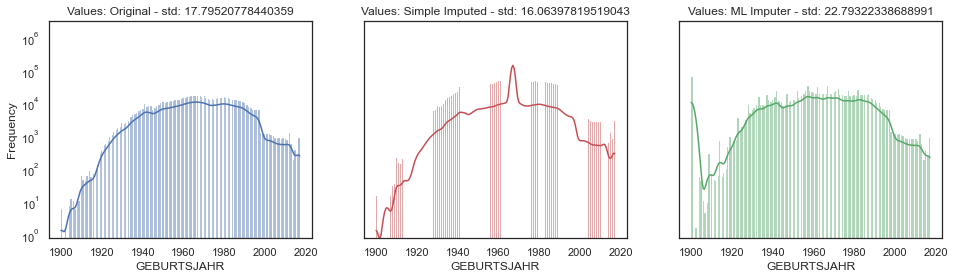

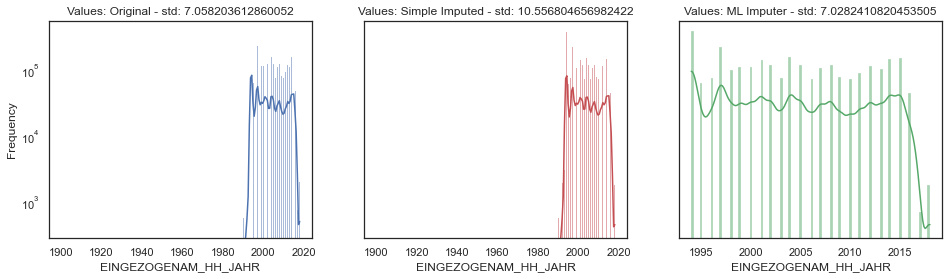

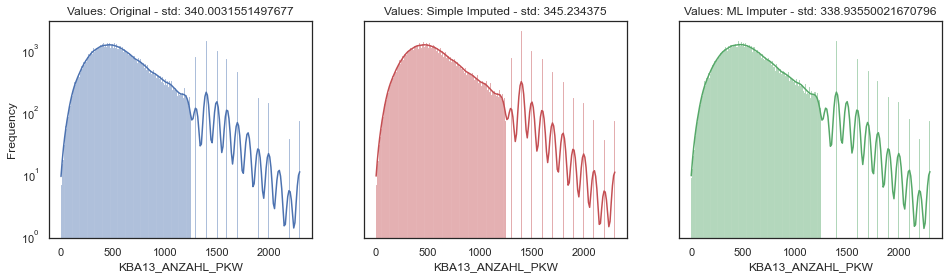

In [101]:
col = ['GEBURTSJAHR', 'EINGEZOGENAM_HH_JAHR', 'KBA13_ANZAHL_PKW']

compare_distributions_3by3(df1=azdias, 
                           df2=azdias_imputed_simple_mean, 
                           df3=azdias_imputed_iterative,
                           columns=col,
                           kde=True,
                           sharex=False,
                           sharey=True,
                           stat='frequency',
                           logscale=True,
                           titles=['Values: Original', 'Values: Simple Imputed', 'Values: ML Imputer'])

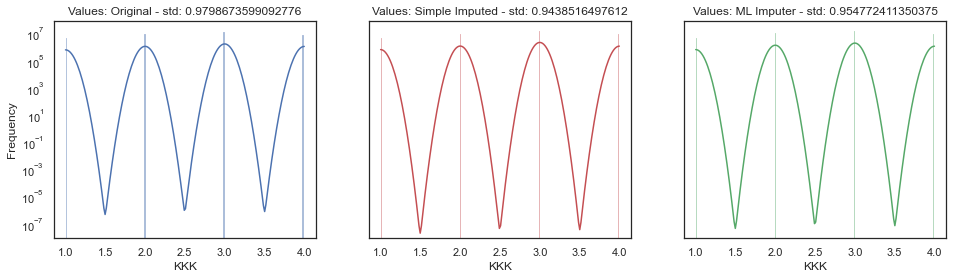

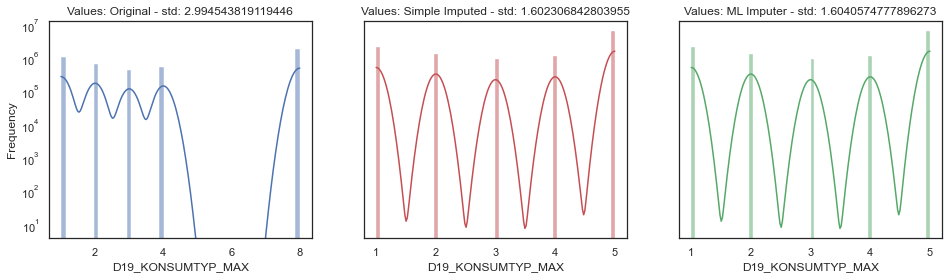

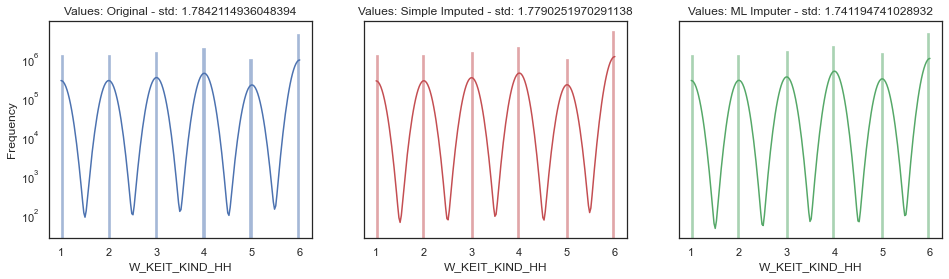

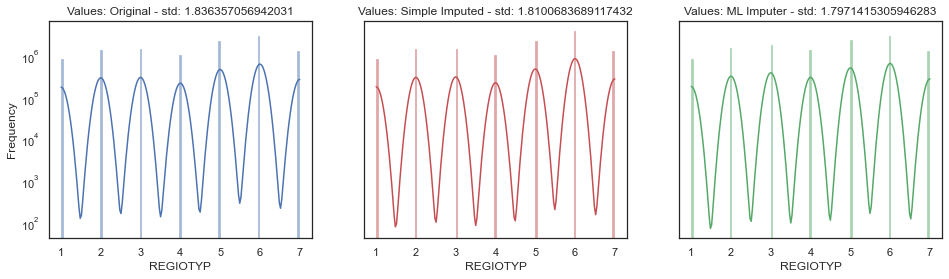

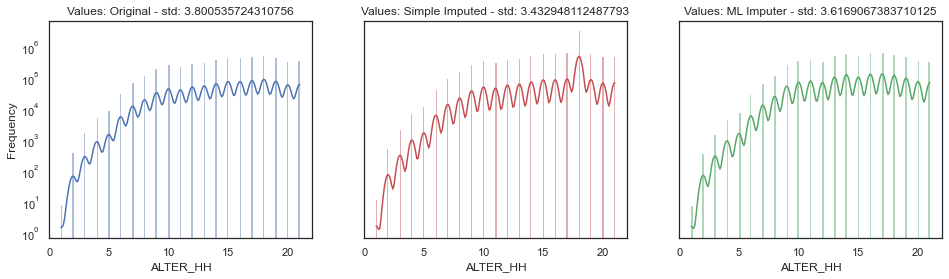

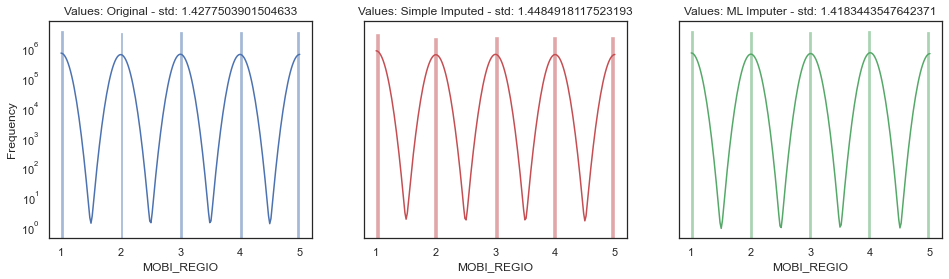

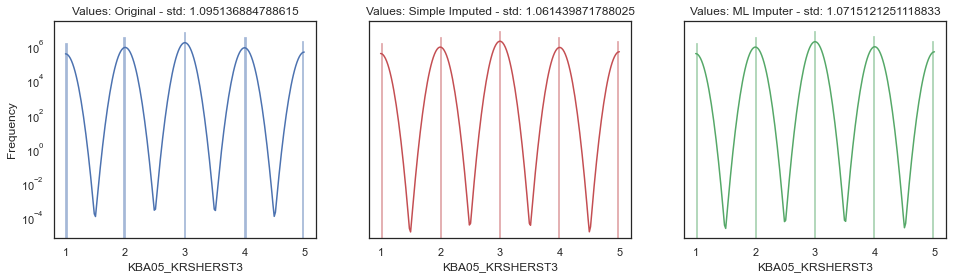

In [102]:
col = ['KKK', 'D19_KONSUMTYP_MAX', 'W_KEIT_KIND_HH', 'REGIOTYP', 'ALTER_HH', 'MOBI_REGIO', 'KBA05_KRSHERST3']

compare_distributions_3by3(df1=azdias, 
                           df2=azdias_imputed_simple_most, 
                           df3=azdias_imputed_iterative,
                           columns=col,
                           kde=True,
                           sharex=False,
                           sharey=True,
                           stat='frequency',
                           logscale=True,
                           titles=['Values: Original', 'Values: Simple Imputed', 'Values: ML Imputer'])

### Final preparations

Additional OHN after imputing
Different fields will be dropped for supervised vs unsupervised


For Unsupervised, drop the 'FEIN' fields and keep the summary fields as it seems to work well for clustering
For Supervised, the FEIN fields seem to work better to predict mailout responders

In [103]:
# fields to drop for both supervised  
azdias_supervised = azdias_imputed_iterative.copy()
columns_to_drop = get_columns(filename_drop_corr_supervised)  
print('Columns to drop {}'.format(columns_to_drop))
azdias_supervised.drop(columns_to_drop, inplace=True, errors='ignore', axis=1)
azdias_supervised.shape

Columns to drop ['ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_DEUG_2015', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_DATUM', 'D19_VERSI_ONLINE_QUOTE_12', 'EINGEFUEGT_AM', 'GEBURTSJAHR', 'KBA13_HHZ', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_BAUMAX', 'KBA13_GBZ', 'KBA13_HALTER_20', 'KBA13_HALTER_25', 'KBA13_HALTER_30', 'KBA13_HALTER_35', 'KBA13_HALTER_40', 'KBA13_HALTER_45', 'KBA13_HALTER_50', 'KBA13_HALTER_55', 'KBA13_HALTER_60', 'KBA13_HALTER_65', 'KBA13_HALTER_66', 'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'ALTERSKATEGORIE_FEIN', 'D19_KONSUMTYP', 'FINANZTYP', 'GEMEINDETYP', 'CJT_GESAMTTYP', 'GEBEAUTYP_RAST

(791246, 338)

In [104]:
# fields to drop for only unsupervised
azdias_unsupervised = azdias_imputed_iterative.copy()
columns_to_drop = get_columns(filename_drop_corr_unsupervised)  
print('Columns to drop {}'.format(columns_to_drop))
azdias_unsupervised.drop(columns_to_drop, inplace=True, errors='ignore', axis=1)
azdias_unsupervised.shape

Columns to drop ['D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_OFFLINE_DATUM', 'FINANZTYP', 'LP_FAMILIE_FEIN', 'ALTERSKATEGORIE_FEIN', 'KBA13_HALTER_50', 'GEBURTSJAHR', 'KBA13_HALTER_35', 'D19_KONSUMTYP_MAX', 'D19_VERSI_ONLINE_QUOTE_12', 'LP_LEBENSPHASE_GROB', 'D19_TELKO_ANZ_12', 'KBA13_ANTG1', 'D19_TELKO_DATUM', 'D19_BANKEN_ANZ_24', 'D19_VERSAND_ANZ_24', 'LP_STATUS_FEIN', 'D19_GESAMT_ANZ_24', 'CAMEO_DEUG_2015', 'GEMEINDETYP', 'KBA13_ANTG2', 'KBA13_HALTER_40', 'KBA13_HALTER_30', 'KBA13_HALTER_66', 'CJT_GESAMTTYP', 'KBA13_ANTG4', 'LP_LEBENSPHASE_FEIN', 'KBA13_HHZ', 'GEBEAUTYP_RASTER', 'D19_BANKEN_ANZ_12', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_ANZ_24', 'ANZ_STATISTISCHE_HAUSHALTE', 'KBA05_BAUMAX', 'D19_BANKEN_DATUM', 'KBA13_HALTER_60', 'D19_VERSAND_DATUM', 'D19_VERSI_ANZ_24', 'KBA13_BAUMAX', 'KBA13_HALTER_55', 'D19_VERSI_DATUM', 'KBA13_GBZ', 'D19_GESAMT_ONLINE_DATUM', 'EINGEFUEGT_AM', 'KBA13_ANTG3', 'KBA13_HALTER_25', 'KBA13_HALTER_45', 'D19_GESAMT_DATUM', 'D19_MOBI_RASTER', 'D19_VERSI_ANZ

(791246, 338)

In [105]:
azdias_supervised = ohn_additional(azdias_supervised.copy())
azdias_supervised.shape

Additional columns to one hot encode: ['GFK_URLAUBERTYP', 'HEALTH_TYP', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'SOHO_KZ', 'VERS_TYP', 'GEBAEUDETYP', 'KBA05_MAXHERST', 'D19_KONSUMTYP_MAX', 'D19_SOZIALES', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'ALTERSKATEGORIE_GROB', 'PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT', 'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFESTAGE', 'MOBI_REGIO', 'PLZ8_BAUMAX', 'GRID_BUYER_TYPE', 'GRID_YEAR_LAST_ACTIVE']
338 total features BEFORE one-hot encoding
421 total features AFTER one-hot encoding


(791246, 421)

In [106]:
azdias_unsupervised = ohn_additional(azdias_unsupervised.copy())
azdias_unsupervised.shape

Additional columns to one hot encode: ['GFK_URLAUBERTYP', 'HEALTH_TYP', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'SOHO_KZ', 'VERS_TYP', 'GEBAEUDETYP', 'KBA05_MAXHERST', 'D19_KONSUMTYP', 'D19_SOZIALES', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'ALTERSKATEGORIE_GROB', 'PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT', 'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFESTAGE', 'MOBI_REGIO', 'PLZ8_BAUMAX', 'GRID_BUYER_TYPE', 'GRID_YEAR_LAST_ACTIVE']
338 total features BEFORE one-hot encoding
423 total features AFTER one-hot encoding


(791246, 423)

<a id='test_cleaning_function'></a>
# Step 6: Testing clean function

In [107]:
# Re-import the data
path = "{}/{}".format(path_raw, config.filename_demographics)
azdias, azdias_extended_na = get_data(path)

### 6.1 Supervised

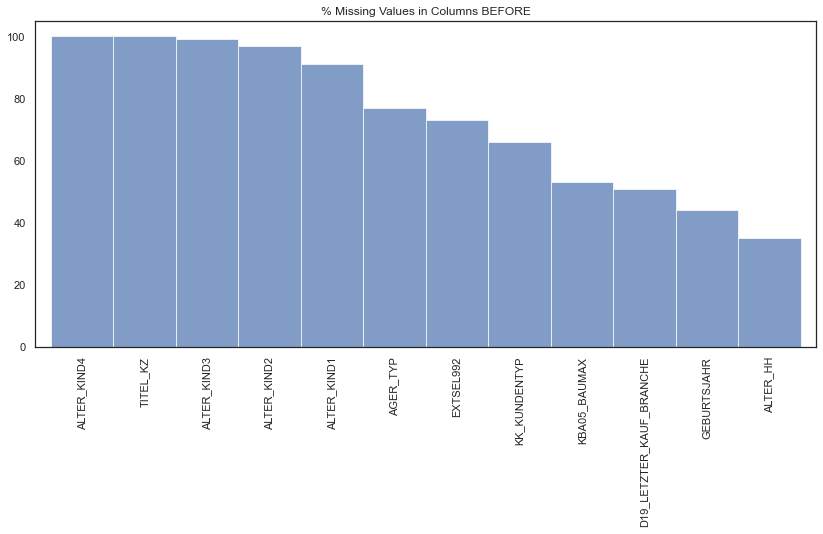

Summarize GRID columns.....
Binarize GRID columns.....

Columns dropped due to missing values ['EXTSEL992', 'D19_TELKO_MOBILE', 'D19_SCHUHE', 'D19_VERSAND_REST', 'AGER_TYP', 'TITEL_KZ', 'D19_HAUS_DEKO', 'ALTER_KIND2', 'ALTER_KIND1', 'D19_RATGEBER', 'D19_BEKLEIDUNG_GEH', 'CAMEO_DEU_2015', 'D19_TELKO_ONLINE_QUOTE_12', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_BANKEN_GROSS', 'KK_KUNDENTYP', 'ALTER_KIND4', 'ALTER_KIND3', 'D19_FREIZEIT']


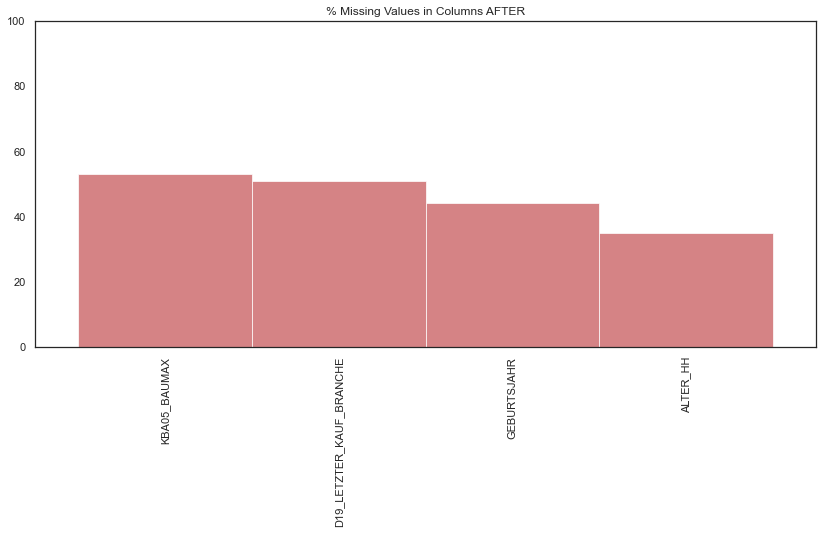

Shape BEFORE row deletion: (891221, 348)


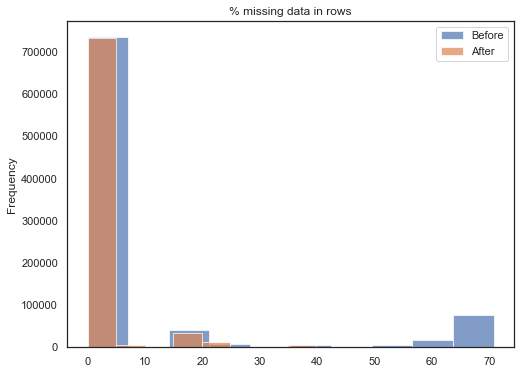

Shape AFTER row deletion: (791246, 348) with threshold of: 0.5
Adding few features WOHNLAGE_QUALITY and WOHNLAGE_RURAL ..........
Adding few features PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT ..........
Adding few features CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFESTAGE ..........
Cleaning PLZ8_BAUMAX, KBA05_BAUMAX .......... 
Cleaning OST_WEST_KZ .......... 
Reducing range for D19_KONSUMTYP_MAX from 1-8 to 1-5
Reducing range for D19_KONSUMTYP from 1-9 to 1-7
Rerank ranges for banking transactions
Categorial columns to one hot encode: ['D19_LETZTER_KAUF_BRANCHE']
353 total features BEFORE one-hot encoding
386 total features AFTER one-hot encoding
[IterativeImputer] Completing matrix with shape (791246, 386)
[IterativeImputer] Ending imputation round 1/15, elapsed time 22.36
[IterativeImputer] Ending imputation round 2/15, elapsed time 43.94
[IterativeImputer] Ending imputation round 3/15, elapsed time 65.81
[IterativeImputer] Ending imputation round 4/15, ela

In [108]:
# test if clean function is working same as above results
azdias_supervised = clean(azdias.copy(), 
                          azdias_extended_na, 
                          rows_threshold=0.5, 
                          impute=True,
                          kind='supervised')

In [109]:
azdias_supervised.shape

(791246, 421)

In [110]:
azdias_supervised.head()

AKT_DAT_KL  ALTER_HH  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
LNR                                                                           
910220           9        19                   11             0           0   
910225           9        17                   10             0           0   
910226           1        13                    1             0           0   
910241           1        20                    3             0           0   
910244           1        10                    5             0           0   

        ANZ_PERSONEN  ANZ_TITEL  ARBEIT  BALLRAUM  CJT_KATALOGNUTZER  \
LNR                                                                    
910220             2          0       3         6                  1   
910225             1          0       3         2                  2   
910226             0          0       2         4                  3   
910241             4          0       4         2                  3   
910244             1          0       2         6                  5   

        CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  \
LNR                                                                        
910220          5          5          2          3          1          1   
910225          4          4          1          3          2          2   
910226          2          2          4          4          5          3   
910241          3          3          3          4          3          3   
910244          2          1          5          5          3          3   

        D19_BANKEN_DIREKT  D19_BANKEN_LOKAL  D19_BANKEN_OFFLINE_DATUM  \
LNR                                                                     
910220                  0                 0                         0   
910225                  0                 0                         0   
910226                  0                 0                         0   
910241                  1                 0                         0   
910244                  0                 0                         0   

        D19_BANKEN_ONLINE_DATUM  D19_BANKEN_REST  D19_BEKLEIDUNG_REST  \
LNR                                                                     
910220                        0                0                    0   
910225                        0                0                    0   
910226                        0                0                    0   
910241                        5                1                    1   
910244                        0                0                    0   

        D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  D19_DIGIT_SERV  \
LNR                                                              
910220            0             0            0               0   
910225            1             0            0               0   
910226            0             0            1               0   
910241            1             0            1               0   
910244            0             0            0               0   

        D19_DROGERIEARTIKEL  D19_ENERGIE  D19_GARTEN  D19_GESAMT_ANZ_12  \
LNR                                                                       
910220                    0            0           0                  0   
910225                    0            0           0                  0   
910226                    0            0           0                  0   
910241                    1            1           0                  6   
910244                    0            1           0                  1   

        D19_GESAMT_ONLINE_QUOTE_12  D19_HANDWERK  D19_KINDERARTIKEL  \
LNR                                                                   
910220                           0             0                  0   
910225                           0             0                  0   
910226                           0             0                  0   
910241                          10             0

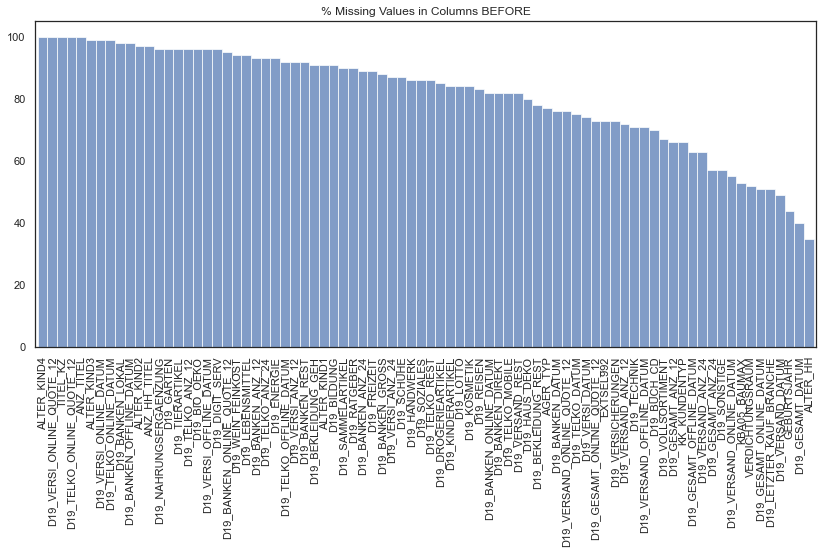

Summarize GRID columns.....
Binarize GRID columns.....

Columns dropped due to missing values ['EXTSEL992', 'D19_TELKO_MOBILE', 'D19_SCHUHE', 'D19_VERSAND_REST', 'AGER_TYP', 'TITEL_KZ', 'D19_HAUS_DEKO', 'ALTER_KIND2', 'ALTER_KIND1', 'D19_RATGEBER', 'D19_BEKLEIDUNG_GEH', 'CAMEO_DEU_2015', 'D19_TELKO_ONLINE_QUOTE_12', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_BANKEN_GROSS', 'KK_KUNDENTYP', 'ALTER_KIND4', 'ALTER_KIND3', 'D19_FREIZEIT']


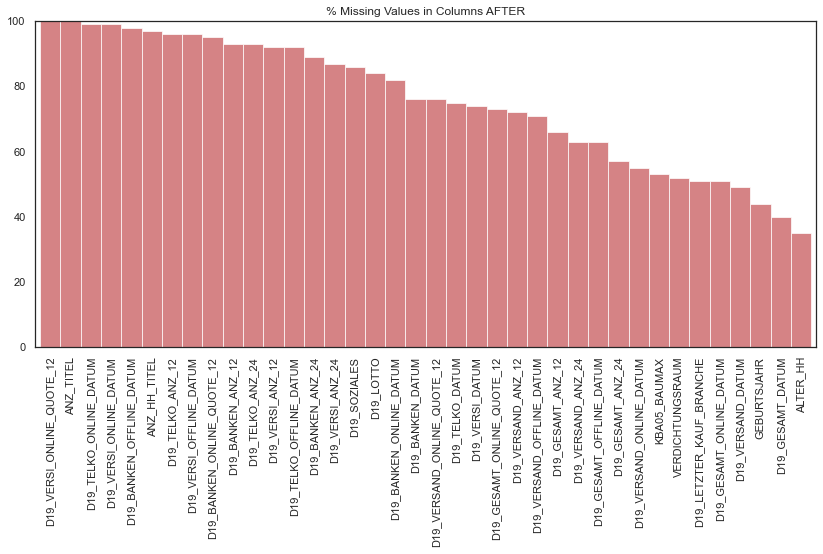

Shape BEFORE row deletion: (891221, 348)


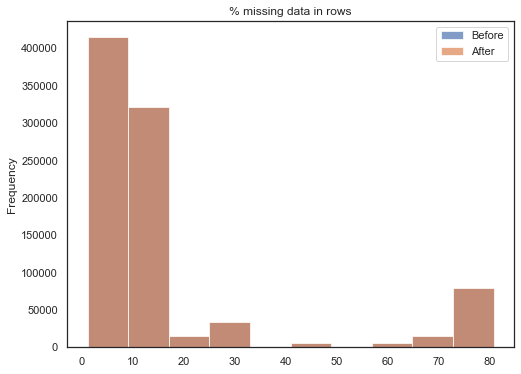

Shape AFTER row deletion: (891221, 348) with threshold of: 1
Adding few features WOHNLAGE_QUALITY and WOHNLAGE_RURAL ..........
Adding few features PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT ..........
Adding few features CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFESTAGE ..........
Cleaning PLZ8_BAUMAX, KBA05_BAUMAX .......... 
Cleaning OST_WEST_KZ .......... 
Reducing range for D19_KONSUMTYP_MAX from 1-8 to 1-5
Reducing range for D19_KONSUMTYP from 1-9 to 1-7
Rerank ranges for banking transactions
Categorial columns to one hot encode: ['D19_LETZTER_KAUF_BRANCHE']
353 total features BEFORE one-hot encoding
386 total features AFTER one-hot encoding
/nIMPORTANT: Not possible to convert datatypes to integer as they contain NaN

Drop additional correlated columns ['ANZ_STATISTISCHE_HAUSHALTE', 'CAMEO_DEUG_2015', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DAT

In [111]:
# Test if clean function is working same as above results. 
# We clean a second time to build a dataset we will use for scaling
# All missing values are np.nan and data are not yet imputed
azdias_supervised_na = clean(azdias_extended_na.copy(), 
                             azdias_extended_na, 
                             rows_threshold=1, 
                             impute=False,
                             kind='supervised')

In [112]:
azdias_supervised_na.shape

(891221, 420)

In [113]:
azdias_supervised_na.head()

AKT_DAT_KL  ALTER_HH  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
LNR                                                                           
910215         NaN       NaN                  NaN           NaN         NaN   
910220         9.0       NaN                 11.0           NaN         0.0   
910225         9.0      17.0                 10.0           NaN         0.0   
910226         1.0      13.0                  1.0           NaN         0.0   
910241         1.0      20.0                  3.0           NaN         0.0   

        ANZ_PERSONEN  ANZ_TITEL  ARBEIT  BALLRAUM  CJT_KATALOGNUTZER  \
LNR                                                                    
910215           NaN        NaN     NaN       NaN                5.0   
910220           2.0        NaN     3.0       6.0                1.0   
910225           1.0        NaN     3.0       2.0                2.0   
910226           NaN        NaN     2.0       4.0                3.0   
910241           4.0        NaN     4.0       2.0                3.0   

        CJT_TYP_1  CJT_TYP_2  CJT_TYP_3  CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  \
LNR                                                                        
910215        1.0        1.0        5.0        5.0        5.0        5.0   
910220        5.0        5.0        2.0        3.0        1.0        1.0   
910225        4.0        4.0        1.0        3.0        2.0        2.0   
910226        2.0        2.0        4.0        4.0        5.0        3.0   
910241        3.0        3.0        3.0        4.0        3.0        3.0   

        D19_BANKEN_DIREKT  D19_BANKEN_LOKAL  D19_BANKEN_OFFLINE_DATUM  \
LNR                                                                     
910215                  0                 0                       NaN   
910220                  0                 0                       NaN   
910225                  0                 0                       NaN   
910226                  0                 0                       NaN   
910241                  1                 0                       NaN   

        D19_BANKEN_ONLINE_DATUM  D19_BANKEN_REST  D19_BEKLEIDUNG_REST  \
LNR                                                                     
910215                      NaN                0                    0   
910220                      NaN                0                    0   
910225                      NaN                0                    0   
910226                      NaN                0                    0   
910241                      5.0                1                    1   

        D19_BILDUNG  D19_BIO_OEKO  D19_BUCH_CD  D19_DIGIT_SERV  \
LNR                                                              
910215            0             0            0               0   
910220            0             0            0               0   
910225            1             0            0               0   
910226            0             0            1               0   
910241            1             0            1               0   

        D19_DROGERIEARTIKEL  D19_ENERGIE  D19_GARTEN  D19_GESAMT_ANZ_12  \
LNR                                                                       
910215                    0            0           0                NaN   
910220                    0            0           0                NaN   
910225                    0            0           0                NaN   
910226                    0            0           0                NaN   
910241                    1            1           0                6.0   

        D19_GESAMT_ONLINE_QUOTE_12  D19_HANDWERK  D19_KINDERARTIKEL  \
LNR                                                                   
910215                         NaN             0                  0   
910220                         NaN             0                  0   
910225                         NaN             0                  0   
910226                         NaN             0

In [114]:
# Check that imputing and ohn did notresult in different column headings
list(set(azdias_supervised_na.columns) - set(azdias_supervised.columns))  

[]

In [115]:
# Check that imputing and ohn did notresult in different column headings
list(set(azdias_supervised.columns) - set(azdias_supervised_na.columns))  

['D19_SOZIALES_0']

In [116]:
# D19_SOZIALES_0 contains only missing values therefore it's absent from *_na dataset. 
# Manually add it back just to generate the scaler there's no other purpose
# Scaler require fit and transform columns to be in the same order
loc = azdias_supervised.columns.get_loc("D19_SOZIALES_0")
loc

365

In [117]:
azdias_supervised_na.insert(loc, column='D19_SOZIALES_0', value=azdias_supervised['D19_SOZIALES_0'])

### 6.2 Unsupervised

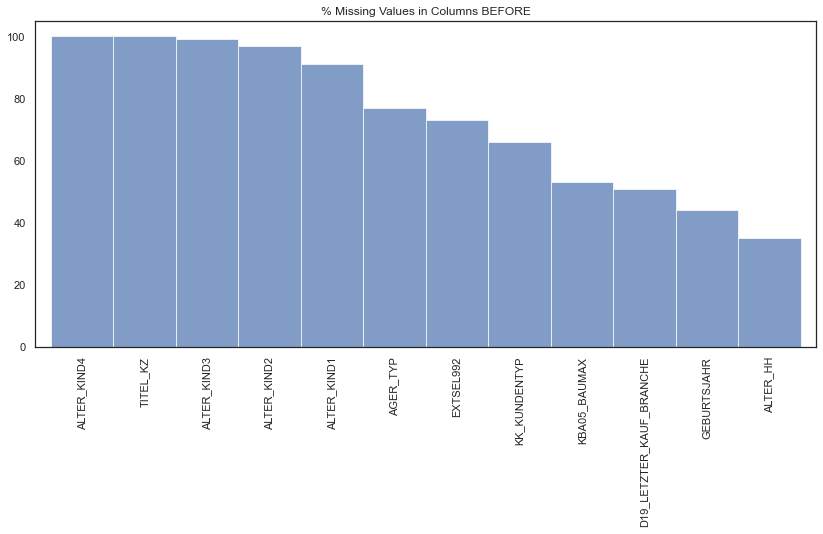

Summarize GRID columns.....
Binarize GRID columns.....

Columns dropped due to missing values ['EXTSEL992', 'D19_TELKO_MOBILE', 'D19_SCHUHE', 'D19_VERSAND_REST', 'AGER_TYP', 'TITEL_KZ', 'D19_HAUS_DEKO', 'ALTER_KIND2', 'ALTER_KIND1', 'D19_RATGEBER', 'D19_BEKLEIDUNG_GEH', 'CAMEO_DEU_2015', 'D19_TELKO_ONLINE_QUOTE_12', 'ANZ_STATISTISCHE_HAUSHALTE', 'D19_BANKEN_GROSS', 'KK_KUNDENTYP', 'ALTER_KIND4', 'ALTER_KIND3', 'D19_FREIZEIT']


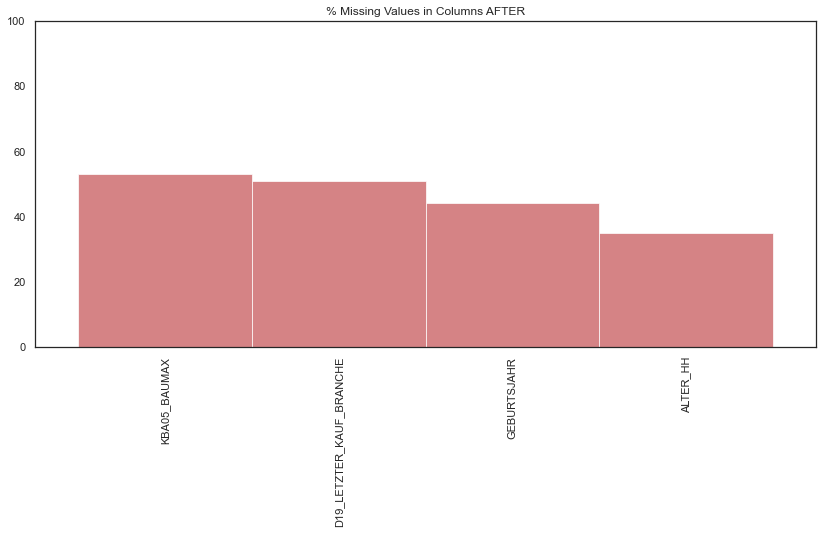

Shape BEFORE row deletion: (891221, 348)


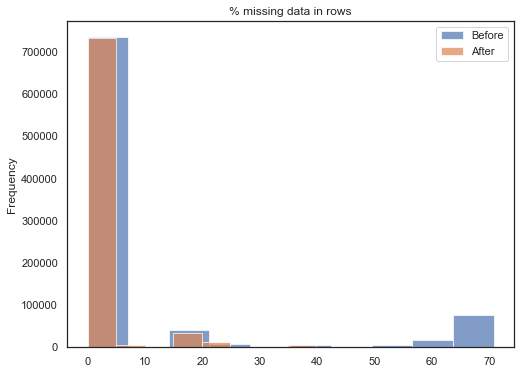

Shape AFTER row deletion: (791246, 348) with threshold of: 0.5
Adding few features WOHNLAGE_QUALITY and WOHNLAGE_RURAL ..........
Adding few features PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT ..........
Adding few features CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFESTAGE ..........
Cleaning PLZ8_BAUMAX, KBA05_BAUMAX .......... 
Cleaning OST_WEST_KZ .......... 
Reducing range for D19_KONSUMTYP_MAX from 1-8 to 1-5
Reducing range for D19_KONSUMTYP from 1-9 to 1-7
Rerank ranges for banking transactions
Categorial columns to one hot encode: ['D19_LETZTER_KAUF_BRANCHE']
353 total features BEFORE one-hot encoding
386 total features AFTER one-hot encoding
[IterativeImputer] Completing matrix with shape (791246, 386)
[IterativeImputer] Ending imputation round 1/15, elapsed time 22.36
[IterativeImputer] Ending imputation round 2/15, elapsed time 45.06
[IterativeImputer] Ending imputation round 3/15, elapsed time 67.72
[IterativeImputer] Ending imputation round 4/15, ela

(791246, 423)

In [118]:
azdias_unsupervised = clean(azdias.copy(), 
                      azdias_extended_na, 
                      rows_threshold=0.50, 
                      impute=True,                            
                      kind='unsupervised')
azdias_unsupervised.shape

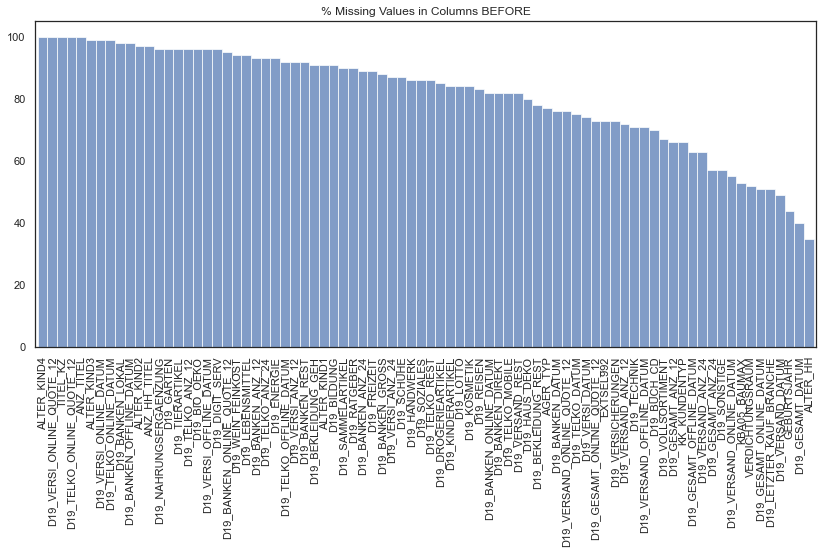

Summarize GRID columns.....
Binarize GRID columns.....


In [ ]:
azdias_unsupervised_na = clean(azdias_extended_na.copy(), 
                      azdias_extended_na, 
                      rows_threshold=1,  
                      impute=False,                            
                      kind='unsupervised')
azdias_unsupervised_na.shape

In [ ]:
# Check that imputing and ohn did notresult in different column headings
list(set(azdias_unsupervised_na.columns) - set(azdias_unsupervised.columns))  

In [ ]:
# Check that imputing and ohn did notresult in different column headings
list(set(azdias_unsupervised.columns) - set(azdias_unsupervised_na.columns))  

In [ ]:
# D19_SOZIALES_0 contains only missing values therefore it's absent from *_na dataset. 
# Manually add it back just to generate the scaler there's no other purpose
# Scaler require fit and transform columns to be in the same order
loc = azdias_unsupervised.columns.get_loc("D19_SOZIALES_0")
loc

In [ ]:
# check if there are any columns missing in customers dataset due to ohn. 
# MinMax scaling requires in latest version the same number of features in the same order
cols = list(set(azdias_unsupervised.columns) - set(azdias_unsupervised_na.columns))  
for col in cols:
    print('Column corrected: {}'.format(col))
    loc = azdias_unsupervised.columns.get_loc(col)
    azdias_unsupervised_na.insert(loc, column=col, value=0)
#     azdias_unsupervised.drop(col, inplace=True, axis=1)    

In [ ]:
azdias_unsupervised_na.head()

<a id='scale'></a>
# Step 7: Generating scalers

I tried to experiment with this advice given by Udacity:

"You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis..."


### Special handling:
- D19_GESAMT_DATUM and similar household fields, was ordered from high to low, with 10 meaning no transactions known, kind of missing value. For scaling this did not make sense at least not do me and it seemed like thise fields became too important during clustering and predictions, so I flipped the numbers 0 to 10 around and made 0 meaning NaN for scaling. So values 1 - 9 would be min / max range, and 0 would become negative values.

- all others, we scale before imputing, and treating ALL missing values temporarily as NaN

#### Generate scaler for SUPERVISED learning
Fit scaler using **full** demographic data, but we use extended version where the treat '0' as NAN as well

In [ ]:
scaler_supervised = MinMaxScaler((0,1))
scaler_supervised.fit(azdias_supervised_na)

# write fitted scaler locally 
if not os.path.exists(path_model):
    os.makedirs(path_model)
dump(scaler_supervised, open(config.filename_scaler_supervised, 'wb'))

In [ ]:
scaled_azdias_supervised = azdias_supervised.copy()
scaled_azdias_supervised = scaler_supervised.transform(scaled_azdias_supervised)
df_scaled_azdias_supervised = pd.DataFrame(scaled_azdias_supervised, 
                                           columns=azdias_supervised.columns,
                                           index=azdias_supervised.index)

df_scaled_azdias_supervised.head(20)

#### Generate scaler for UNSUPERVISED learning
Fit scaler using full demographic data, but we use extended version where the treat '0' as NAN as well

In [ ]:
scaler_unsupervised = MinMaxScaler()
scaler_unsupervised.fit(azdias_unsupervised_na)

# write fitted scaler locally 
if not os.path.exists(path_model):
    os.makedirs(path_model)
dump(scaler_unsupervised, open(config.filename_scaler_unsupervised, 'wb'))

scaled_azdias_unsupervised = azdias_unsupervised.copy()
scaled_azdias_unsupervised = scaler_unsupervised.transform(scaled_azdias_unsupervised)
df_scaled_azdias_unsupervised = pd.DataFrame(scaled_azdias_unsupervised, 
                                           columns=azdias_unsupervised.columns,
                                           index=azdias_unsupervised.index)

In [ ]:
df_scaled_azdias_unsupervised.info()

In [ ]:
col = ['W_KEIT_KIND_HH', 'REGIOTYP', 'ALTER_HH','EINGEZOGENAM_HH_JAHR', 'KBA13_ANZAHL_PKW']

compare_distributions_3by3(df1=azdias, 
                       df2=azdias_supervised, 
                       df3=df_scaled_azdias_supervised,
                       columns=col,
                       kde=False,
                       sharex=False,
                       titles=['Values: Original', 'Values: Imputed', 'Values: Scaled'])

### Exploring and Understanding Scaling

In 'azdias_supervised' dataset, GRID and HOUSEHOLD columns have transactions = 0 not seen as missing
We can observe min = 0, with no values appearing in percentiles 25%, 50% as the majority of data have transactions = 0


In [ ]:
# In azdias supervised dataset, GRID and HOUSEHOLD columns in particular have transactions = 0 not seen as missing
azdias_supervised['D19_VERSAND_ONLINE_DATUM'].describe()

In 'azdias_supervised_na' we treat all values as missing, means they are excluded from min/max ranges. We observe now a better percentile split for data appear for data that are not zero. We will use this dataset to fit the scaler

In [ ]:
azdias_supervised_na['D19_VERSAND_ONLINE_DATUM'].describe()

All 'missing' transactions are now seen as negative, and truly seperated from the rest of the data

In [ ]:
df_scaled_azdias_supervised['D19_VERSAND_ONLINE_DATUM'].describe()

In [ ]:
df_scaled_azdias_supervised['D19_VERSAND_ONLINE_DATUM']

In [ ]:
test_scaler = MinMaxScaler()
azdias_test = test_scaler.fit_transform(azdias_supervised)
df = pd.DataFrame(azdias_test, columns=azdias_supervised.columns, index=azdias_supervised.index)
df['D19_VERSAND_ONLINE_DATUM']

### Scaling conclusion:

Better clustering and prediction results are obtained when using MinMax and excluding zero transactions
GRID and HOUSEHOLD transactions do not take over the prediction results it's 'toned down'.

<a id='references'></a>
# References


Feature Selection:
- https://towardsdatascience.com/how-to-use-variance-thresholding-for-robust-feature-selection-a4503f2b5c3f


Imputing missing values
- https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/
- https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html

AWS and Sagemaker
- https://aws-ml-blog.s3.amazonaws.com/artifacts/prevent-customer-churn/part_2_preventing_customer_churn_XGBoost.html
- https://docs.aws.amazon.com/sagemaker/latest/dg/debugger-training-xgboost-report.html

I have completed the first term of this program in nanodegree 'Introduction to Machine Learning using Pytorch', therefore I am familiar with the first part of this project, from the unsupervised learning project. I have copied some of my prevoius work to use as a base. The versions of those two datasets used in this project include many more features and has not been pre-cleaned, a lot of additional analysis was needed
